# SETUP

## Check environment

In [1]:
USE_GPU = True

In [2]:
try:
    import google.colab
    COLAB = True
except:
    COLAB = False
print(f"Using Google Colab: {COLAB}")

Using Google Colab: False


In [3]:
!pip install --upgrade pip tensorflow keras jupyterlab-vim jupyterlab-indent-guides maap-user-workspace-management-jupyter-extension pydot
!apt-get install graphviz -y

  Using cached tensorflow-2.20.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.5 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
Using cached tensorflow-2.20.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (620.6 MB)
Using cached tensorboard-2.20.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow━━━━━━━━━━━━━━ 0/2 [tensorboard]
    Found existing installation: tensorflow 2.19.00/2 [tensorboard]
    Uninstalling tensorflow-2.19.0:0m╺━━━━━━━━━━━━━━━━━━━ 1/2 [tensorflow]
      Successfully uninstalled tensorflow-2.19.0━━━━━━━━━━━━━━━━━━ 1/2 [tensorflow]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [tensorflow]2 [tensorflow]
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already t

## Libraries

In [4]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K

# Append the custom libraries to system path
if COLAB:
    sys.path.append("/content/air_quality_index_project")

# Configure device
if not USE_GPU:
    print("Using CPU to train")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print("Using GPU to train")

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data, plot_prediction
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import LSTMPrediction
from src.loop_model import generate_loopresults, choose_the_best
from src.reduce_data_utils import prepareReducedData, augmentReducedData
from src.data_utils import mice

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

Using GPU to train
2.20.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration

In [5]:
if COLAB:
    confReader = ConfigurationReader("/content/air_quality_index_project/model_params_colab.json")
else:
    confReader = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json")
print(confReader)

conf = confReader.data

# Clear all temp folders
def cleanDir(input_dir):
    if os.path.exists(input_dir):
        shutil.rmtree(input_dir)
    os.makedirs(input_dir)

cleanDir(conf["workspace"]["model_info_dir"])
cleanDir(conf["workspace"]["model_checkpoints_dir"])
cleanDir(conf["workspace"]["data_statistic_dir"])
cleanDir(conf["workspace"]["data_by_station_dir"])
cleanDir(conf["workspace"]["data_by_location_dir"])
cleanDir(conf["workspace"]["best_reduction_models_dir"])
cleanDir(conf["workspace"]["best_reduced_data"])

{
    "dataset": {
        "aod2022": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MatchingData2022.xlsx",
            "target_start_date": "2022-01-01",
            "target_end_date": "2022-12-31"
        },
        "aod2021": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/aod_data_daily.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2021-12-31"
        },
        "mpair": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MPair.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2022-12-31",
            "station_2022_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2022.csv",
            "station_2018_2021_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2018-2021.c

# AOD DATA

## Load 2022 dataset

In [6]:
df_aod_raw_2022 = pd.read_excel(conf["dataset"]["aod2022"]["file_dir"])

print(df_aod_raw_2022.columns)
df_aod_raw_2022

Index(['time', 'ID', 'pm25', 'lat', 'lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'PRES2M', 'AOD', 'OID', 'POP', 'ROAD_DEN_1km',
       'PRIM_ROAD_LEN_1km', 'NEAR_DIST', 'BARELAND', 'BUILTUP', 'CROPLAND',
       'GRASSLAND', 'TREECOVER', 'WATER', 'NDVI', 'Name'],
      dtype='object')


time  ID       pm25        lat         lon   PM25_3km        TMP  \
0    2022-01-01  S4  23.768238  10.815839  106.717396  22.025597  28.261583   
1    2022-01-01  S5  14.221014  10.776415  106.687955  22.705284  27.787918   
2    2022-01-01  S6  21.405015  10.780482  106.659511  23.503082  27.787918   
3    2022-01-01  S7  21.695652  10.783456  106.700622  22.705284  27.787918   
4    2022-01-02  S4  22.154723  10.815839  106.717396  22.711113  25.827082   
..          ...  ..        ...        ...         ...        ...        ...   
993  2022-12-30  S6  33.091428  10.780482  106.659511  19.854403  24.979719   
994  2022-12-30  S7  40.166667  10.783456  106.700622  19.137615  24.979719   
995  2022-12-31  S4  27.879261  10.815839  106.717396  28.223820  26.630608   
996  2022-12-31  S6  28.854069  10.780482  106.659511  27.658358  25.364861   
997  2022-12-31  S7  33.958333  10.783456  106.700622  26.659830  25.364861   

            RH        HPBL      WSPD  ...  PRIM_ROAD_LEN_1km  NEAR_DIST  \
0    57.233841  721.996887  2.003031  ...        2327.256348   2.546965   
1    61.073841  659.863586  1.885687  ...        7249.776367  21.703104   
2    61.073841  659.863586  1.885687  ...        2345.868408   6.057246   
3    61.073841  659.863586  1.885687  ...        6885.987305  18.537305   
4    57.916595  619.779785  1.286289  ...        2327.256348   2.546965   
..         ...         ...       ...  ...                ...        ...   
993  64.868401  680.533081  3.893373  ...        2345.868408   6.057246   
994  64.868401  680.533081  3.893373  ...        6885.987305  18.537305   
995  55.437901  607.372803  4.217750  ...        2327.256348   2.546965   
996  62.377899  799.122803  4.161542  ...        2345.868408   6.057246   
997  62.377899  799.122803  4.161542  ...        6885.987305  18.537305   

         BARELAND      BUILTUP   CROPLAND    GRASSLAND     TREECOVER  \
0     1876.639945  841524.8595  296.31157  3753.279890   91461.50468   
1      395.082094  877872.4121    0.00000    98.770523  121487.74380   
2    10370.904960  885181.4309    0.00000  8099.182920   95807.40771   
3      296.311570  764977.7039    0.00000  1876.639945  232011.95950   
4     1876.639945  841524.8595  296.31157  3753.279890   91461.50468   
..            ...          ...        ...          ...           ...   
993  10370.904960  885181.4309    0.00000  8099.182920   95807.40771   
994    296.311570  764977.7039    0.00000  1876.639945  232011.95950   
995   1876.639945  841524.8595  296.31157  3753.279890   91461.50468   
996  10370.904960  885181.4309    0.00000  8099.182920   95807.40771   
997    296.311570  764977.7039    0.00000  1876.639945  232011.95950   

           WATER         NDVI  \
0    61731.57713  1818.661486   
1        0.00000  1721.431568   
2        0.00000  1879.344348   
3        0.00000  2700.122924   
4    61731.57713  1818.661486   
..           ...          ...   
993      0.00000  1879.344348   
994      0.00000  2700.122924   
995  61731.57713  1818.661486   
996      0.00000  1879.344348   
997      0.00000  2700.122924   

                                                  Name  
0    Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn...  
1     Tòa soạn Báo Thanh Niên - Nguyễn Đình Chiểu - Q3  
2                             MobiFone Thành Thái, Q10  
3                                               ĐSQ Mỹ  
4    Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn...  
..                                                 ...  
993                           MobiFone Thành Thái, Q10  
994                                             ĐSQ Mỹ  
995  Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn...  
996                           MobiFone Thành Thái, Q10  
997                                             ĐSQ Mỹ  

[998 rows x 25 columns]

In [7]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2022 = df_aod_raw_2022.assign(time=pd.to_datetime(df_aod_raw_2022["time"]))

# Set "time" column as index
#df_aod_raw_2022.set_index("time", inplace=True)

# Lower case all column names
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={name: name.lower() for name in df_aod_raw_2022.columns})

# Rename oid to station
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={"oid": "station"})

# Drop unnecessary columns
df_aod_raw_2022.drop(columns=["name", "id"], axis=1, inplace=True)

# Print
df_aod_raw_2022

time       pm25        lat         lon   pm25_3km        tmp  \
0   2022-01-01  23.768238  10.815839  106.717396  22.025597  28.261583   
1   2022-01-01  14.221014  10.776415  106.687955  22.705284  27.787918   
2   2022-01-01  21.405015  10.780482  106.659511  23.503082  27.787918   
3   2022-01-01  21.695652  10.783456  106.700622  22.705284  27.787918   
4   2022-01-02  22.154723  10.815839  106.717396  22.711113  25.827082   
..         ...        ...        ...         ...        ...        ...   
993 2022-12-30  33.091428  10.780482  106.659511  19.854403  24.979719   
994 2022-12-30  40.166667  10.783456  106.700622  19.137615  24.979719   
995 2022-12-31  27.879261  10.815839  106.717396  28.223820  26.630608   
996 2022-12-31  28.854069  10.780482  106.659511  27.658358  25.364861   
997 2022-12-31  33.958333  10.783456  106.700622  26.659830  25.364861   

            rh        hpbl      wspd         pres2m  ...  road_den_1km  \
0    57.233841  721.996887  2.003031  101227.000000  ...     22.923040   
1    61.073841  659.863586  1.885687  101204.875000  ...     23.362053   
2    61.073841  659.863586  1.885687  101204.875000  ...     33.629780   
3    61.073841  659.863586  1.885687  101204.875000  ...     27.462461   
4    57.916595  619.779785  1.286289  101201.015625  ...     22.923040   
..         ...         ...       ...            ...  ...           ...   
993  64.868401  680.533081  3.893373  101393.398438  ...     33.629780   
994  64.868401  680.533081  3.893373  101393.398438  ...     27.462461   
995  55.437901  607.372803  4.217750  101322.437500  ...     22.923040   
996  62.377899  799.122803  4.161542  101297.140625  ...     33.629780   
997  62.377899  799.122803  4.161542  101297.140625  ...     27.462461   

     prim_road_len_1km  near_dist      bareland      builtup   cropland  \
0          2327.256348   2.546965   1876.639945  841524.8595  296.31157   
1          7249.776367  21.703104    395.082094  877872.4121    0.00000   
2          2345.868408   6.057246  10370.904960  885181.4309    0.00000   
3          6885.987305  18.537305    296.311570  764977.7039    0.00000   
4          2327.256348   2.546965   1876.639945  841524.8595  296.31157   
..                 ...        ...           ...          ...        ...   
993        2345.868408   6.057246  10370.904960  885181.4309    0.00000   
994        6885.987305  18.537305    296.311570  764977.7039    0.00000   
995        2327.256348   2.546965   1876.639945  841524.8595  296.31157   
996        2345.868408   6.057246  10370.904960  885181.4309    0.00000   
997        6885.987305  18.537305    296.311570  764977.7039    0.00000   

       grassland     treecover        water         ndvi  
0    3753.279890   91461.50468  61731.57713  1818.661486  
1      98.770523  121487.74380      0.00000  1721.431568  
2    8099.182920   95807.40771      0.00000  1879.344348  
3    1876.639945  232011.95950      0.00000  2700.122924  
4    3753.279890   91461.50468  61731.57713  1818.661486  
..           ...           ...          ...          ...  
993  8099.182920   95807.40771      0.00000  1879.344348  
994  1876.639945  232011.95950      0.00000  2700.122924  
995  3753.279890   91461.50468  61731.57713  1818.661486  
996  8099.182920   95807.40771      0.00000  1879.344348  
997  1876.639945  232011.95950      0.00000  2700.122924  

[998 rows x 23 columns]

In [8]:
df_aod_raw_2022["station"].unique()

array([214, 215, 216, 201])

## Load 2021 dataset

In [9]:
df_aod_raw_2021 = pd.read_csv(conf["dataset"]["aod2021"]["file_dir"])

print(df_aod_raw_2021.columns)
df_aod_raw_2021

Index(['time', 'ID', 'pm25', 'Lat', 'Lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'POP', 'ROAD_DEN_1km', 'PRIM_ROAD_LEN_1km', 'NEAR_DIST',
       'BARELAND', 'BUILTUP', 'CROPLAND', 'GRASSLAND', 'TREECOVER', 'WATER',
       'NDVI', 'AOD'],
      dtype='object')


time   ID       pm25        Lat         Lon   PM25_3km        TMP  \
0       1/1/2018  201  31.391304  10.783057  106.700606  34.919998  25.204139   
1       1/1/2018  202  29.615625  10.762638  106.682027  32.099998  25.100436   
2       1/2/2018  201  37.458333  10.783057  106.700606  51.830002  24.726431   
3       1/2/2018  202  36.244792  10.762638  106.682027  44.619999  24.663358   
4       1/3/2018  201  68.083333  10.783057  106.700606  38.240002  26.095087   
...          ...  ...        ...        ...         ...        ...        ...   
2886  12/31/2021  211  14.474306  10.870190  106.796200  17.930000  23.428631   
2887  12/31/2021  212  20.100752  10.740760  106.617000  20.010000  24.914532   
2888  12/31/2021  213  23.240539  10.816350  106.620500  20.700001  24.171986   
2889  12/31/2021  214  20.549839  10.815570  106.717500  21.040001  24.367620   
2890  12/31/2021  216  19.637165  10.780630  106.659300  20.840000  22.830532   

             RH        HPBL      WSPD  ...  PRIM_ROAD_LEN_1km  NEAR_DIST  \
0     70.056728  455.131335  2.352895  ...        6885.987305  18.537305   
1     71.060891  457.243423  2.344162  ...        7097.612305   3.822386   
2     73.425826  339.083720  1.903761  ...        6885.987305  18.537305   
3     73.870799  338.530190  1.885305  ...        7097.612305   3.822386   
4     77.793432  367.190738  1.293329  ...        6885.987305  18.537305   
...         ...         ...       ...  ...                ...        ...   
2886  75.209297  134.323181  1.485907  ...           0.000000  49.023548   
2887  64.741638  212.347687  2.196620  ...        2529.119629  20.331284   
2888  67.759666  145.481979  2.459679  ...           0.000000   7.560823   
2889  67.038559  168.648315  2.101351  ...        2327.256348   2.546965   
2890  79.056641  184.397690  2.316177  ...        2345.868408   6.057246   

          BARELAND      BUILTUP     CROPLAND     GRASSLAND     TREECOVER  \
0       296.311570  764977.7039     0.000000   1876.639945  232011.95950   
1       395.082094  947604.4016     0.000000   2963.115702   13926.64380   
2       296.311570  764977.7039     0.000000   1876.639945  232011.95950   
3       395.082094  947604.4016     0.000000   2963.115702   13926.64380   
4       296.311570  764977.7039     0.000000   1876.639945  232011.95950   
...            ...          ...          ...           ...           ...   
2886   1086.475758  724185.4777   592.623140  46915.998620  225888.18710   
2887  16297.136360  892984.3022  7506.559780  26470.500280   57681.98567   
2888  13136.479610  928245.3791  4247.132507  17581.153170   34964.76529   
2889   1876.639945  841524.8595   296.311570   3753.279890   91461.50468   
2890  10370.904960  885181.4309     0.000000   8099.182920   95807.40771   

             WATER         NDVI       AOD  
0         0.000000  2700.122924       NaN  
1     35063.535810  1765.098553       NaN  
2         0.000000  2700.122924  1.110117  
3     35063.535810  1765.098553  1.277641  
4         0.000000  2700.122924  1.439045  
...            ...          ...       ...  
2886      0.000000  3579.160484       NaN  
2887      0.000000  3266.283480       NaN  
2888   1481.557851  2535.126792  0.272610  
2889  61731.577130  1818.661486  0.524898  
2890      0.000000  1879.344348       NaN  

[2891 rows x 22 columns]

In [10]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2021['time'] = pd.to_datetime(df_aod_raw_2021['time'])

# Set "time" column as index
#df_aod_raw_2021.set_index("time", inplace=True)

# Lower case all column names
df_aod_raw_2021.rename(columns={name: name.lower() for name in df_aod_raw_2021.columns}, inplace=True)

# Rename "id" to "station"
df_aod_raw_2021.rename(columns={'id':'station'}, inplace=True)

# Only get data in 2021
time_mask = ((df_aod_raw_2021["time"] >= conf["dataset"]["aod2021"]["target_start_date"]) & (df_aod_raw_2021["time"] <= conf["dataset"]["aod2021"]["target_end_date"]))
df_aod_raw_2021 = df_aod_raw_2021.loc[time_mask]

# Print
df_aod_raw_2021

time  station       pm25        lat         lon   pm25_3km  \
1316 2021-01-01      201  17.250000  10.783057  106.700606  38.320000   
1317 2021-01-02      201  23.000000  10.783057  106.700606  56.650002   
1318 2021-01-03      201  28.291667  10.783057  106.700606  56.900002   
1319 2021-01-04      201  28.791667  10.783057  106.700606  61.560001   
1320 2021-01-05      201  24.833333  10.783057  106.700606  69.949997   
...         ...      ...        ...        ...         ...        ...   
2886 2021-12-31      211  14.474306  10.870190  106.796200  17.930000   
2887 2021-12-31      212  20.100752  10.740760  106.617000  20.010000   
2888 2021-12-31      213  23.240539  10.816350  106.620500  20.700001   
2889 2021-12-31      214  20.549839  10.815570  106.717500  21.040001   
2890 2021-12-31      216  19.637165  10.780630  106.659300  20.840000   

            tmp         rh        hpbl      wspd  ...  prim_road_len_1km  \
1316  25.873598  60.583508  561.605774  3.548874  ...        6885.987305   
1317  25.527328  60.219109  527.248901  2.355864  ...        6885.987305   
1318  26.878422  61.481564  469.774841  1.896463  ...        6885.987305   
1319  27.771753  61.013718  615.690735  1.642178  ...        6885.987305   
1320  27.660774  61.277409  665.619263  2.859253  ...        6885.987305   
...         ...        ...         ...       ...  ...                ...   
2886  23.428631  75.209297  134.323181  1.485907  ...           0.000000   
2887  24.914532  64.741638  212.347687  2.196620  ...        2529.119629   
2888  24.171986  67.759666  145.481979  2.459679  ...           0.000000   
2889  24.367620  67.038559  168.648315  2.101351  ...        2327.256348   
2890  22.830532  79.056641  184.397690  2.316177  ...        2345.868408   

      near_dist      bareland      builtup     cropland     grassland  \
1316  18.537305    296.311570  764977.7039     0.000000   1876.639945   
1317  18.537305    296.311570  764977.7039     0.000000   1876.639945   
1318  18.537305    296.311570  764977.7039     0.000000   1876.639945   
1319  18.537305    296.311570  764977.7039     0.000000   1876.639945   
1320  18.537305    296.311570  764977.7039     0.000000   1876.639945   
...         ...           ...          ...          ...           ...   
2886  49.023548   1086.475758  724185.4777   592.623140  46915.998620   
2887  20.331284  16297.136360  892984.3022  7506.559780  26470.500280   
2888   7.560823  13136.479610  928245.3791  4247.132507  17581.153170   
2889   2.546965   1876.639945  841524.8595   296.311570   3753.279890   
2890   6.057246  10370.904960  885181.4309     0.000000   8099.182920   

         treecover         water         ndvi       aod  
1316  232011.95950      0.000000  2700.122924       NaN  
1317  232011.95950      0.000000  2700.122924       NaN  
1318  232011.95950      0.000000  2700.122924       NaN  
1319  232011.95950      0.000000  2700.122924       NaN  
1320  232011.95950      0.000000  2700.122924       NaN  
...            ...           ...          ...       ...  
2886  225888.18710      0.000000  3579.160484       NaN  
2887   57681.98567      0.000000  3266.283480       NaN  
2888   34964.76529   1481.557851  2535.126792  0.272610  
2889   91461.50468  61731.577130  1818.661486  0.524898  
2890   95807.40771      0.000000  1879.344348       NaN  

[1575 rows x 22 columns]

In [11]:
df_aod_raw_2021["station"].unique()

array([201, 211, 212, 213, 214, 215, 216])

## Merge dataset

In [12]:
# Remove "pres2m" column in 2022 because it doesn't have value in 2021
df_aod_raw_2022.drop(["pres2m"], axis=1, inplace=True)

# Start merging
df_aod_raw = pd.concat([df_aod_raw_2021, df_aod_raw_2022], axis=0)

# Sort data by "station" then "time"
df_aod_raw.sort_values(by=["station", "time"], ascending=[True, True], inplace=True)

# Set index
df_aod_raw.set_index("time", inplace=True)

# Print
df_aod_raw

station       pm25        lat         lon   pm25_3km        tmp  \
time                                                                          
2021-01-01      201  17.250000  10.783057  106.700606  38.320000  25.873598   
2021-01-02      201  23.000000  10.783057  106.700606  56.650002  25.527328   
2021-01-03      201  28.291667  10.783057  106.700606  56.900002  26.878422   
2021-01-04      201  28.791667  10.783057  106.700606  61.560001  27.771753   
2021-01-05      201  24.833333  10.783057  106.700606  69.949997  27.660774   
...             ...        ...        ...         ...        ...        ...   
2022-12-27      216  39.659816  10.780482  106.659511  34.439411  24.136936   
2022-12-28      216  44.679352  10.780482  106.659511  29.838476  25.844296   
2022-12-29      216  30.724708  10.780482  106.659511  28.450829  25.841156   
2022-12-30      216  33.091428  10.780482  106.659511  19.854403  24.979719   
2022-12-31      216  28.854069  10.780482  106.659511  27.658358  25.364861   

                   rh        hpbl      wspd          pop  ...  \
time                                                      ...   
2021-01-01  60.583508  561.605774  3.548874  20680.62695  ...   
2021-01-02  60.219109  527.248901  2.355864  20680.62695  ...   
2021-01-03  61.481564  469.774841  1.896463  20680.62695  ...   
2021-01-04  61.013718  615.690735  1.642178  20680.62695  ...   
2021-01-05  61.277409  665.619263  2.859253  20680.62695  ...   
...               ...         ...       ...          ...  ...   
2022-12-27  73.973083  457.798645  2.002987  57523.91406  ...   
2022-12-28  65.530487  644.974548  2.298220  57523.91406  ...   
2022-12-29  67.093735  825.517395  2.823764  57523.91406  ...   
2022-12-30  64.868401  680.533081  3.893373  57523.91406  ...   
2022-12-31  62.377899  799.122803  4.161542  57523.91406  ...   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2021-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi       aod  
time                                                                 
2021-01-01  1876.639945  232011.95950    0.0  2700.122924       NaN  
2021-01-02  1876.639945  232011.95950    0.0  2700.122924       NaN  
2021-01-03  1876.639945  232011.95950    0.0  2700.122924       NaN  
2021-01-04  1876.639945  232011.95950    0.0  2700.122924       NaN  
2021-01-05  1876.639945  232011.95950    0.0  2700.122924       NaN  
...                 ...           ...    ...          ...       ...  
2022-12-27  8099.182920   95807.40771    0.0  1879.344348       NaN  
2022-12-28  8099.182920   95807.40771    0.0  1879.344348       NaN  
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  0.191691  
2022-12-30  8099.182920   95807.40771    0.0  1879.344348       NaN  
2022-12-31  8099.182920   95807.40771    0.0  1879.344348       NaN  

[2573 rows x 21 columns]

In [13]:
df_aod_raw.to_csv('df_aod_raw.csv', index=True)

## Statistics

In [14]:
df_aod_stat = df_aod_raw.describe()
df_aod_stat.to_csv(f'{conf["workspace"]["data_statistic_dir"]}/df_aod_stat.csv')

In [15]:
df_aod_raw.isnull().sum()

station                 0
pm25                    0
lat                     0
lon                     0
pm25_3km                0
tmp                     0
rh                      0
hpbl                    0
wspd                    0
pop                     0
road_den_1km            0
prim_road_len_1km       0
near_dist               0
bareland                0
builtup                 0
cropland                0
grassland               0
treecover               0
water                   0
ndvi                    0
aod                  2201
dtype: int64

## Preprocessing

### Define label, static features and dynamic features

In [16]:
aod_label = ["pm25"]
aod_index = ["time"]
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', \
                  'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = list(set(df_aod_raw.columns) - set(aod_stat_feats) - set(aod_label) - set(aod_index))
aod_all_stations = sorted(df_aod_raw["station"].unique())

print(f'aod_label = {aod_label}\naod_stat_feats = {aod_stat_feats}\naod_dyn_feats = {aod_dyn_feats}\naod_all_stations = {aod_all_stations}')

aod_label = ['pm25']
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = ['aod', 'rh', 'wspd', 'hpbl', 'pm25_3km', 'tmp']
aod_all_stations = [201, 211, 212, 213, 214, 215, 216]


### Fill "aod" column


Handling for station 201



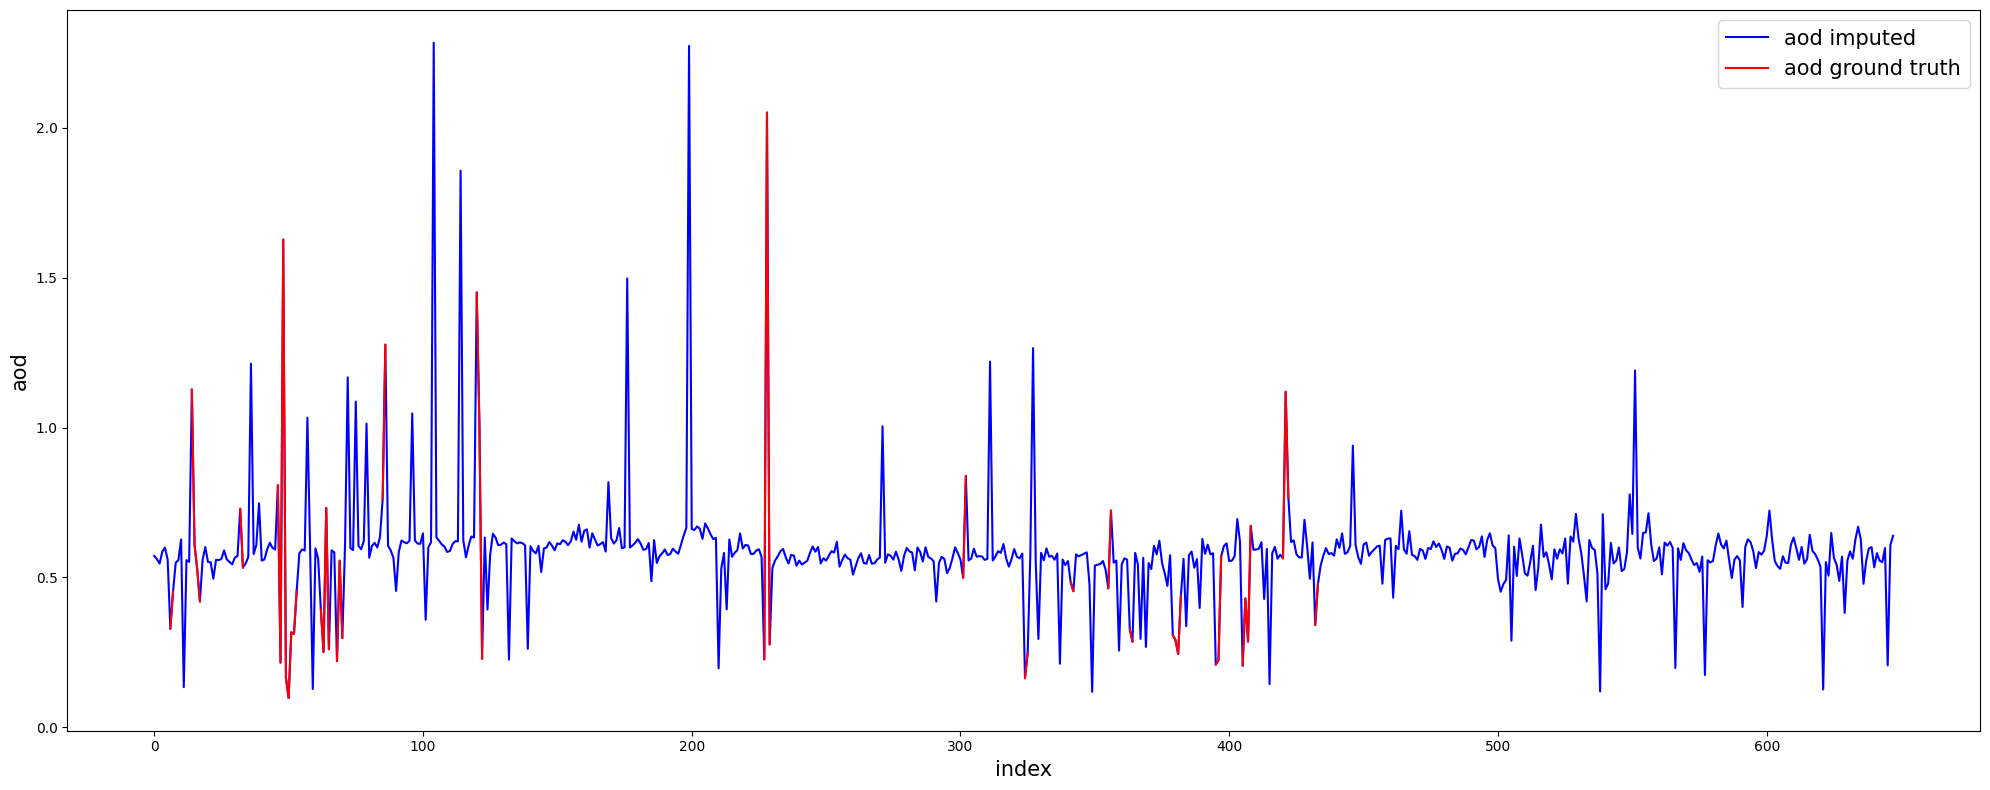


Handling for station 211



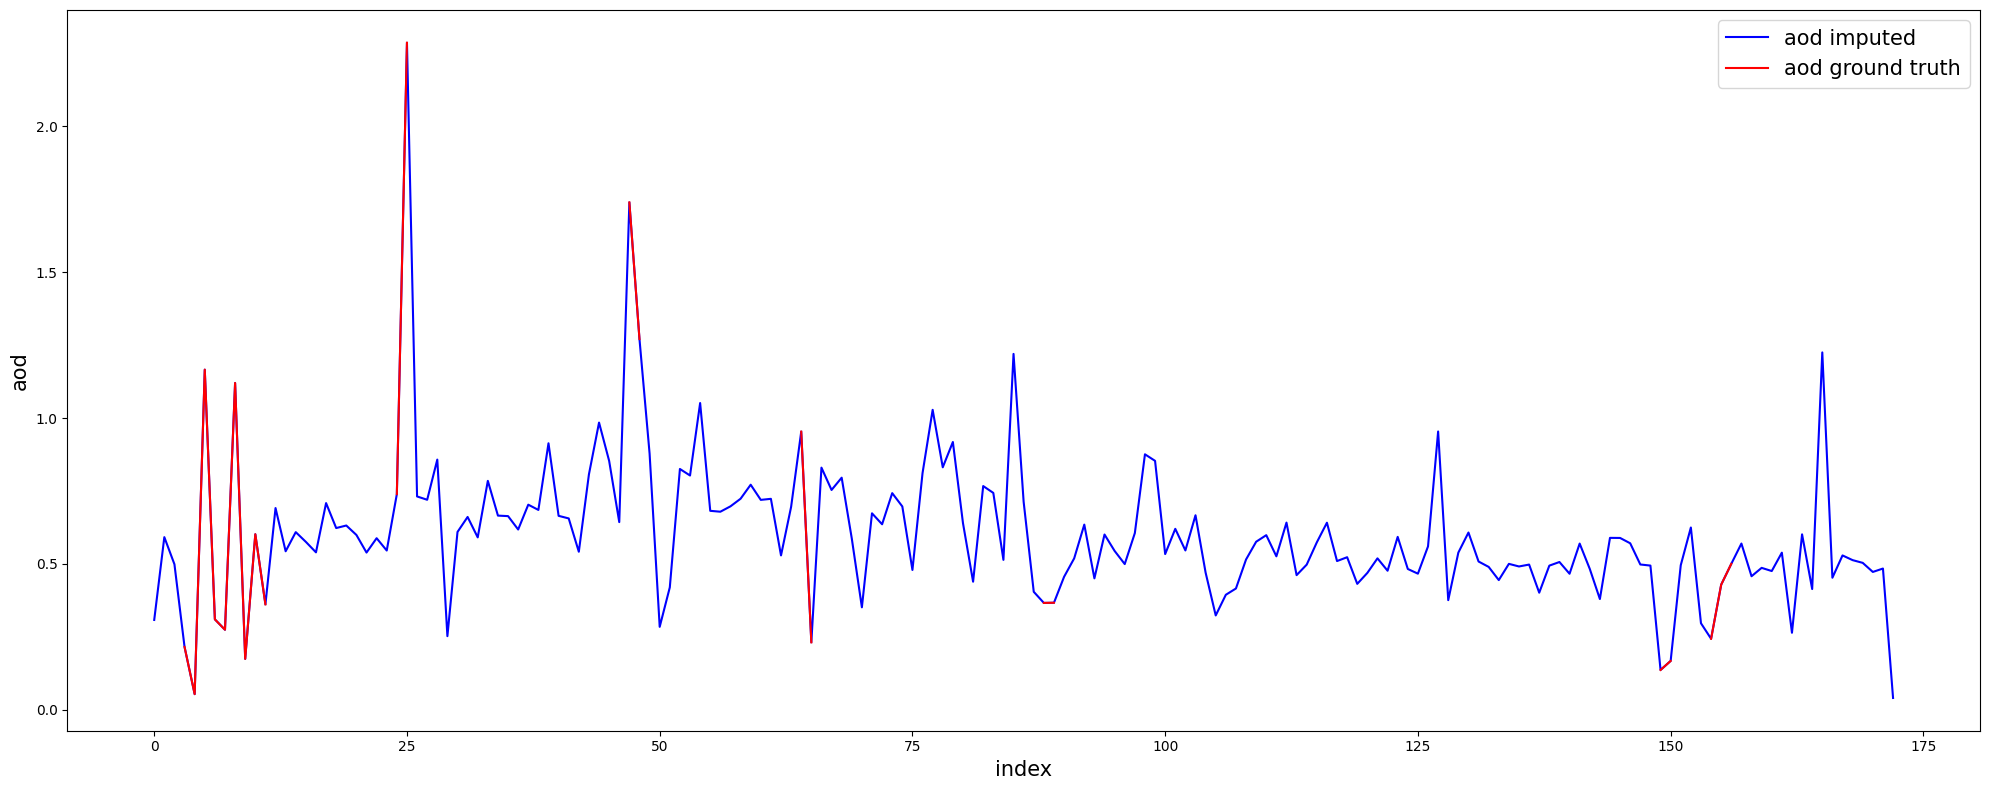


Handling for station 212



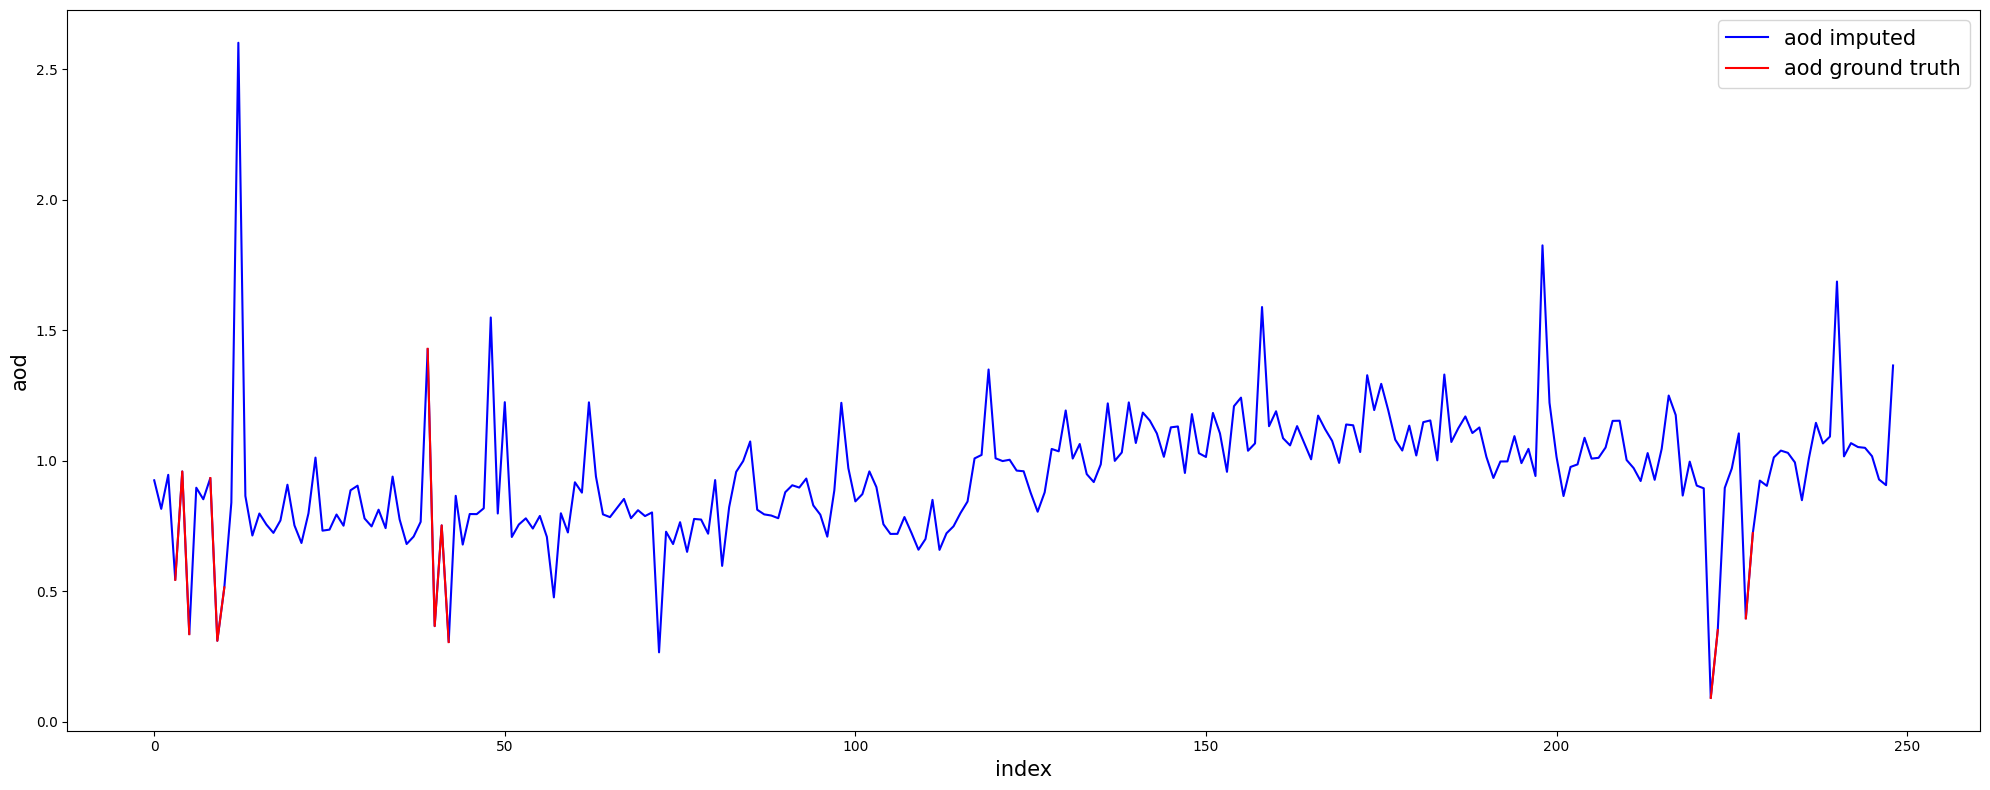


Handling for station 213



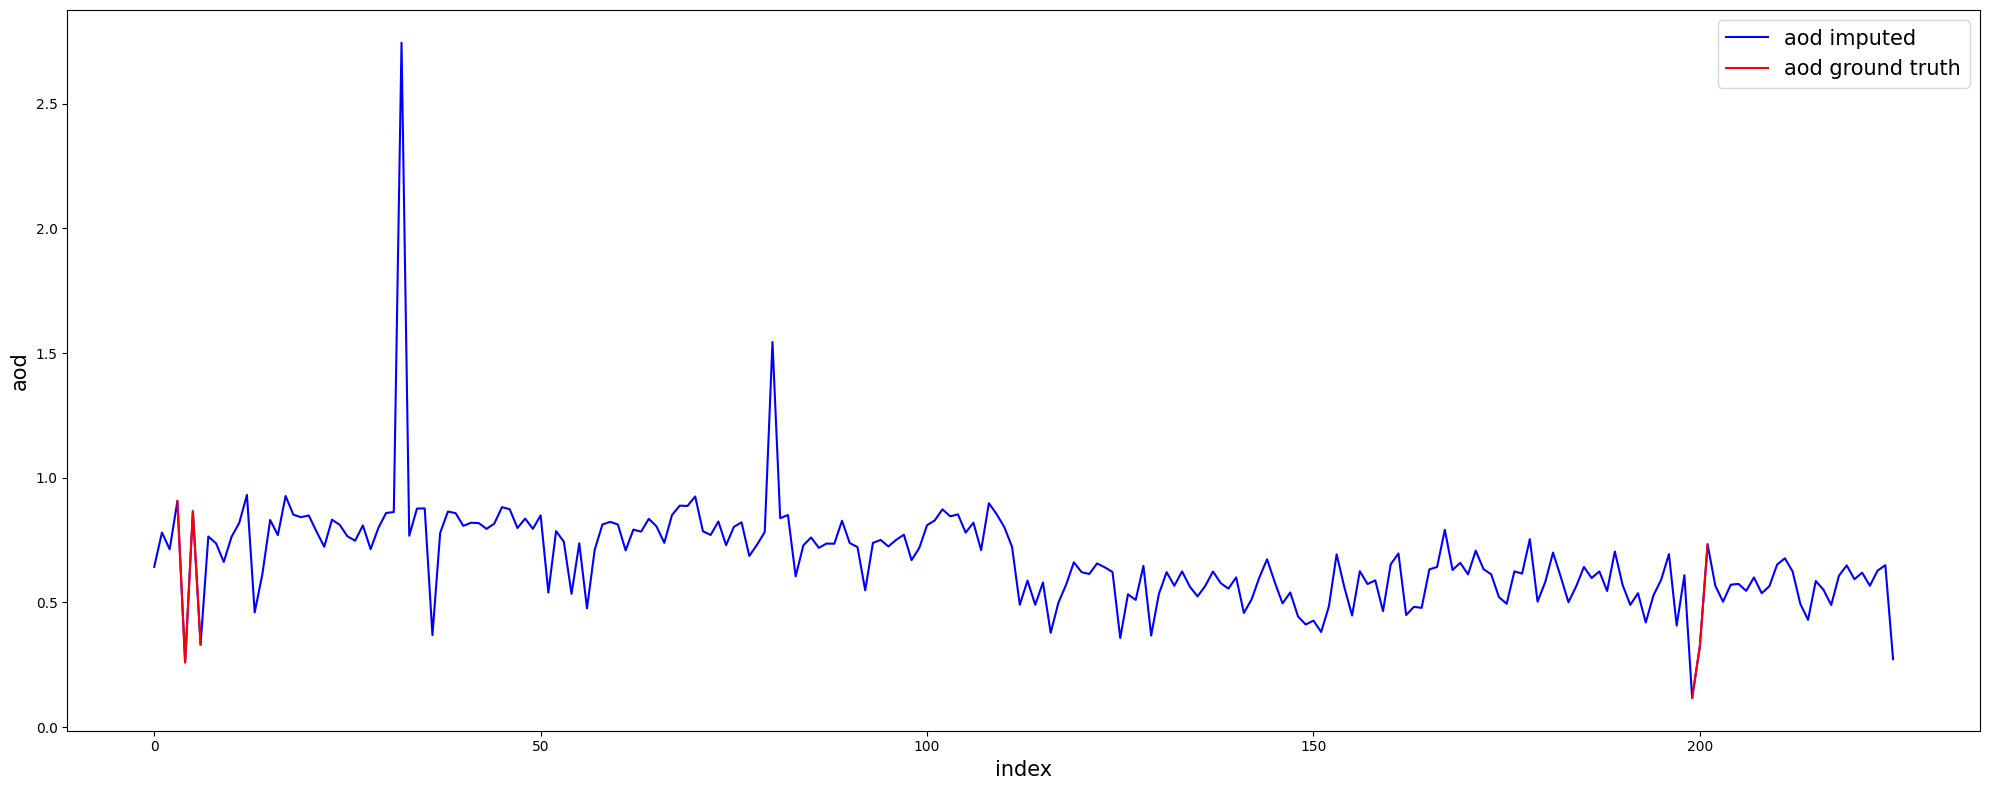


Handling for station 214



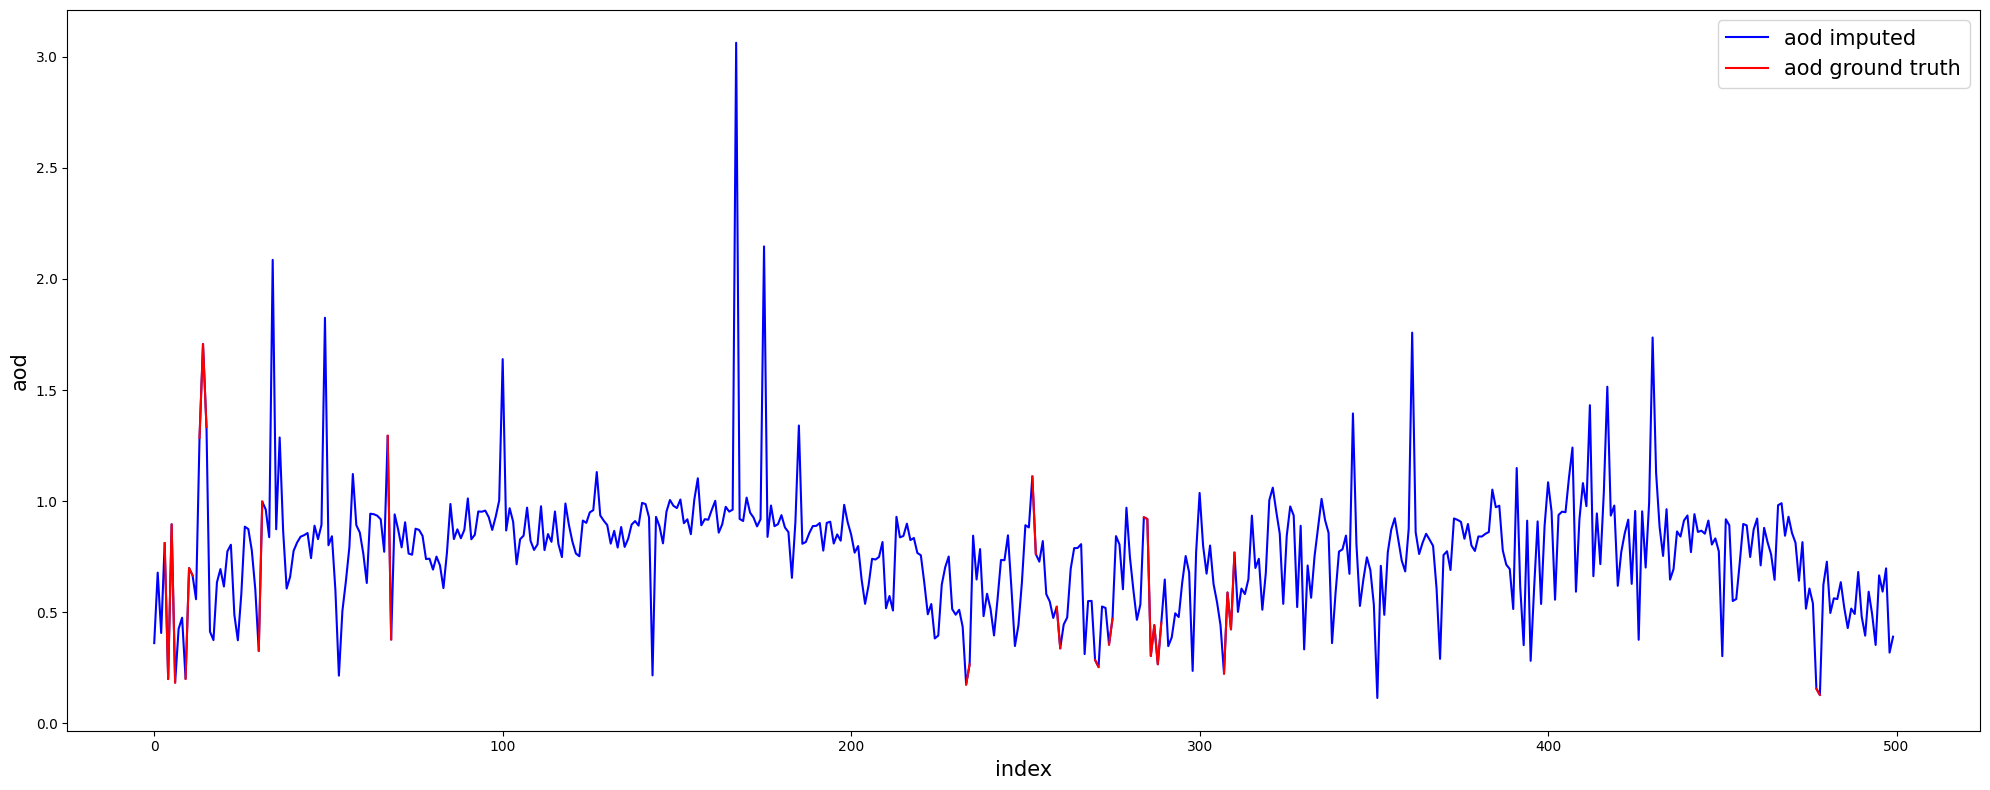


Handling for station 215



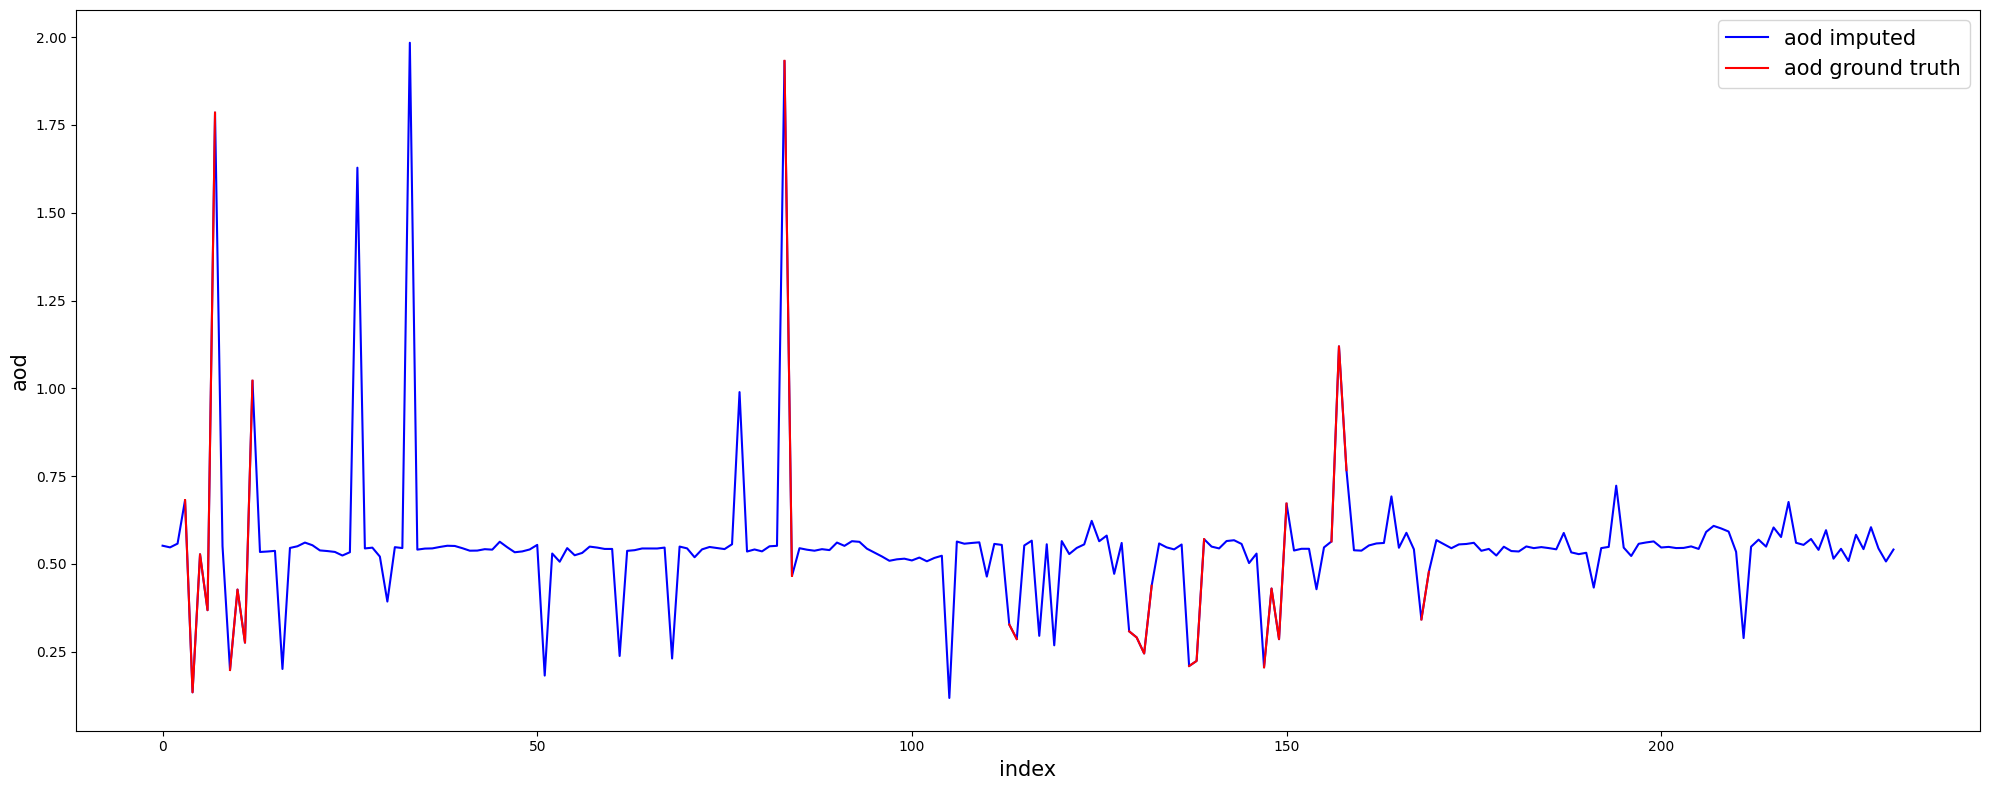


Handling for station 216



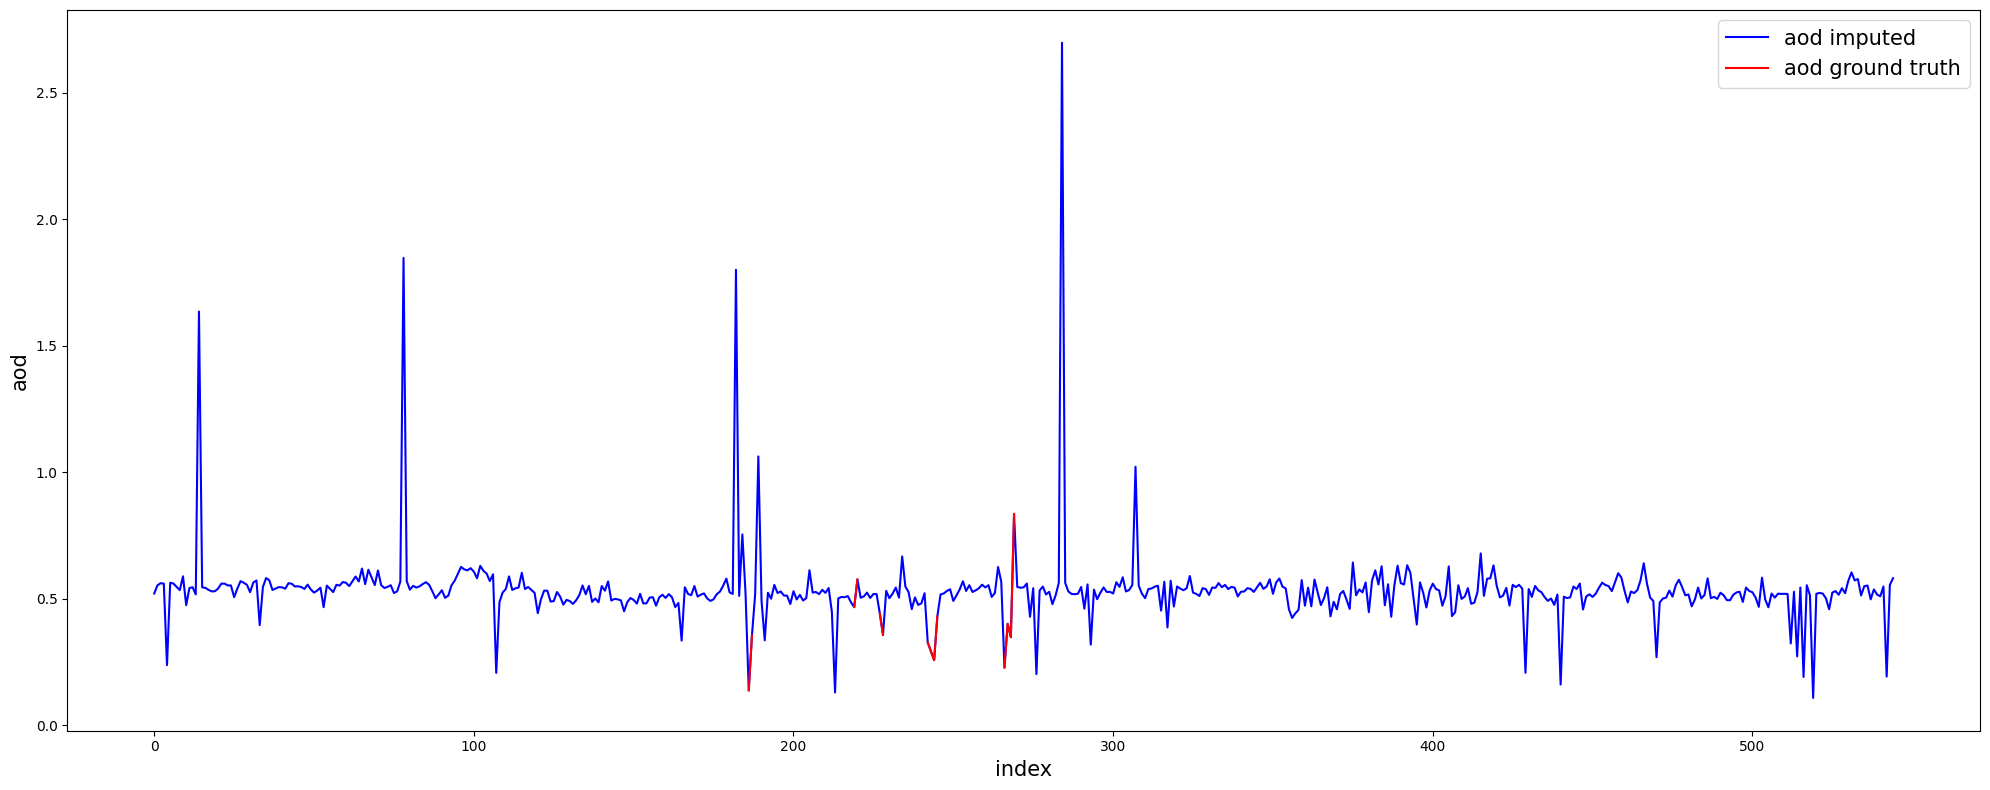

station       pm25        lat         lon   pm25_3km        tmp  \
time                                                                          
2021-01-01      201  17.250000  10.783057  106.700606  38.320000  25.873598   
2021-01-02      201  23.000000  10.783057  106.700606  56.650002  25.527328   
2021-01-03      201  28.291667  10.783057  106.700606  56.900002  26.878422   
2021-01-04      201  28.791667  10.783057  106.700606  61.560001  27.771753   
2021-01-05      201  24.833333  10.783057  106.700606  69.949997  27.660774   
...             ...        ...        ...         ...        ...        ...   
2022-12-27      216  39.659816  10.780482  106.659511  34.439411  24.136936   
2022-12-28      216  44.679352  10.780482  106.659511  29.838476  25.844296   
2022-12-29      216  30.724708  10.780482  106.659511  28.450829  25.841156   
2022-12-30      216  33.091428  10.780482  106.659511  19.854403  24.979719   
2022-12-31      216  28.854069  10.780482  106.659511  27.658358  25.364861   

                   rh        hpbl      wspd          pop  ...  \
time                                                      ...   
2021-01-01  60.583508  561.605774  3.548874  20680.62695  ...   
2021-01-02  60.219109  527.248901  2.355864  20680.62695  ...   
2021-01-03  61.481564  469.774841  1.896463  20680.62695  ...   
2021-01-04  61.013718  615.690735  1.642178  20680.62695  ...   
2021-01-05  61.277409  665.619263  2.859253  20680.62695  ...   
...               ...         ...       ...          ...  ...   
2022-12-27  73.973083  457.798645  2.002987  57523.91406  ...   
2022-12-28  65.530487  644.974548  2.298220  57523.91406  ...   
2022-12-29  67.093735  825.517395  2.823764  57523.91406  ...   
2022-12-30  64.868401  680.533081  3.893373  57523.91406  ...   
2022-12-31  62.377899  799.122803  4.161542  57523.91406  ...   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2021-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi       aod  
time                                                                 
2021-01-01  1876.639945  232011.95950    0.0  2700.122924  0.571852  
2021-01-02  1876.639945  232011.95950    0.0  2700.122924  0.561221  
2021-01-03  1876.639945  232011.95950    0.0  2700.122924  0.546221  
2021-01-04  1876.639945  232011.95950    0.0  2700.122924  0.586047  
2021-01-05  1876.639945  232011.95950    0.0  2700.122924  0.599603  
...                 ...           ...    ...          ...       ...  
2022-12-27  8099.182920   95807.40771    0.0  1879.344348  0.508564  
2022-12-28  8099.182920   95807.40771    0.0  1879.344348  0.547594  
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  0.191691  
2022-12-30  8099.182920   95807.40771    0.0  1879.344348  0.554055  
2022-12-31  8099.182920   95807.40771    0.0  1879.344348  0.580505  

[2573 rows x 21 columns]

In [17]:
all_stations_df = []

for station in aod_all_stations:
    print(f"\nHandling for station {station}\n")
    # Get dataframe of current station
    df_aod_current_station = df_aod_raw[df_aod_raw["station"] == station]
    
    # Fill "aod" column
    #df_aod_current_station.loc[:, "aod"] = df_aod_current_station.loc[:, "aod"].fillna(df_aod_current_station.loc[:, "aod"].mean())
    df_aod_current_station_imputed = copy.deepcopy(df_aod_current_station)
    df_aod_current_station_imputed.loc[:, "aod"] = mice(df_aod_current_station_imputed.drop(columns=["station", "pm25"]))["aod"]
    plot_2_data(data1=df_aod_current_station_imputed["aod"],
               datalabel1="aod imputed",
               data2=df_aod_current_station["aod"],
               datalabel2="aod ground truth",
               ylabel="aod",
               xlabel="index")

    # Store file for debugging after filling missing values
    df_aod_current_station_imputed.to_csv(f"{conf['workspace']['data_by_station_dir']}/df_aod_{station}.csv", index=True)

    # Reappend the location to dataset
    all_stations_df.append(df_aod_current_station_imputed)

# Merge all stations
df_aod = pd.concat(all_stations_df)
df_aod

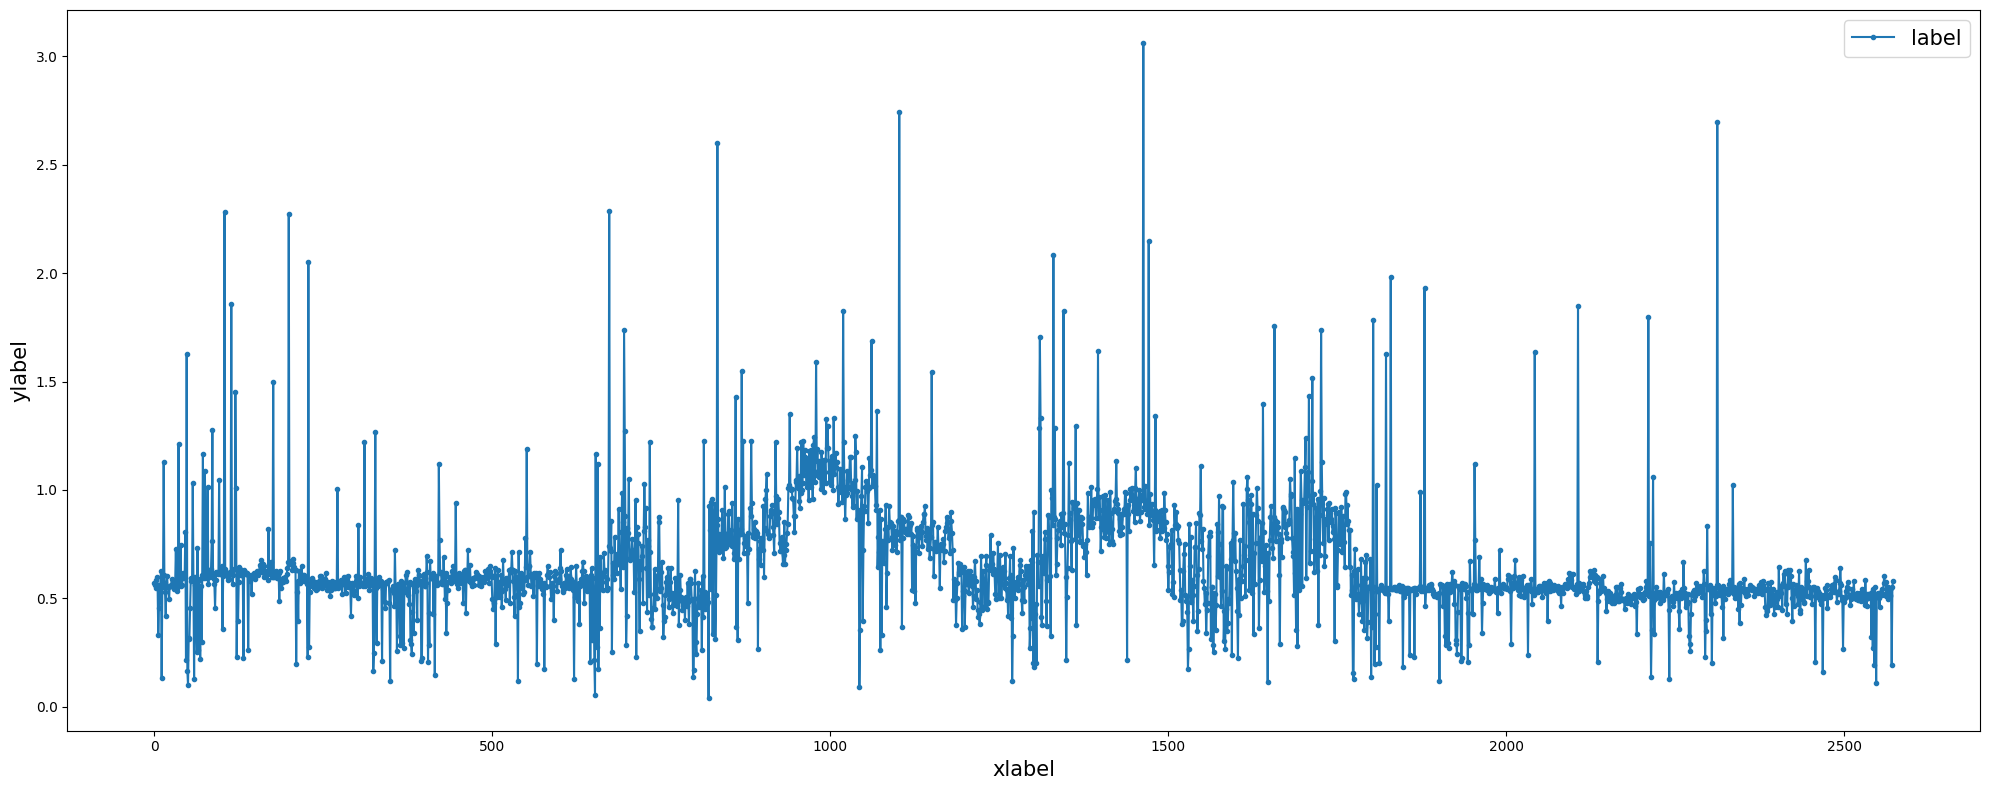

In [18]:
plot_1_data(df_aod["aod"])

In [19]:
df_aod.to_csv('df_aod.csv', index=True)

### Extract columns: time, stations, pm25_3km

In [20]:
# Get the time indices
aod_time_indices = df_aod.index
aod_time_indices

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='time', length=2573, freq=None)

In [21]:
# Get the station column
aod_station_column = df_aod.loc[:, "station"]
aod_station_column

time
2021-01-01    201
2021-01-02    201
2021-01-03    201
2021-01-04    201
2021-01-05    201
             ... 
2022-12-27    216
2022-12-28    216
2022-12-29    216
2022-12-30    216
2022-12-31    216
Name: station, Length: 2573, dtype: int64

In [22]:
# Get the pm25_3km column
aod_pm25_3km_column = df_aod.loc[:, "pm25_3km"]
aod_pm25_3km_column

time
2021-01-01    38.320000
2021-01-02    56.650002
2021-01-03    56.900002
2021-01-04    61.560001
2021-01-05    69.949997
                ...    
2022-12-27    34.439411
2022-12-28    29.838476
2022-12-29    28.450829
2022-12-30    19.854403
2022-12-31    27.658358
Name: pm25_3km, Length: 2573, dtype: float64

### Split into features and labels
* Label: pm25
* Features: other columns
    * Dynamic features
    * Static features

In [23]:
# Features with pm25_3km
aod_feats = aod_stat_feats + aod_dyn_feats
# Predict without "station" as a feature
aod_feats.remove("station")
X_aod = df_aod.loc[:, aod_feats]

# Features without pm25_3km
aod_feats.remove("pm25_3km")
X_aod_no_pm25_3km = df_aod.loc[:, aod_feats]

# Label
y_aod = df_aod.loc[:, aod_label]

In [24]:
X_aod

lat         lon          pop  road_den_1km  \
time                                                           
2021-01-01  10.783057  106.700606  20680.62695     27.462461   
2021-01-02  10.783057  106.700606  20680.62695     27.462461   
2021-01-03  10.783057  106.700606  20680.62695     27.462461   
2021-01-04  10.783057  106.700606  20680.62695     27.462461   
2021-01-05  10.783057  106.700606  20680.62695     27.462461   
...               ...         ...          ...           ...   
2022-12-27  10.780482  106.659511  57523.91406     33.629780   
2022-12-28  10.780482  106.659511  57523.91406     33.629780   
2022-12-29  10.780482  106.659511  57523.91406     33.629780   
2022-12-30  10.780482  106.659511  57523.91406     33.629780   
2022-12-31  10.780482  106.659511  57523.91406     33.629780   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2021-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi       aod  \
time                                                                  
2021-01-01  1876.639945  232011.95950    0.0  2700.122924  0.571852   
2021-01-02  1876.639945  232011.95950    0.0  2700.122924  0.561221   
2021-01-03  1876.639945  232011.95950    0.0  2700.122924  0.546221   
2021-01-04  1876.639945  232011.95950    0.0  2700.122924  0.586047   
2021-01-05  1876.639945  232011.95950    0.0  2700.122924  0.599603   
...                 ...           ...    ...          ...       ...   
2022-12-27  8099.182920   95807.40771    0.0  1879.344348  0.508564   
2022-12-28  8099.182920   95807.40771    0.0  1879.344348  0.547594   
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  0.191691   
2022-12-30  8099.182920   95807.40771    0.0  1879.344348  0.554055   
2022-12-31  8099.182920   95807.40771    0.0  1879.344348  0.580505   

                   rh      wspd        hpbl   pm25_3km        tmp  
time                                                               
2021-01-01  60.583508  3.548874  561.605774  38.320000  25.873598  
2021-01-02  60.219109  2.355864  527.248901  56.650002  25.527328  
2021-01-03  61.481564  1.896463  469.774841  56.900002  26.878422  
2021-01-04  61.013718  1.642178  615.690735  61.560001  27.771753  
2021-01-05  61.277409  2.859253  665.619263  69.949997  27.660774  
...               ...       ...         ...        ...        ...  
2022-12-27  73.973083  2.002987  457.798645  34.439411  24.136936  
2022-12-28  65.530487  2.298220  644.974548  29.838476  25.844296  
2022-12-29  67.093735  2.823764  825.517395  28.450829  25.841156  
2022-12-30  64.868401  3.893373  680.533081  19.854403  24.979719  
2022-12-31  62.377899  4.161542  799.122803  27.658358  25.364861  

[2573 rows x 19 columns]

In [25]:
X_aod_no_pm25_3km

lat         lon          pop  road_den_1km  \
time                                                           
2021-01-01  10.783057  106.700606  20680.62695     27.462461   
2021-01-02  10.783057  106.700606  20680.62695     27.462461   
2021-01-03  10.783057  106.700606  20680.62695     27.462461   
2021-01-04  10.783057  106.700606  20680.62695     27.462461   
2021-01-05  10.783057  106.700606  20680.62695     27.462461   
...               ...         ...          ...           ...   
2022-12-27  10.780482  106.659511  57523.91406     33.629780   
2022-12-28  10.780482  106.659511  57523.91406     33.629780   
2022-12-29  10.780482  106.659511  57523.91406     33.629780   
2022-12-30  10.780482  106.659511  57523.91406     33.629780   
2022-12-31  10.780482  106.659511  57523.91406     33.629780   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2021-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi       aod  \
time                                                                  
2021-01-01  1876.639945  232011.95950    0.0  2700.122924  0.571852   
2021-01-02  1876.639945  232011.95950    0.0  2700.122924  0.561221   
2021-01-03  1876.639945  232011.95950    0.0  2700.122924  0.546221   
2021-01-04  1876.639945  232011.95950    0.0  2700.122924  0.586047   
2021-01-05  1876.639945  232011.95950    0.0  2700.122924  0.599603   
...                 ...           ...    ...          ...       ...   
2022-12-27  8099.182920   95807.40771    0.0  1879.344348  0.508564   
2022-12-28  8099.182920   95807.40771    0.0  1879.344348  0.547594   
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  0.191691   
2022-12-30  8099.182920   95807.40771    0.0  1879.344348  0.554055   
2022-12-31  8099.182920   95807.40771    0.0  1879.344348  0.580505   

                   rh      wspd        hpbl        tmp  
time                                                    
2021-01-01  60.583508  3.548874  561.605774  25.873598  
2021-01-02  60.219109  2.355864  527.248901  25.527328  
2021-01-03  61.481564  1.896463  469.774841  26.878422  
2021-01-04  61.013718  1.642178  615.690735  27.771753  
2021-01-05  61.277409  2.859253  665.619263  27.660774  
...               ...       ...         ...        ...  
2022-12-27  73.973083  2.002987  457.798645  24.136936  
2022-12-28  65.530487  2.298220  644.974548  25.844296  
2022-12-29  67.093735  2.823764  825.517395  25.841156  
2022-12-30  64.868401  3.893373  680.533081  24.979719  
2022-12-31  62.377899  4.161542  799.122803  25.364861  

[2573 rows x 18 columns]

In [26]:
y_aod

pm25
time                 
2021-01-01  17.250000
2021-01-02  23.000000
2021-01-03  28.291667
2021-01-04  28.791667
2021-01-05  24.833333
...               ...
2022-12-27  39.659816
2022-12-28  44.679352
2022-12-29  30.724708
2022-12-30  33.091428
2022-12-31  28.854069

[2573 rows x 1 columns]

### Data normalization

In [27]:
# Scaled features
aod_features_scaler = MinMaxScaler()
X_aod_scaled = aod_features_scaler.fit_transform(X_aod)
X_aod_scaled = pd.DataFrame(X_aod_scaled, columns=X_aod.columns)
X_aod_scaled

lat       lon      pop  road_den_1km  prim_road_len_1km  near_dist  \
0     0.326794  0.466551  0.13589      0.599996           0.949821   0.344052   
1     0.326794  0.466551  0.13589      0.599996           0.949821   0.344052   
2     0.326794  0.466551  0.13589      0.599996           0.949821   0.344052   
3     0.326794  0.466551  0.13589      0.599996           0.949821   0.344052   
4     0.326794  0.466551  0.13589      0.599996           0.949821   0.344052   
...        ...       ...      ...           ...                ...        ...   
2568  0.306899  0.237227  1.00000      1.000000           0.323578   0.075528   
2569  0.306899  0.237227  1.00000      1.000000           0.323578   0.075528   
2570  0.306899  0.237227  1.00000      1.000000           0.323578   0.075528   
2571  0.306899  0.237227  1.00000      1.000000           0.323578   0.075528   
2572  0.306899  0.237227  1.00000      1.000000           0.323578   0.075528   

      bareland   builtup  cropland  grassland  treecover  water      ndvi  \
0      0.00000  0.199903       0.0   0.037975   1.000000    0.0  0.526821   
1      0.00000  0.199903       0.0   0.037975   1.000000    0.0  0.526821   
2      0.00000  0.199903       0.0   0.037975   1.000000    0.0  0.526821   
3      0.00000  0.199903       0.0   0.037975   1.000000    0.0  0.526821   
4      0.00000  0.199903       0.0   0.037975   1.000000    0.0  0.526821   
...        ...       ...       ...        ...        ...    ...       ...   
2568   0.62963  0.788964       0.0   0.170886   0.308772    0.0  0.085003   
2569   0.62963  0.788964       0.0   0.170886   0.308772    0.0  0.085003   
2570   0.62963  0.788964       0.0   0.170886   0.308772    0.0  0.085003   
2571   0.62963  0.788964       0.0   0.170886   0.308772    0.0  0.085003   
2572   0.62963  0.788964       0.0   0.170886   0.308772    0.0  0.085003   

           aod        rh      wspd      hpbl  pm25_3km       tmp  
0     0.175925  0.265635  0.485894  0.382113  0.401465  0.292466  
1     0.172408  0.257407  0.251463  0.355779  0.625275  0.259187  
2     0.167446  0.285912  0.161190  0.311726  0.628327  0.389039  
3     0.180620  0.275348  0.111222  0.423568  0.685226  0.474896  
4     0.185104  0.281302  0.350381  0.461837  0.787668  0.464230  
...        ...       ...       ...       ...       ...       ...  
2568  0.154990  0.567964  0.182122  0.302546  0.354083  0.125557  
2569  0.167900  0.377335  0.240136  0.446013  0.297906  0.289650  
2570  0.050172  0.412632  0.343407  0.584396  0.280963  0.289348  
2571  0.170038  0.362385  0.553589  0.473268  0.176000  0.206556  
2572  0.178787  0.306151  0.606285  0.564165  0.271286  0.243572  

[2573 rows x 19 columns]

In [28]:
# Scaled features without pm25_3km
aod_features_no_pm25_3km_scaler = MinMaxScaler()
X_aod_no_pm25_3km_scaled = aod_features_no_pm25_3km_scaler.fit_transform(X_aod_no_pm25_3km)
X_aod_no_pm25_3km_scaled = pd.DataFrame(X_aod_no_pm25_3km_scaled, columns=X_aod_no_pm25_3km.columns)
X_aod_no_pm25_3km_scaled

lat       lon      pop  road_den_1km  prim_road_len_1km  near_dist  \
0     0.326794  0.466551  0.13589      0.599996           0.949821   0.344052   
1     0.326794  0.466551  0.13589      0.599996           0.949821   0.344052   
2     0.326794  0.466551  0.13589      0.599996           0.949821   0.344052   
3     0.326794  0.466551  0.13589      0.599996           0.949821   0.344052   
4     0.326794  0.466551  0.13589      0.599996           0.949821   0.344052   
...        ...       ...      ...           ...                ...        ...   
2568  0.306899  0.237227  1.00000      1.000000           0.323578   0.075528   
2569  0.306899  0.237227  1.00000      1.000000           0.323578   0.075528   
2570  0.306899  0.237227  1.00000      1.000000           0.323578   0.075528   
2571  0.306899  0.237227  1.00000      1.000000           0.323578   0.075528   
2572  0.306899  0.237227  1.00000      1.000000           0.323578   0.075528   

      bareland   builtup  cropland  grassland  treecover  water      ndvi  \
0      0.00000  0.199903       0.0   0.037975   1.000000    0.0  0.526821   
1      0.00000  0.199903       0.0   0.037975   1.000000    0.0  0.526821   
2      0.00000  0.199903       0.0   0.037975   1.000000    0.0  0.526821   
3      0.00000  0.199903       0.0   0.037975   1.000000    0.0  0.526821   
4      0.00000  0.199903       0.0   0.037975   1.000000    0.0  0.526821   
...        ...       ...       ...        ...        ...    ...       ...   
2568   0.62963  0.788964       0.0   0.170886   0.308772    0.0  0.085003   
2569   0.62963  0.788964       0.0   0.170886   0.308772    0.0  0.085003   
2570   0.62963  0.788964       0.0   0.170886   0.308772    0.0  0.085003   
2571   0.62963  0.788964       0.0   0.170886   0.308772    0.0  0.085003   
2572   0.62963  0.788964       0.0   0.170886   0.308772    0.0  0.085003   

           aod        rh      wspd      hpbl       tmp  
0     0.175925  0.265635  0.485894  0.382113  0.292466  
1     0.172408  0.257407  0.251463  0.355779  0.259187  
2     0.167446  0.285912  0.161190  0.311726  0.389039  
3     0.180620  0.275348  0.111222  0.423568  0.474896  
4     0.185104  0.281302  0.350381  0.461837  0.464230  
...        ...       ...       ...       ...       ...  
2568  0.154990  0.567964  0.182122  0.302546  0.125557  
2569  0.167900  0.377335  0.240136  0.446013  0.289650  
2570  0.050172  0.412632  0.343407  0.584396  0.289348  
2571  0.170038  0.362385  0.553589  0.473268  0.206556  
2572  0.178787  0.306151  0.606285  0.564165  0.243572  

[2573 rows x 18 columns]

In [29]:
# Scaled label
aod_label_scaler = MinMaxScaler(feature_range=(0, 1))
y_aod_scaled = aod_label_scaler.fit_transform(y_aod)
y_aod_scaled = pd.DataFrame(y_aod_scaled, columns=y_aod.columns)
y_aod_scaled

pm25
0     0.147032
1     0.216931
2     0.281258
3     0.287336
4     0.239218
...        ...
2568  0.419453
2569  0.480472
2570  0.310835
2571  0.339606
2572  0.288095

[2573 rows x 1 columns]

## Dimensionality Reduction Comparation

To compare the effect of each method, we will do the following things:
* Use the pm25 as the label
* Use other columns as the input features
* Reduce the dimension of input data using above methods
* Pass the processed input data to a model (e.g. LSTM, ...)

### Evaluation board

In [30]:
evaluation_board = {'with_pm25_3km': [], 'dim_reduction_method': [], 'dim_after_reduction': [], 'prediction':[], 'mae': [], 'mse': [], 'r2': []}

### Range of dimension

In [31]:
RANGE_OF_DIMENSION = range(conf["reduction"]["min_number_of_features"], X_aod_scaled.shape[1])
#RANGE_OF_DIMENSION = range(2, 5)
for n in RANGE_OF_DIMENSION:
  print(n, end=' ')

print()

RANGE_OF_DIMENSION_NO_PM25_3KM = range(conf["reduction"]["min_number_of_features"], X_aod_no_pm25_3km_scaled.shape[1])
#RANGE_OF_DIMENSION_NO_PM25_3KM = range(2, 5)
for n in RANGE_OF_DIMENSION_NO_PM25_3KM:
  print(n, end=' ')

10 11 12 13 14 15 16 17 18 
10 11 12 13 14 15 16 17 

### Prediction without reduction

#### With pm25_3km

I0000 00:00:1755337842.768048  279243 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:39:00.0, compute capability: 8.0


Model: "aod_LSTMPrediction_no_dim_reduction"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 64),      │     21,760 │ input_layer[0][0] │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 1, 64)     │          0 │ lstm[0][0]        │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 1, 64)     │     33,024 │ repeat_vector[0]… │
│                     │                   │            │ lstm[0][1],       │
│                     │                   │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1, 64)     │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 1, 32)     │      2,080 │ dropout[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,897 (222.25 KB)

 Trainable params: 56,897 (222.25 KB)

 Non-trainable params: 0 (0.00 B)

None


I0000 00:00:1755337852.525399  279339 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


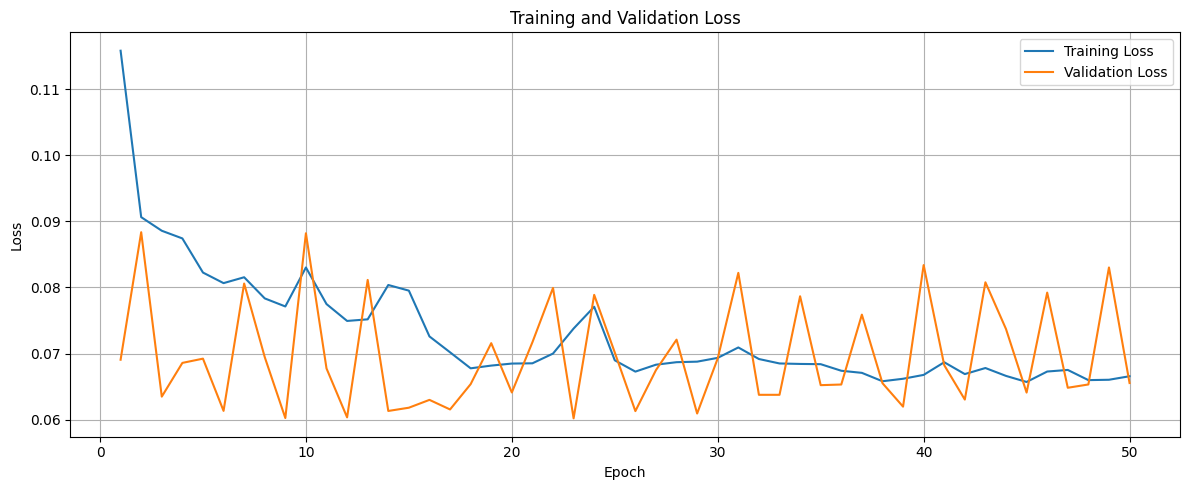

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


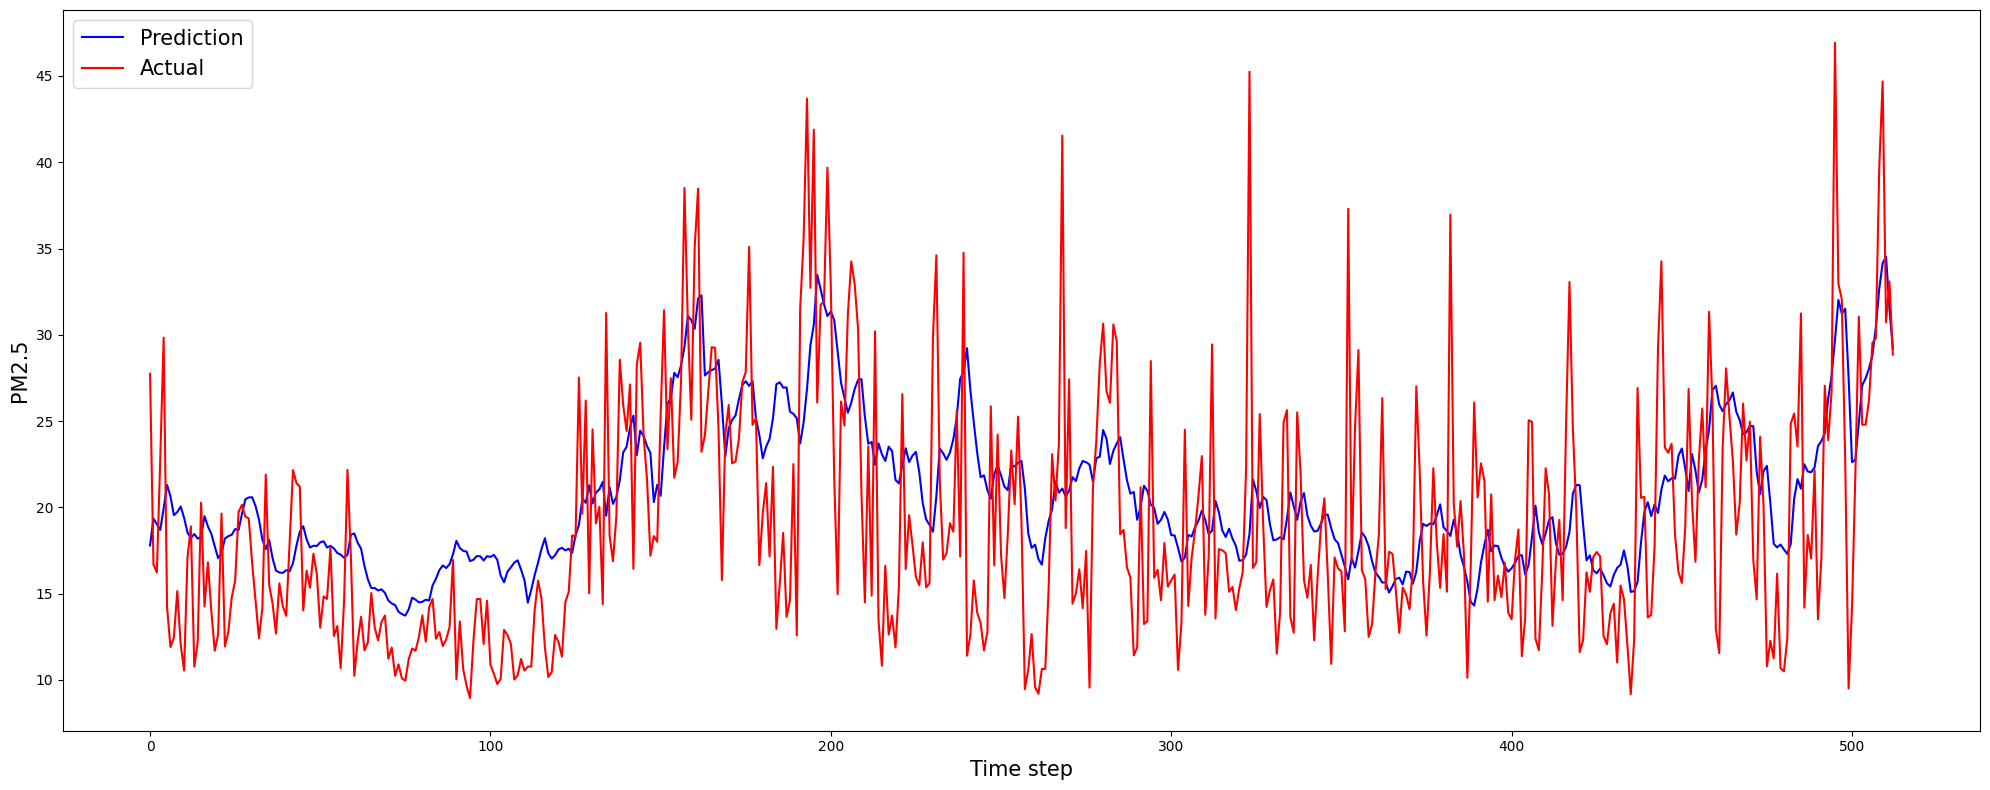

with_pm25_3km dim_reduction_method dim_after_reduction prediction       mae  \
0           Yes                 None                 N/A       LSTM  4.750573   

         mse        r2  
0  36.145157 -1.044288

In [32]:
# Prediction
lstmpred = LSTMPrediction(X_aod_scaled, y_aod_scaled,
                            aod_label_scaler,
                            val_percentage=0.2, test_percentage=0.2,
                            n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                            epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                            model_name=f"aod_{LSTMPrediction.class_name}_no_dim_reduction",
                            verbose=0)
lstmpred.get_model_info()
all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae, all_days_mse, avg_mse, all_days_r2, avg_r2 = lstmpred.execute()


# Visualize the prediction
plot_prediction(all_days_inv_y_pred, all_days_inv_y_test, conf["prediction"]["n_future"])

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["None"]
evaluation_board['dim_after_reduction'] += ["N/A"]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [avg_mae]
evaluation_board['mse'] += [avg_mse]
evaluation_board['r2'] += [avg_r2]
evaluation_board['with_pm25_3km'] += ["Yes"]
pd.DataFrame(evaluation_board)

#### No pm25_3km

Model: "aod_LSTMPrediction_no_dim_reduction_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 64),      │     21,504 │ input_layer_1[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 1, 64)     │          0 │ lstm_2[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 1, 64)     │     33,024 │ repeat_vector_1[… │
│                     │                   │            │ lstm_2[0][1],     │
│                     │                   │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1, 64)     │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 1, 32)     │      2,080 │ dropout_1[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,641 (221.25 KB)

 Trainable params: 56,641 (221.25 KB)

 Non-trainable params: 0 (0.00 B)

None


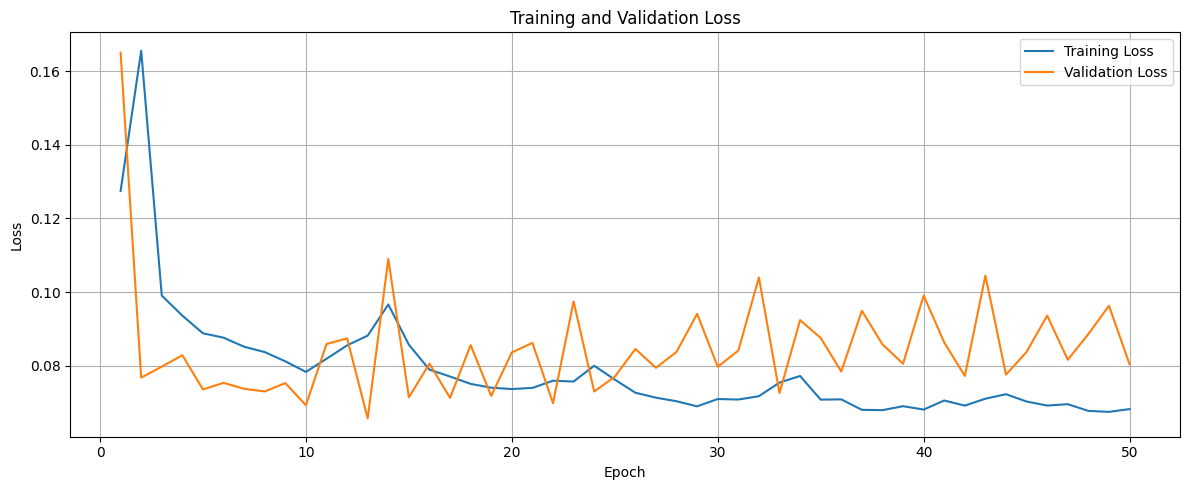

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


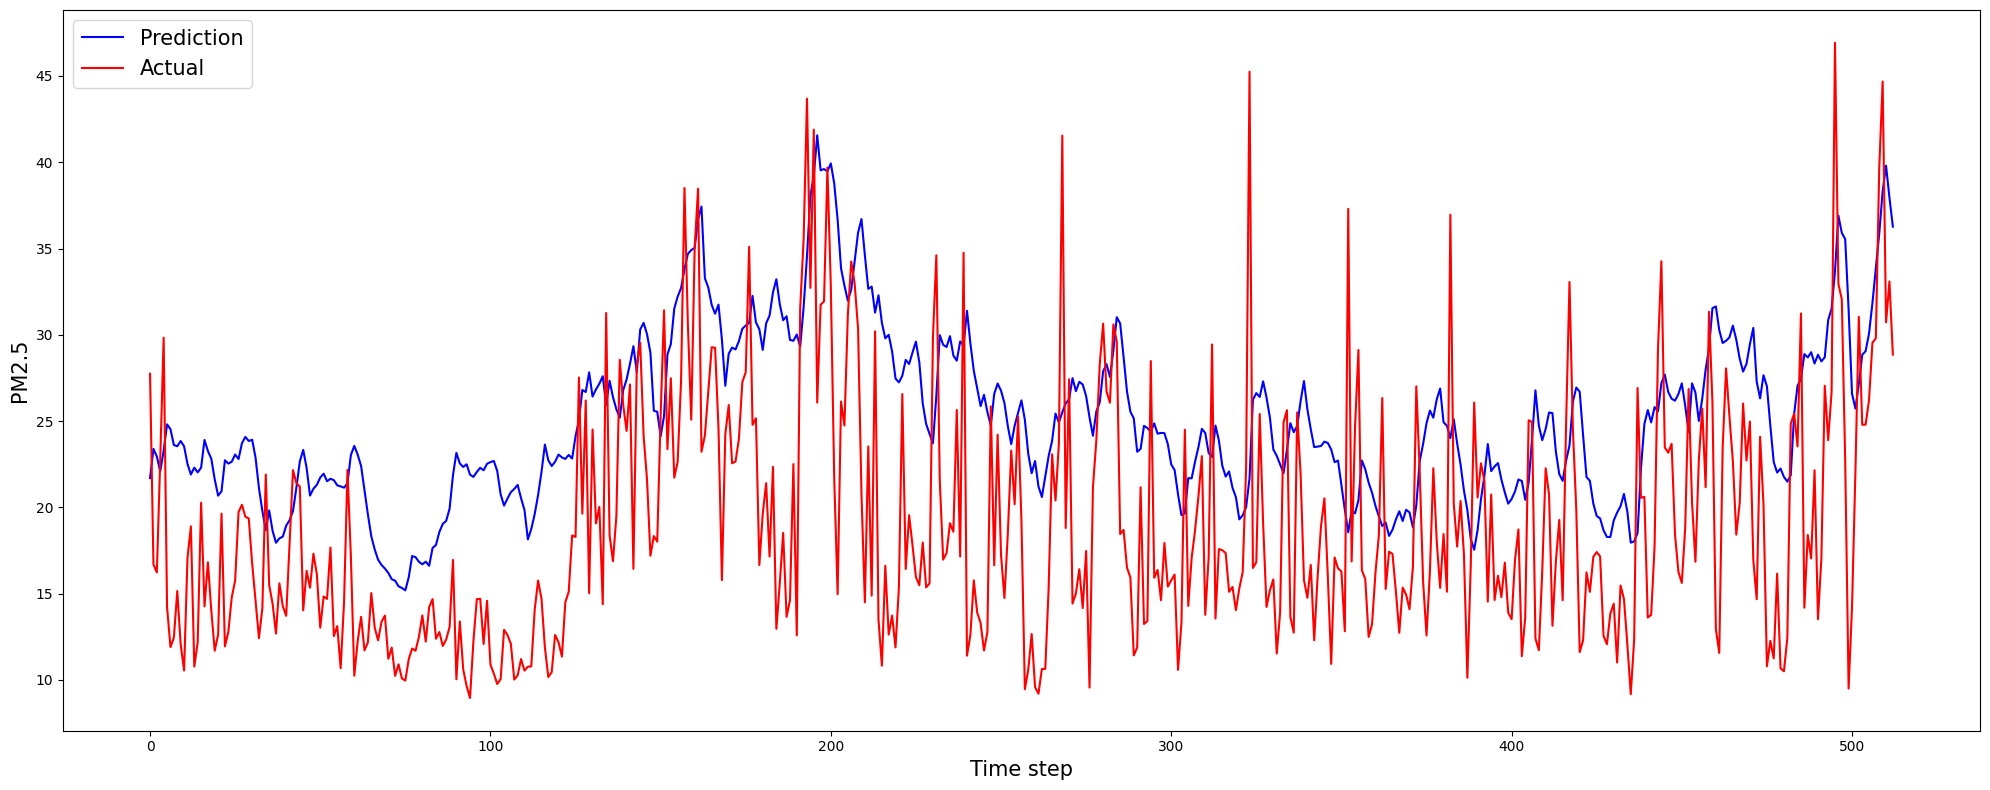

with_pm25_3km dim_reduction_method dim_after_reduction prediction       mae  \
0           Yes                 None                 N/A       LSTM  4.750573   
1            No                 None                 N/A       LSTM  7.395319   

         mse        r2  
0  36.145157 -1.044288  
1  74.086617 -2.062693

In [33]:
# Prediction
lstmpred = LSTMPrediction(X_aod_no_pm25_3km_scaled, y_aod_scaled,
                            aod_label_scaler,
                            val_percentage=0.2, test_percentage=0.2,
                            n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                            epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                            model_name=f"aod_{LSTMPrediction.class_name}_no_dim_reduction_no_pm25_3km",
                            verbose=0)
lstmpred.get_model_info()
all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae, all_days_mse, avg_mse, all_days_r2, avg_r2 = lstmpred.execute()

# Visualize the prediction
plot_prediction(all_days_inv_y_pred, all_days_inv_y_test, conf["prediction"]["n_future"])

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["None"]
evaluation_board['dim_after_reduction'] += ["N/A"]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [avg_mae]
evaluation_board['mse'] += [avg_mse]
evaluation_board['r2'] += [avg_r2]
evaluation_board['with_pm25_3km'] += ["No"]
pd.DataFrame(evaluation_board)

### Prediction + LSTM-Seq2Seq

#### Doing the loop

Model: "aod_LSTMSeq2SeqReduction_10_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 7, 100)    │     48,000 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 50),      │     30,200 │ lstm_4[0][0]      │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 10)        │        510 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 7, 10)     │          0 │ dense_4[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 7, 50)     │     12,200 │ repeat_vector_2[… │
│                     │                   │            │ lstm_5[0][1],     │
│                     │                   │            │ lstm_5[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 7, 100)    │     60,400 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 7, 19)     │      1,919 │ lstm_7[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 459,689 (1.75 MB)

 Trainable params: 153,229 (598.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 306,460 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_10_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,710 (307.46 KB)

 Trainable params: 78,710 (307.46 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_10_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 7, 11)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ [(None, 64),      │     19,456 │ input_layer_4[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 1, 64)     │          0 │ lstm_8[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 1, 64)     │     33,024 │ repeat_vector_3[… │
│                     │                   │            │ lstm_8[0][1],     │
│                     │                   │            │ lstm_8[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1, 64)     │          0 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 1, 32)     │      2,080 │ dropout_2[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,593 (213.25 KB)

 Trainable params: 54,593 (213.25 KB)

 Non-trainable params: 0 (0.00 B)

None


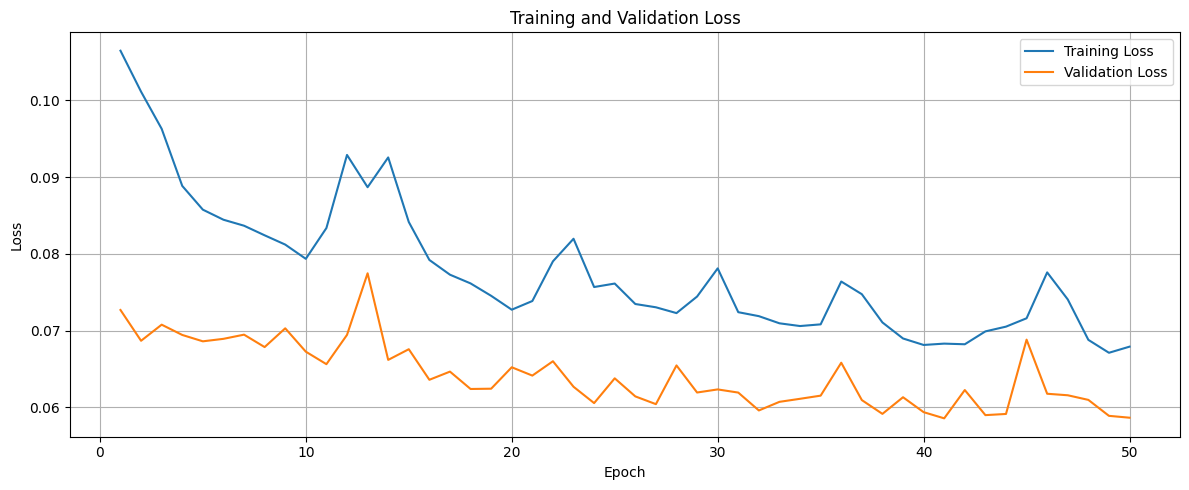

Model: "aod_LSTMSeq2SeqReduction_11_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 7, 100)    │     48,000 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_10[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 11)        │        561 │ lstm_11[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 7, 11)     │          0 │ dense_8[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 7, 50)     │     12,400 │ repeat_vector_4[… │
│                     │                   │            │ lstm_11[0][1],    │
│                     │                   │            │ lstm_11[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_12[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 7, 19)     │      1,919 │ lstm_13[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 460,442 (1.76 MB)

 Trainable params: 153,480 (599.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 306,962 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_11_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 11)             │           561 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,761 (307.66 KB)

 Trainable params: 78,761 (307.66 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_11_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 7, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ [(None, 64),      │     19,712 │ input_layer_7[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_5     │ (None, 1, 64)     │          0 │ lstm_14[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_5[… │
│                     │                   │            │ lstm_14[0][1],    │
│                     │                   │            │ lstm_14[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1, 64)     │          0 │ lstm_15[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 1, 32)     │      2,080 │ dropout_3[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,849 (214.25 KB)

 Trainable params: 54,849 (214.25 KB)

 Non-trainable params: 0 (0.00 B)

None


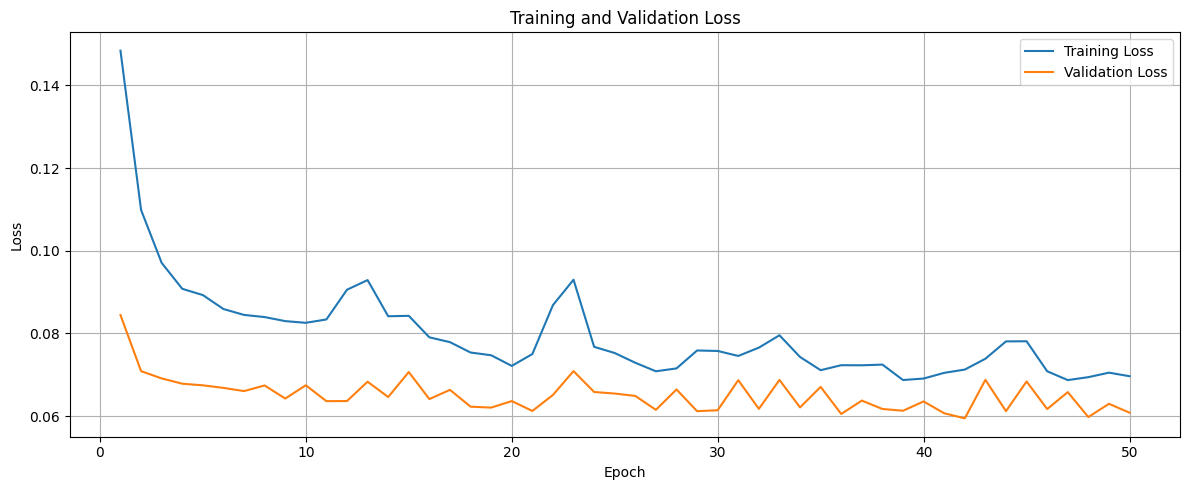

Model: "aod_LSTMSeq2SeqReduction_12_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 7, 100)    │     48,000 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_16[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 12)        │        612 │ lstm_17[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_6     │ (None, 7, 12)     │          0 │ dense_12[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 7, 50)     │     12,600 │ repeat_vector_6[… │
│                     │                   │            │ lstm_17[0][1],    │
│                     │                   │            │ lstm_17[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_18[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_10 │ (None, 7, 19)     │      1,919 │ lstm_19[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,195 (1.76 MB)

 Trainable params: 153,731 (600.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 307,464 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_12_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,812 (307.86 KB)

 Trainable params: 78,812 (307.86 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_12_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 7, 13)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ [(None, 64),      │     19,968 │ input_layer_10[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_7     │ (None, 1, 64)     │          0 │ lstm_20[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_7[… │
│                     │                   │            │ lstm_20[0][1],    │
│                     │                   │            │ lstm_20[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1, 64)     │          0 │ lstm_21[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_11 │ (None, 1, 32)     │      2,080 │ dropout_4[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,105 (215.25 KB)

 Trainable params: 55,105 (215.25 KB)

 Non-trainable params: 0 (0.00 B)

None


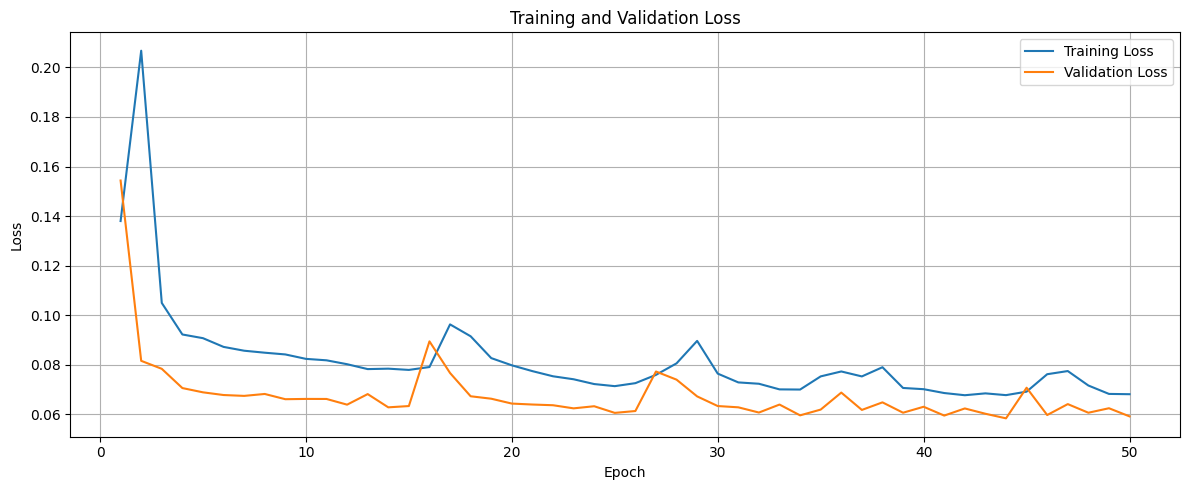

Model: "aod_LSTMSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_22 (LSTM)      │ (None, 7, 100)    │     48,000 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_23 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_22[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 13)        │        663 │ lstm_23[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_8     │ (None, 7, 13)     │          0 │ dense_16[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_24 (LSTM)      │ (None, 7, 50)     │     12,800 │ repeat_vector_8[… │
│                     │                   │            │ lstm_23[0][1],    │
│                     │                   │            │ lstm_23[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_24[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_13 │ (None, 7, 19)     │      1,919 │ lstm_25[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,948 (1.76 MB)

 Trainable params: 153,982 (601.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 307,966 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_13_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,863 (308.06 KB)

 Trainable params: 78,863 (308.06 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_26 (LSTM)      │ [(None, 64),      │     20,224 │ input_layer_13[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_9     │ (None, 1, 64)     │          0 │ lstm_26[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_27 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_9[… │
│                     │                   │            │ lstm_26[0][1],    │
│                     │                   │            │ lstm_26[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1, 64)     │          0 │ lstm_27[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_14 │ (None, 1, 32)     │      2,080 │ dropout_5[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_15 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,361 (216.25 KB)

 Trainable params: 55,361 (216.25 KB)

 Non-trainable params: 0 (0.00 B)

None


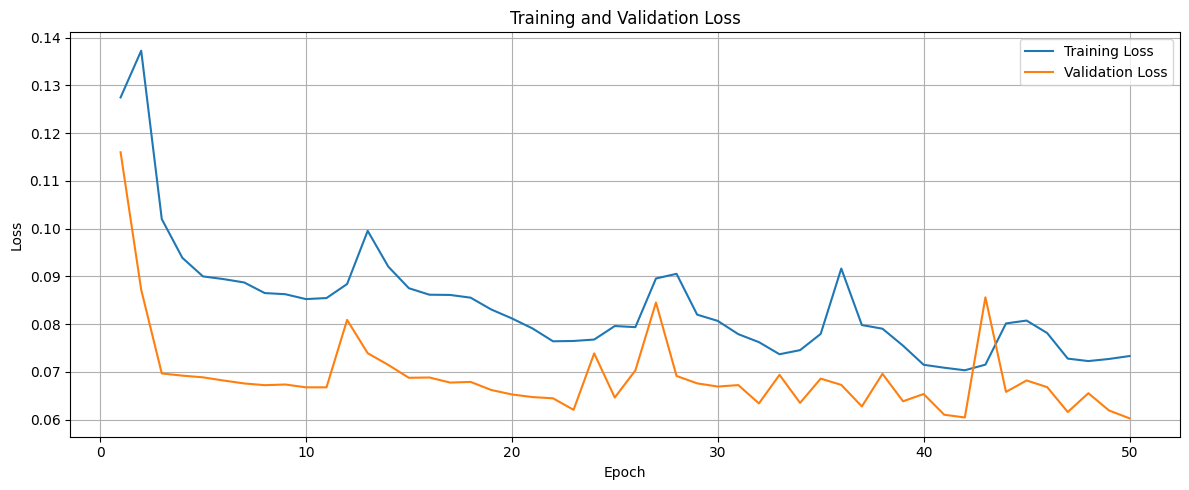

Model: "aod_LSTMSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_28 (LSTM)      │ (None, 7, 100)    │     48,000 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_29 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_28[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 14)        │        714 │ lstm_29[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_10    │ (None, 7, 14)     │          0 │ dense_20[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_30 (LSTM)      │ (None, 7, 50)     │     13,000 │ repeat_vector_10… │
│                     │                   │            │ lstm_29[0][1],    │
│                     │                   │            │ lstm_29[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_31 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_30[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_16 │ (None, 7, 19)     │      1,919 │ lstm_31[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 462,701 (1.77 MB)

 Trainable params: 154,233 (602.47 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,468 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,914 (308.26 KB)

 Trainable params: 78,914 (308.26 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_32 (LSTM)      │ [(None, 64),      │     20,480 │ input_layer_16[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_11    │ (None, 1, 64)     │          0 │ lstm_32[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_33 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_11… │
│                     │                   │            │ lstm_32[0][1],    │
│                     │                   │            │ lstm_32[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 1, 64)     │          0 │ lstm_33[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_17 │ (None, 1, 32)     │      2,080 │ dropout_6[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_18 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,617 (217.25 KB)

 Trainable params: 55,617 (217.25 KB)

 Non-trainable params: 0 (0.00 B)

None


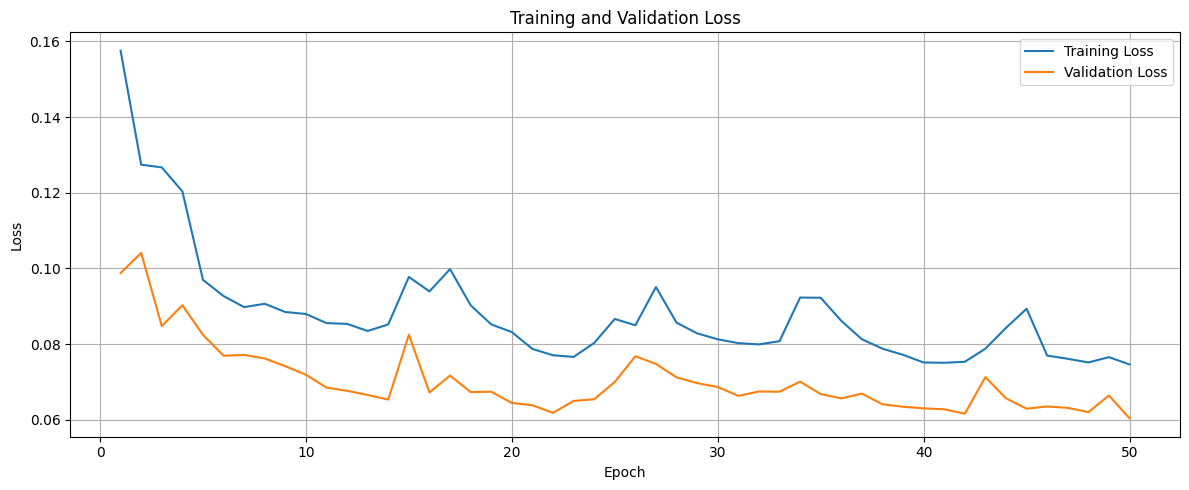

Model: "aod_LSTMSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_34 (LSTM)      │ (None, 7, 100)    │     48,000 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_35 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_34[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 15)        │        765 │ lstm_35[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_12    │ (None, 7, 15)     │          0 │ dense_24[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_36 (LSTM)      │ (None, 7, 50)     │     13,200 │ repeat_vector_12… │
│                     │                   │            │ lstm_35[0][1],    │
│                     │                   │            │ lstm_35[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_37 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_36[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_19 │ (None, 7, 19)     │      1,919 │ lstm_37[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 463,454 (1.77 MB)

 Trainable params: 154,484 (603.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,970 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,965 (308.46 KB)

 Trainable params: 78,965 (308.46 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 7, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_38 (LSTM)      │ [(None, 64),      │     20,736 │ input_layer_19[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_13    │ (None, 1, 64)     │          0 │ lstm_38[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_39 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_13… │
│                     │                   │            │ lstm_38[0][1],    │
│                     │                   │            │ lstm_38[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 1, 64)     │          0 │ lstm_39[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_20 │ (None, 1, 32)     │      2,080 │ dropout_7[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_21 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,873 (218.25 KB)

 Trainable params: 55,873 (218.25 KB)

 Non-trainable params: 0 (0.00 B)

None


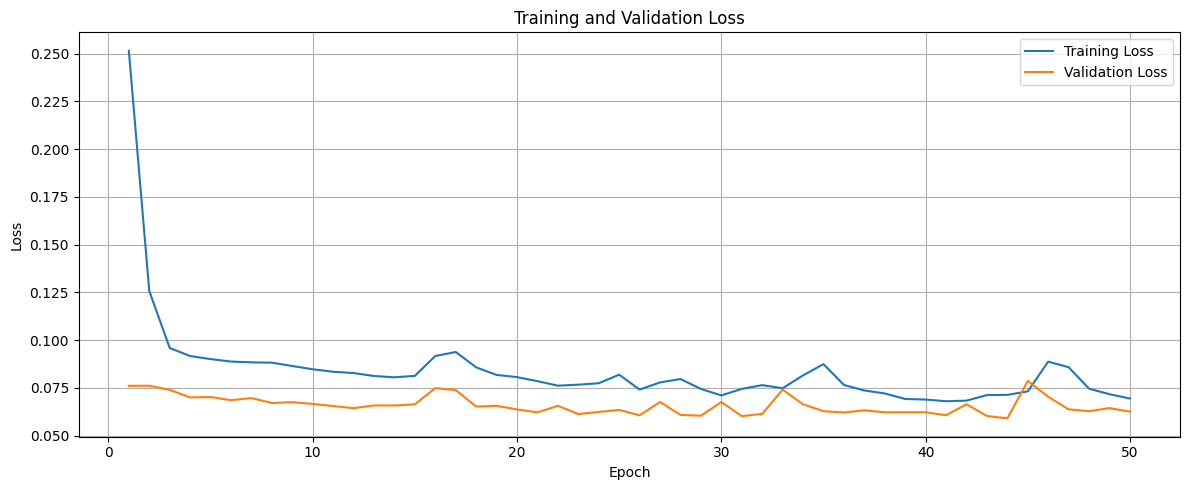

Model: "aod_LSTMSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_40 (LSTM)      │ (None, 7, 100)    │     48,000 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_41 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_40[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 16)        │        816 │ lstm_41[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_14    │ (None, 7, 16)     │          0 │ dense_28[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_42 (LSTM)      │ (None, 7, 50)     │     13,400 │ repeat_vector_14… │
│                     │                   │            │ lstm_41[0][1],    │
│                     │                   │            │ lstm_41[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_43 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_42[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_22 │ (None, 7, 19)     │      1,919 │ lstm_43[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 464,207 (1.77 MB)

 Trainable params: 154,735 (604.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 309,472 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,016 (308.66 KB)

 Trainable params: 79,016 (308.66 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_44 (LSTM)      │ [(None, 64),      │     20,992 │ input_layer_22[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_15    │ (None, 1, 64)     │          0 │ lstm_44[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_45 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_15… │
│                     │                   │            │ lstm_44[0][1],    │
│                     │                   │            │ lstm_44[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 1, 64)     │          0 │ lstm_45[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_23 │ (None, 1, 32)     │      2,080 │ dropout_8[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_24 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,129 (219.25 KB)

 Trainable params: 56,129 (219.25 KB)

 Non-trainable params: 0 (0.00 B)

None


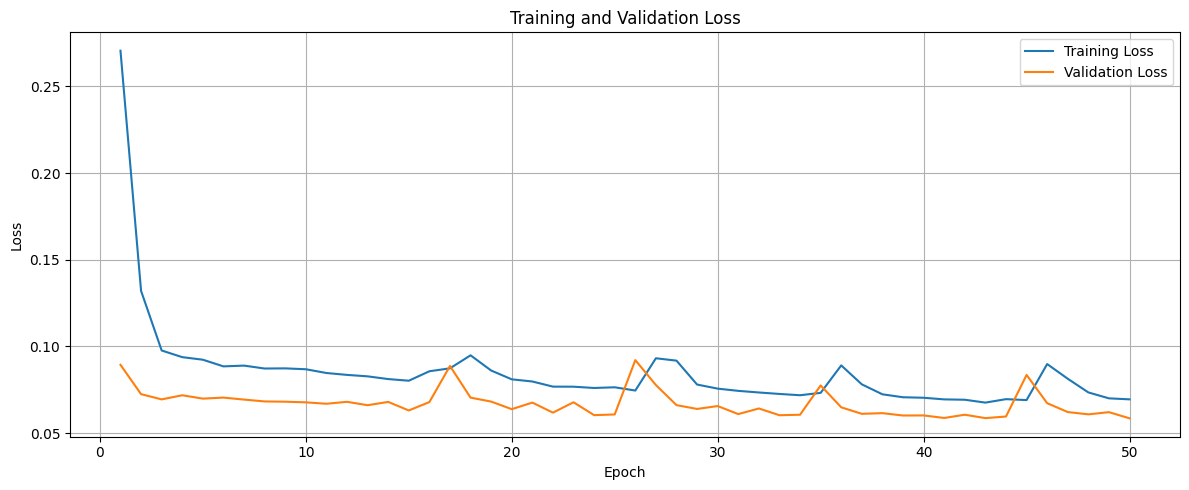

Model: "aod_LSTMSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_46 (LSTM)      │ (None, 7, 100)    │     48,000 │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_47 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_46[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 17)        │        867 │ lstm_47[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_16    │ (None, 7, 17)     │          0 │ dense_32[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_48 (LSTM)      │ (None, 7, 50)     │     13,600 │ repeat_vector_16… │
│                     │                   │            │ lstm_47[0][1],    │
│                     │                   │            │ lstm_47[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_49 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_48[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_25 │ (None, 7, 19)     │      1,919 │ lstm_49[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 464,960 (1.77 MB)

 Trainable params: 154,986 (605.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 309,974 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,067 (308.86 KB)

 Trainable params: 79,067 (308.86 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_50 (LSTM)      │ [(None, 64),      │     21,248 │ input_layer_25[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_17    │ (None, 1, 64)     │          0 │ lstm_50[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_51 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_17… │
│                     │                   │            │ lstm_50[0][1],    │
│                     │                   │            │ lstm_50[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 1, 64)     │          0 │ lstm_51[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_26 │ (None, 1, 32)     │      2,080 │ dropout_9[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_27 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,385 (220.25 KB)

 Trainable params: 56,385 (220.25 KB)

 Non-trainable params: 0 (0.00 B)

None


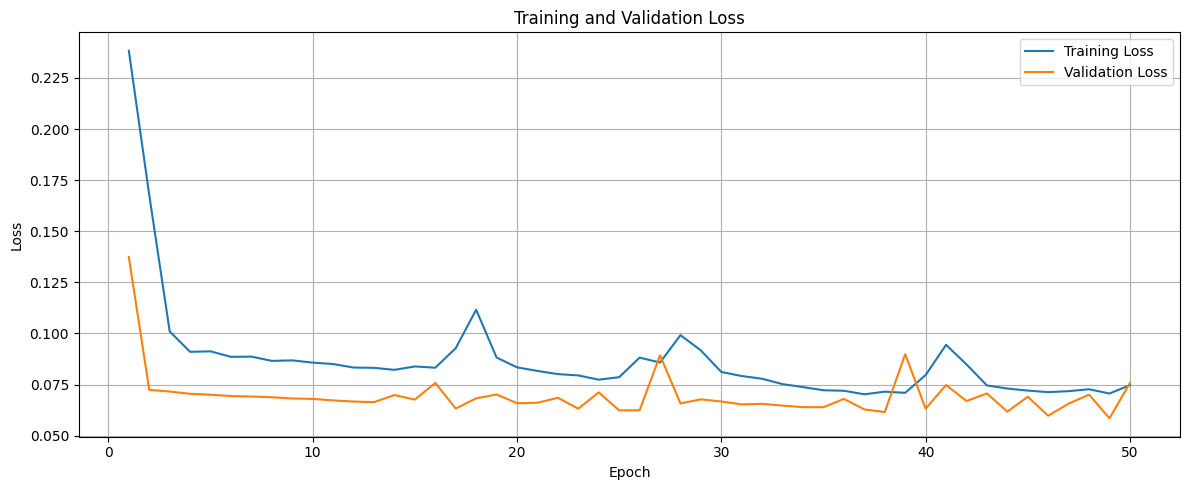

Model: "aod_LSTMSeq2SeqReduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_52 (LSTM)      │ (None, 7, 100)    │     48,000 │ input_layer_26[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_53 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_52[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 18)        │        918 │ lstm_53[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_18    │ (None, 7, 18)     │          0 │ dense_36[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_54 (LSTM)      │ (None, 7, 50)     │     13,800 │ repeat_vector_18… │
│                     │                   │            │ lstm_53[0][1],    │
│                     │                   │            │ lstm_53[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_55 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_54[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_28 │ (None, 7, 19)     │      1,919 │ lstm_55[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 465,713 (1.78 MB)

 Trainable params: 155,237 (606.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 310,476 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_18_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,118 (309.05 KB)

 Trainable params: 79,118 (309.05 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_56 (LSTM)      │ [(None, 64),      │     21,504 │ input_layer_28[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_19    │ (None, 1, 64)     │          0 │ lstm_56[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_57 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_19… │
│                     │                   │            │ lstm_56[0][1],    │
│                     │                   │            │ lstm_56[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 1, 64)     │          0 │ lstm_57[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_29 │ (None, 1, 32)     │      2,080 │ dropout_10[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_30 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,641 (221.25 KB)

 Trainable params: 56,641 (221.25 KB)

 Non-trainable params: 0 (0.00 B)

None


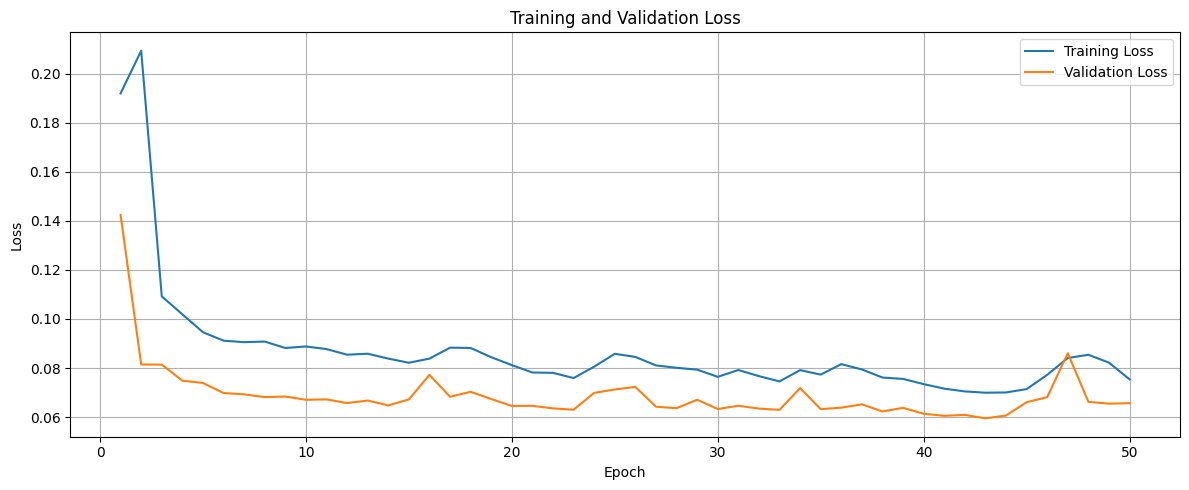

N = 10 - mae = 4.342869093766202, mse = 36.71600115016163, r2 = -2.4951019950220616
N = 11 - mae = 4.473220233024595, mse = 35.2865134309003, r2 = -2.675954740375477
N = 12 - mae = 4.458839106535397, mse = 35.33856110489922, r2 = -2.7302349683254103
N = 13 - mae = 4.56468985902219, mse = 40.37296337723025, r2 = -6.989356853523534
N = 14 - mae = 4.655696577174637, mse = 42.85738485297031, r2 = -9.868119976518544
N = 15 - mae = 4.7930238131324305, mse = 36.37269270866858, r2 = -4.541818833295481
N = 16 - mae = 4.40827549238027, mse = 37.165642518220345, r2 = -3.2774424373808806
N = 17 - mae = 5.520073673679925, mse = 42.646300235829614, r2 = -3.1809751583960875
N = 18 - mae = 4.856415604053187, mse = 38.015233538644566, r2 = -8.149209339626822


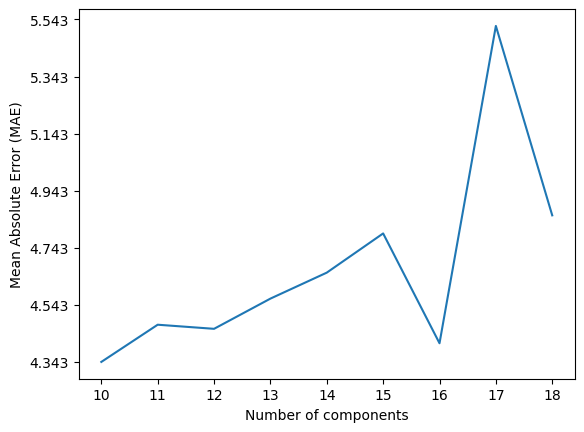

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


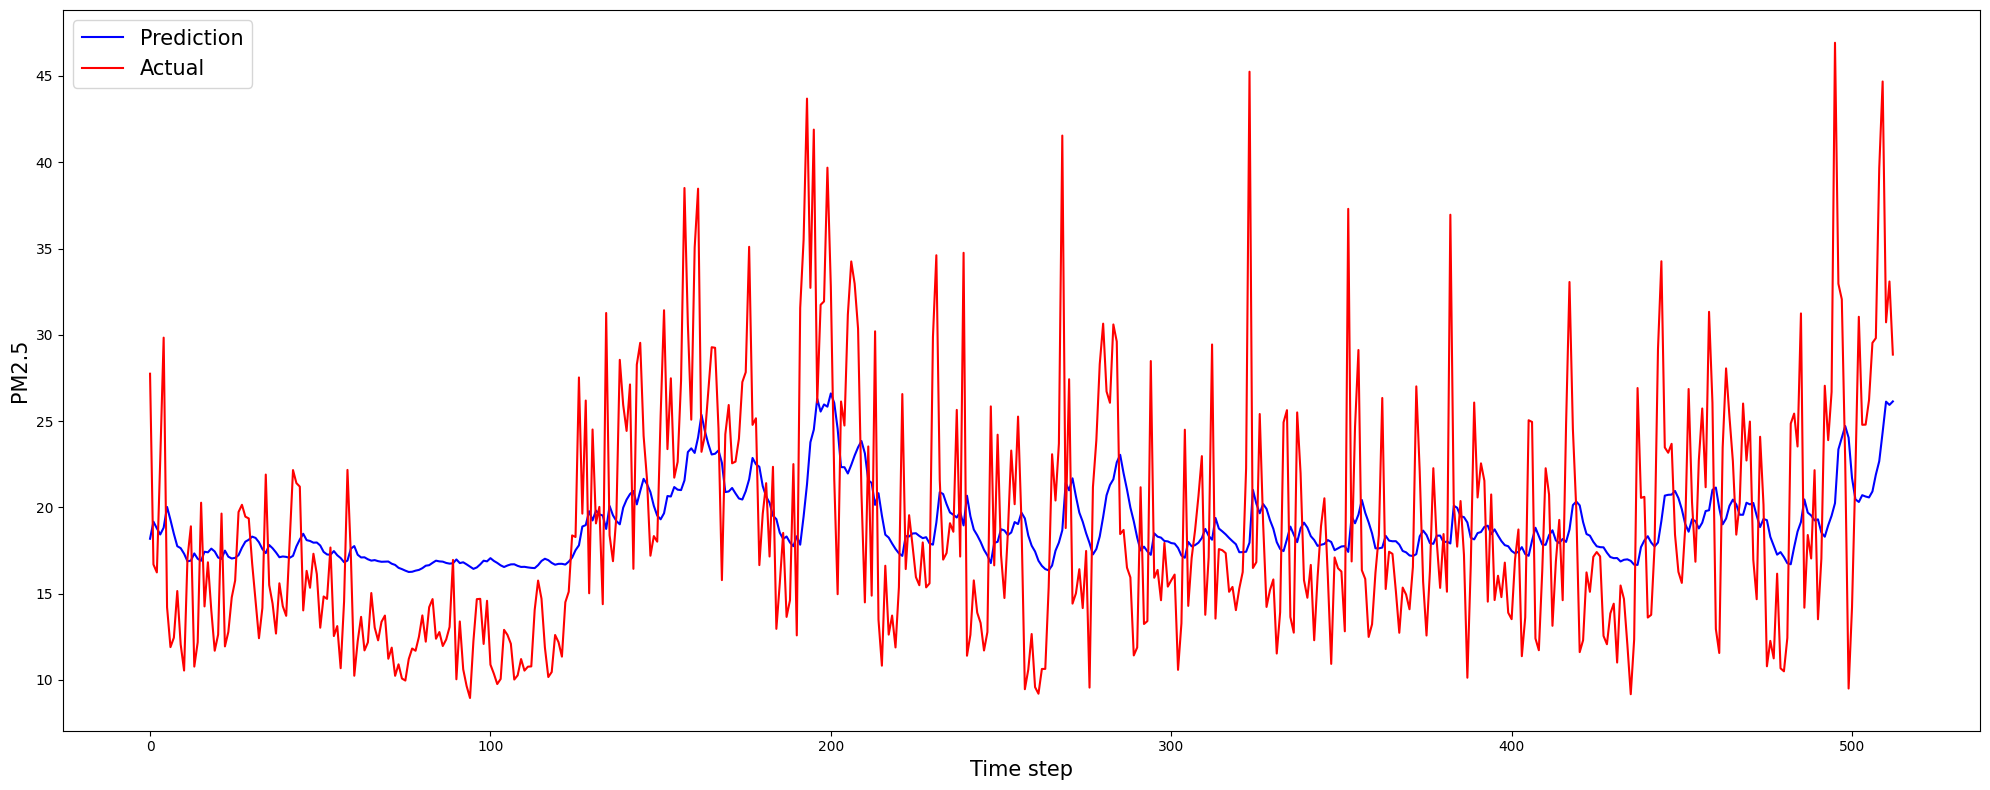

with_pm25_3km dim_reduction_method dim_after_reduction prediction       mae  \
0           Yes                 None                 N/A       LSTM  4.750573   
1            No                 None                 N/A       LSTM  7.395319   
2           Yes         LSTM-Seq2Seq                  18       LSTM  4.856416   

         mse        r2  
0  36.145157 -1.044288  
1  74.086617 -2.062693  
2  38.015234 -8.149209

In [34]:
loopresults = generate_loopresults(RANGE_OF_DIMENSION, LSTMSeq2SeqReduction, LSTMPrediction, X_aod_scaled, y_aod_scaled, aod_label_scaler)
best_mae, best_mse, best_r2, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = choose_the_best(loopresults)

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['mse'] += [best_mse]
evaluation_board['r2'] += [best_r2]
evaluation_board['with_pm25_3km'] += ["Yes"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [35]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_lstms2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_lstms2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_lstms2s_reduced_2021_2022.csv"))
df_lstms2s_reduced

aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2021-01-01      -0.729718      -0.241858       0.613655       0.007537   
2021-01-02      -0.729718      -0.241858       0.613655       0.007537   
2021-01-03      -0.730761      -0.241929       0.612227       0.009248   
2021-01-04      -0.732145      -0.242688       0.609626       0.011034   
2021-01-05      -0.735746      -0.244594       0.607740       0.013466   
...                   ...            ...            ...            ...   
2022-12-27      -0.306269       0.230564       0.116719      -0.358524   
2022-12-28      -0.306439       0.231055       0.117911      -0.357428   
2022-12-29      -0.305298       0.228601       0.121290      -0.353251   
2022-12-30      -0.307209       0.225214       0.128309      -0.348021   
2022-12-31      -0.310528       0.222689       0.133317      -0.346703   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2021-01-01       0.319410       0.088129       0.061859      -0.983065   
2021-01-02       0.319410       0.088129       0.061859      -0.983065   
2021-01-03       0.320832       0.086533       0.063834      -0.984522   
2021-01-04       0.323097       0.083915       0.067881      -0.988055   
2021-01-05       0.325667       0.081076       0.073118      -0.994497   
...                   ...            ...            ...            ...   
2022-12-27       0.050067       0.092340      -0.082700      -0.676171   
2022-12-28       0.049430       0.093447      -0.085549      -0.675133   
2022-12-29       0.050242       0.097135      -0.091298      -0.668829   
2022-12-30       0.051788       0.100365      -0.095779      -0.663968   
2022-12-31       0.053992       0.101858      -0.097335      -0.666291   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2021-01-01      -0.849691        0.584670       -0.045826        0.350564   
2021-01-02      -0.849691        0.584670       -0.045826        0.350564   
2021-01-03      -0.849165        0.585008       -0.045187        0.350000   
2021-01-04      -0.849009        0.586758       -0.045831        0.349760   
2021-01-05      -0.850536        0.590524       -0.047359        0.350744   
...                   ...             ...             ...             ...   
2022-12-27      -0.378819        0.442664        0.239227        0.442706   
2022-12-28      -0.378006        0.439805        0.238207        0.441658   
2022-12-29      -0.374824        0.432306        0.235207        0.433416   
2022-12-30      -0.376085        0.428379        0.231444        0.427288   
2022-12-31      -0.380305        0.429226        0.228143        0.426875   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2021-01-01        0.522649        0.121622        0.075410       -0.580880   
2021-01-02        0.522649        0.121622        0.075410       -0.580880   
2021-01-03        0.524321        0.120770        0.078030       -0.581197   
2021-01-04        0.527059        0.119493        0.082143       -0.582297   
2021-01-05        0.532060        0.116921        0.087137       -0.585378   
...                    ...             ...             ...             ...   
2022-12-27        0.055132        0.114499       -0.068587       -0.540048   
2022-12-28        0.053029        0.114756       -0.068981       -0.537681   
2022-12-29        0.051434        0.118662       -0.068952       -0.531482   
2022-12-30        0.052764        0.120920       -0.067919       -0.527745   
2022-12-31        0.056421        0.121896       -0.068465       -0.529087   

            aod_feature_17  aod_feature_18  station  
time           

In [36]:
# Prepare the reduced data with additional pm25_3km and predicted pm25 values
df_lstms2s_reduced_augmented = augmentReducedData(df_lstms2s_reduced, y_aod_scaled, aod_pm25_3km_column, aod_label_scaler)
df_lstms2s_reduced_augmented.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_lstms2s_reduced_2021_2022_with_raw_pm25_3km_and_prediced_pm25.csv"))
df_lstms2s_reduced_augmented

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


5.255282853757706


aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2021-01-01      -0.729718      -0.241858       0.613655       0.007537   
2021-01-02      -0.729718      -0.241858       0.613655       0.007537   
2021-01-03      -0.730761      -0.241929       0.612227       0.009248   
2021-01-04      -0.732145      -0.242688       0.609626       0.011034   
2021-01-05      -0.735746      -0.244594       0.607740       0.013466   
...                   ...            ...            ...            ...   
2022-12-27      -0.306269       0.230564       0.116719      -0.358524   
2022-12-28      -0.306439       0.231055       0.117911      -0.357428   
2022-12-29      -0.305298       0.228601       0.121290      -0.353251   
2022-12-30      -0.307209       0.225214       0.128309      -0.348021   
2022-12-31      -0.310528       0.222689       0.133317      -0.346703   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2021-01-01       0.319410       0.088129       0.061859      -0.983065   
2021-01-02       0.319410       0.088129       0.061859      -0.983065   
2021-01-03       0.320832       0.086533       0.063834      -0.984522   
2021-01-04       0.323097       0.083915       0.067881      -0.988055   
2021-01-05       0.325667       0.081076       0.073118      -0.994497   
...                   ...            ...            ...            ...   
2022-12-27       0.050067       0.092340      -0.082700      -0.676171   
2022-12-28       0.049430       0.093447      -0.085549      -0.675133   
2022-12-29       0.050242       0.097135      -0.091298      -0.668829   
2022-12-30       0.051788       0.100365      -0.095779      -0.663968   
2022-12-31       0.053992       0.101858      -0.097335      -0.666291   

            aod_feature_9  aod_feature_10  ...  aod_feature_12  \
time                                       ...                   
2021-01-01      -0.849691        0.584670  ...        0.350564   
2021-01-02      -0.849691        0.584670  ...        0.350564   
2021-01-03      -0.849165        0.585008  ...        0.350000   
2021-01-04      -0.849009        0.586758  ...        0.349760   
2021-01-05      -0.850536        0.590524  ...        0.350744   
...                   ...             ...  ...             ...   
2022-12-27      -0.378819        0.442664  ...        0.442706   
2022-12-28      -0.378006        0.439805  ...        0.441658   
2022-12-29      -0.374824        0.432306  ...        0.433416   
2022-12-30      -0.376085        0.428379  ...        0.427288   
2022-12-31      -0.380305        0.429226  ...        0.426875   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2021-01-01        0.522649        0.121622        0.075410       -0.580880   
2021-01-02        0.522649        0.121622        0.075410       -0.580880   
2021-01-03        0.524321        0.120770        0.078030       -0.581197   
2021-01-04        0.527059        0.119493        0.082143       -0.582297   
2021-01-05        0.532060        0.116921        0.087137       -0.585378   
...                    ...             ...             ...             ...   
2022-12-27        0.055132        0.114499       -0.068587       -0.540048   
2022-12-28        0.053029        0.114756       -0.068981       -0.537681   
2022-12-29        0.051434        0.118662       -0.068952       -0.531482   
2022-12-30        0.052764        0.120920       -0.067919       -0.527745   
2022-12-31        0.056421        0.121896       -0.068465       -0.529087   

            aod_feature_17  aod_feature_18  station   pm25_3km  \
time                                                             
2021-01-01        0.124771       -1.025684      201  38.320000   
2021-01-02    

#### Doing the loop (no pm25_3km)

Model: "aod_LSTMSeq2SeqReduction_10_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_60 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_61 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_60[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 10)        │        510 │ lstm_61[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_21    │ (None, 7, 10)     │          0 │ dense_42[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_62 (LSTM)      │ (None, 7, 50)     │     12,200 │ repeat_vector_21… │
│                     │                   │            │ lstm_61[0][1],    │
│                     │                   │            │ lstm_61[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_63 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_62[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_33 │ (None, 7, 18)     │      1,818 │ lstm_63[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 458,186 (1.75 MB)

 Trainable params: 152,728 (596.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 305,458 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_10_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_60 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,310 (305.90 KB)

 Trainable params: 78,310 (305.90 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_10_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 7, 11)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_64 (LSTM)      │ [(None, 64),      │     19,456 │ input_layer_32[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_22    │ (None, 1, 64)     │          0 │ lstm_64[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_65 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_22… │
│                     │                   │            │ lstm_64[0][1],    │
│                     │                   │            │ lstm_64[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 1, 64)     │          0 │ lstm_65[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_34 │ (None, 1, 32)     │      2,080 │ dropout_12[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_35 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,593 (213.25 KB)

 Trainable params: 54,593 (213.25 KB)

 Non-trainable params: 0 (0.00 B)

None


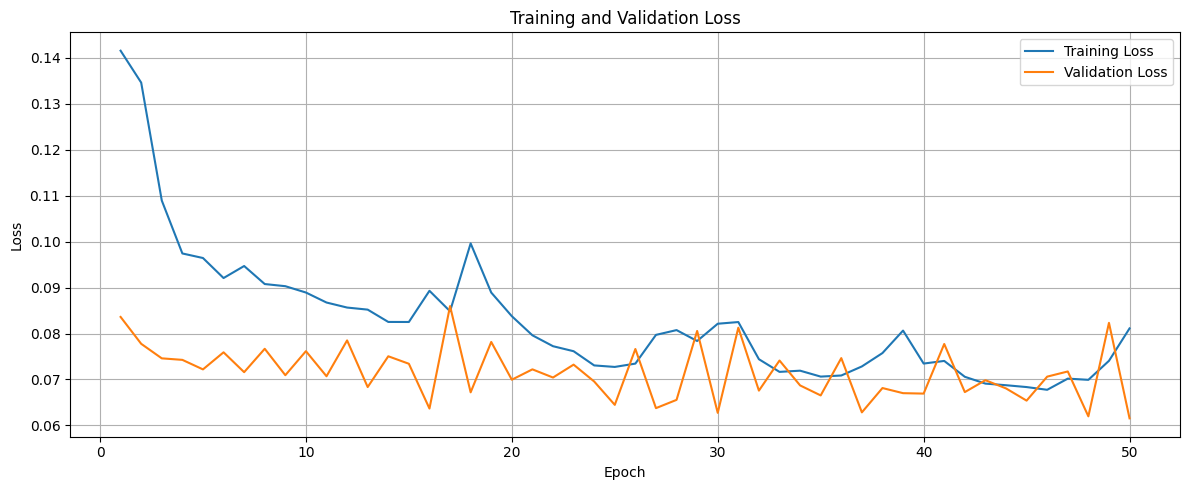

Model: "aod_LSTMSeq2SeqReduction_11_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_66 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_33[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_67 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_66[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 11)        │        561 │ lstm_67[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_23    │ (None, 7, 11)     │          0 │ dense_46[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_68 (LSTM)      │ (None, 7, 50)     │     12,400 │ repeat_vector_23… │
│                     │                   │            │ lstm_67[0][1],    │
│                     │                   │            │ lstm_67[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_69 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_68[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_36 │ (None, 7, 18)     │      1,818 │ lstm_69[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 458,939 (1.75 MB)

 Trainable params: 152,979 (597.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 305,960 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_11_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_66 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_67 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 11)             │           561 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,361 (306.10 KB)

 Trainable params: 78,361 (306.10 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_11_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_35      │ (None, 7, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_70 (LSTM)      │ [(None, 64),      │     19,712 │ input_layer_35[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_24    │ (None, 1, 64)     │          0 │ lstm_70[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_71 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_24… │
│                     │                   │            │ lstm_70[0][1],    │
│                     │                   │            │ lstm_70[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 1, 64)     │          0 │ lstm_71[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_37 │ (None, 1, 32)     │      2,080 │ dropout_13[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_38 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,849 (214.25 KB)

 Trainable params: 54,849 (214.25 KB)

 Non-trainable params: 0 (0.00 B)

None


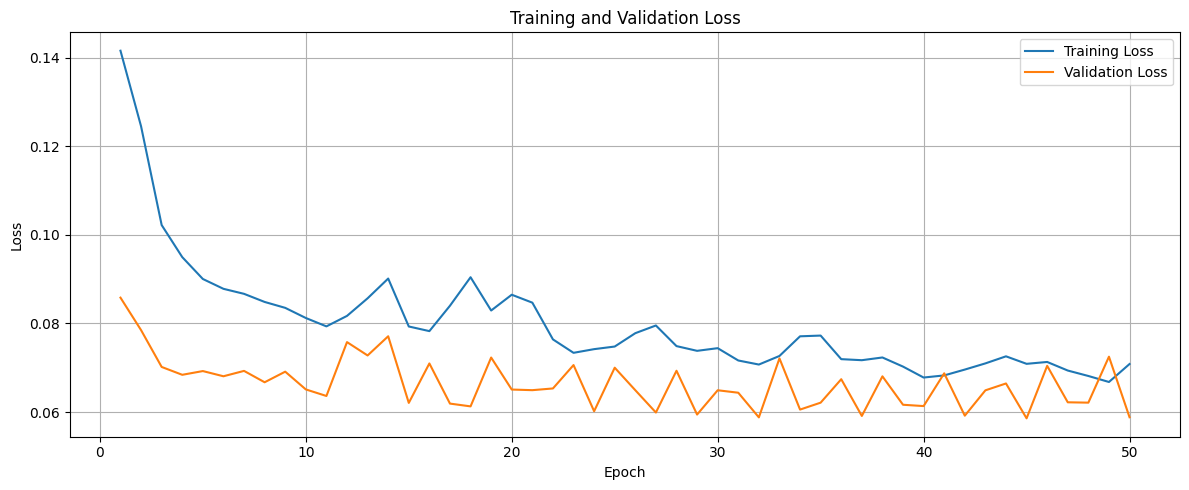

Model: "aod_LSTMSeq2SeqReduction_12_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_72 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_36[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_73 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_72[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 12)        │        612 │ lstm_73[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_25    │ (None, 7, 12)     │          0 │ dense_50[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_74 (LSTM)      │ (None, 7, 50)     │     12,600 │ repeat_vector_25… │
│                     │                   │            │ lstm_73[0][1],    │
│                     │                   │            │ lstm_73[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_75 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_74[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_39 │ (None, 7, 18)     │      1,818 │ lstm_75[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 459,692 (1.75 MB)

 Trainable params: 153,230 (598.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 306,462 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_12_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_72 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_73 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,412 (306.30 KB)

 Trainable params: 78,412 (306.30 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_12_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 7, 13)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_76 (LSTM)      │ [(None, 64),      │     19,968 │ input_layer_38[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_26    │ (None, 1, 64)     │          0 │ lstm_76[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_77 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_26… │
│                     │                   │            │ lstm_76[0][1],    │
│                     │                   │            │ lstm_76[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 1, 64)     │          0 │ lstm_77[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_40 │ (None, 1, 32)     │      2,080 │ dropout_14[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_41 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,105 (215.25 KB)

 Trainable params: 55,105 (215.25 KB)

 Non-trainable params: 0 (0.00 B)

None


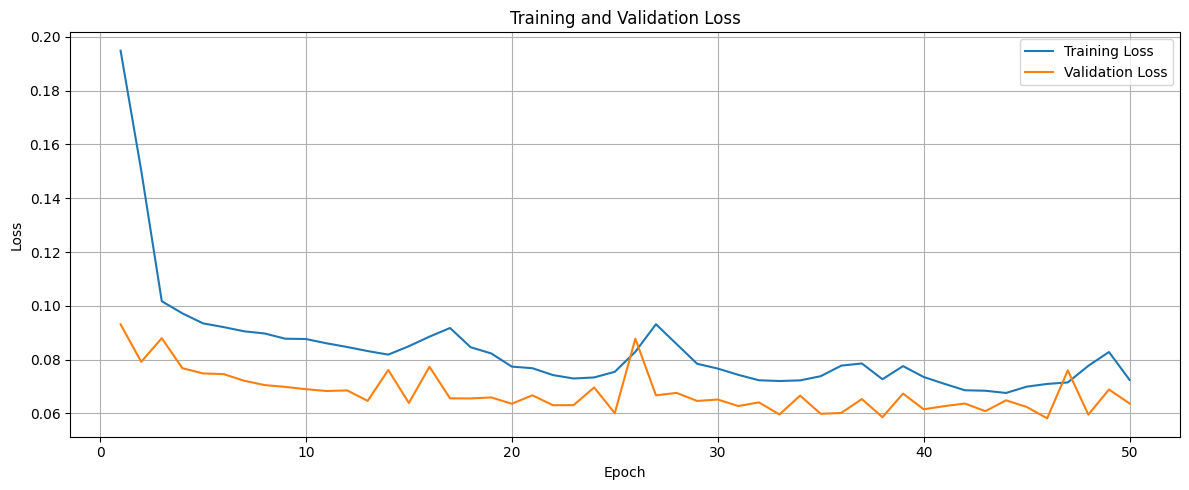

Model: "aod_LSTMSeq2SeqReduction_13_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_78 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_39[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_79 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_78[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 13)        │        663 │ lstm_79[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_27    │ (None, 7, 13)     │          0 │ dense_54[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_80 (LSTM)      │ (None, 7, 50)     │     12,800 │ repeat_vector_27… │
│                     │                   │            │ lstm_79[0][1],    │
│                     │                   │            │ lstm_79[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_81 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_80[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_42 │ (None, 7, 18)     │      1,818 │ lstm_81[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 460,445 (1.76 MB)

 Trainable params: 153,481 (599.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 306,964 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_13_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_78 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_79 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,463 (306.50 KB)

 Trainable params: 78,463 (306.50 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_13_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_41      │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_82 (LSTM)      │ [(None, 64),      │     20,224 │ input_layer_41[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_28    │ (None, 1, 64)     │          0 │ lstm_82[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_83 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_28… │
│                     │                   │            │ lstm_82[0][1],    │
│                     │                   │            │ lstm_82[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 1, 64)     │          0 │ lstm_83[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_43 │ (None, 1, 32)     │      2,080 │ dropout_15[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_44 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,361 (216.25 KB)

 Trainable params: 55,361 (216.25 KB)

 Non-trainable params: 0 (0.00 B)

None


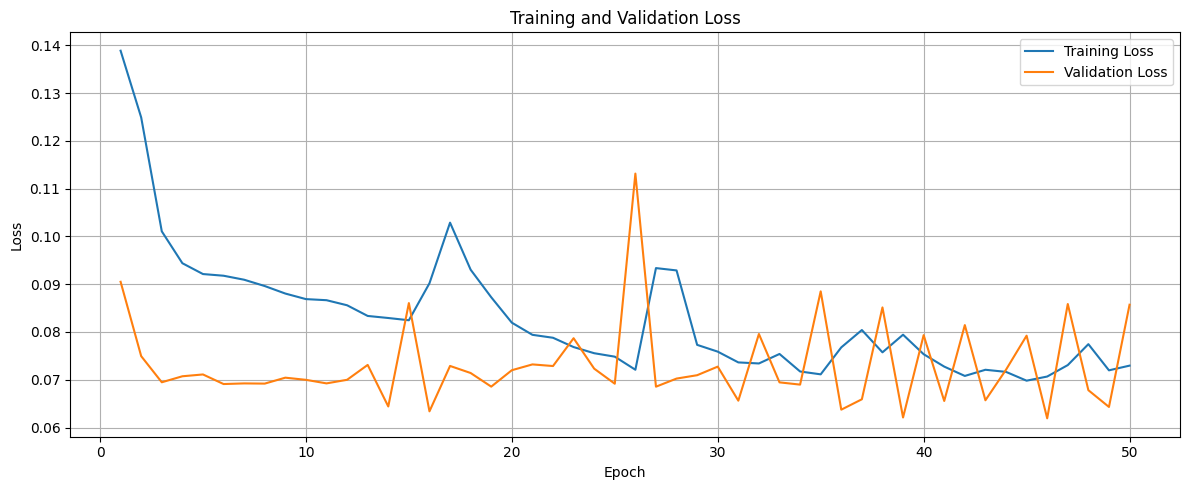

Model: "aod_LSTMSeq2SeqReduction_14_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_84 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_42[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_85 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_84[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_58 (Dense)    │ (None, 14)        │        714 │ lstm_85[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_29    │ (None, 7, 14)     │          0 │ dense_58[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_86 (LSTM)      │ (None, 7, 50)     │     13,000 │ repeat_vector_29… │
│                     │                   │            │ lstm_85[0][1],    │
│                     │                   │            │ lstm_85[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_87 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_86[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_45 │ (None, 7, 18)     │      1,818 │ lstm_87[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,198 (1.76 MB)

 Trainable params: 153,732 (600.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 307,466 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_14_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_84 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_85 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,514 (306.70 KB)

 Trainable params: 78,514 (306.70 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_14_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_44      │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_88 (LSTM)      │ [(None, 64),      │     20,480 │ input_layer_44[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_30    │ (None, 1, 64)     │          0 │ lstm_88[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_89 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_30… │
│                     │                   │            │ lstm_88[0][1],    │
│                     │                   │            │ lstm_88[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 1, 64)     │          0 │ lstm_89[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_46 │ (None, 1, 32)     │      2,080 │ dropout_16[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_47 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,617 (217.25 KB)

 Trainable params: 55,617 (217.25 KB)

 Non-trainable params: 0 (0.00 B)

None


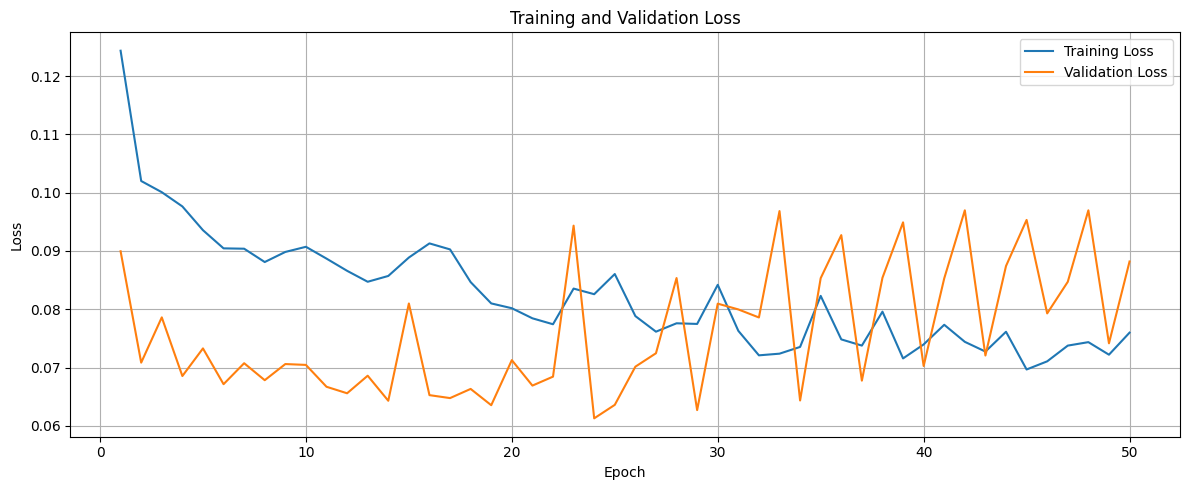

Model: "aod_LSTMSeq2SeqReduction_15_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_45      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_90 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_45[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_91 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_90[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 15)        │        765 │ lstm_91[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_31    │ (None, 7, 15)     │          0 │ dense_62[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_92 (LSTM)      │ (None, 7, 50)     │     13,200 │ repeat_vector_31… │
│                     │                   │            │ lstm_91[0][1],    │
│                     │                   │            │ lstm_91[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_93 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_92[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_48 │ (None, 7, 18)     │      1,818 │ lstm_93[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,951 (1.76 MB)

 Trainable params: 153,983 (601.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 307,968 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_15_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_46 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_90 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_91 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,565 (306.89 KB)

 Trainable params: 78,565 (306.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_15_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_47      │ (None, 7, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_94 (LSTM)      │ [(None, 64),      │     20,736 │ input_layer_47[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_32    │ (None, 1, 64)     │          0 │ lstm_94[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_95 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_32… │
│                     │                   │            │ lstm_94[0][1],    │
│                     │                   │            │ lstm_94[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 1, 64)     │          0 │ lstm_95[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_49 │ (None, 1, 32)     │      2,080 │ dropout_17[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_50 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,873 (218.25 KB)

 Trainable params: 55,873 (218.25 KB)

 Non-trainable params: 0 (0.00 B)

None


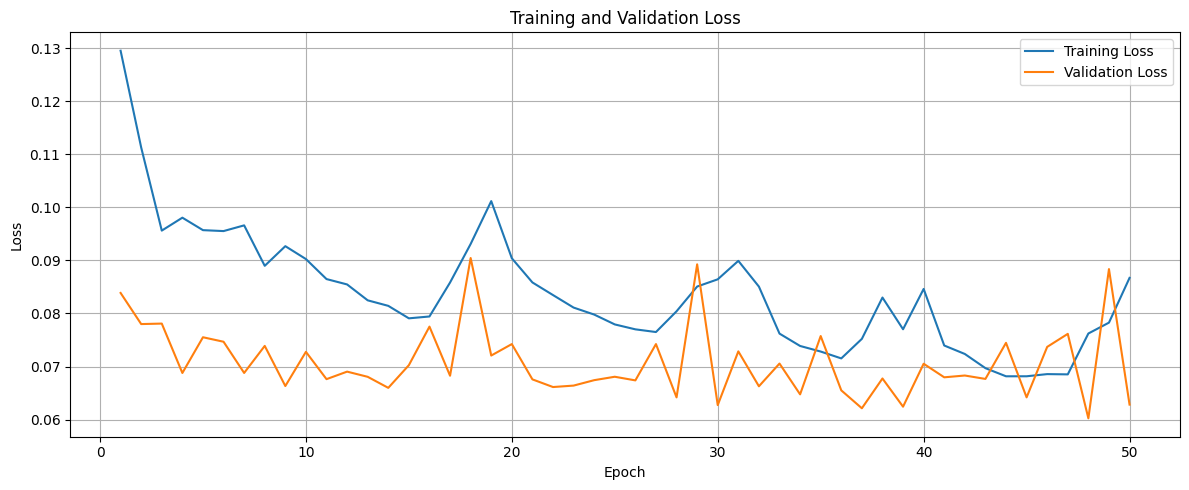

Model: "aod_LSTMSeq2SeqReduction_16_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_48      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_96 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_48[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_97 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_96[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 16)        │        816 │ lstm_97[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_33    │ (None, 7, 16)     │          0 │ dense_66[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_98 (LSTM)      │ (None, 7, 50)     │     13,400 │ repeat_vector_33… │
│                     │                   │            │ lstm_97[0][1],    │
│                     │                   │            │ lstm_97[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_99 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_98[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_51 │ (None, 7, 18)     │      1,818 │ lstm_99[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 462,704 (1.77 MB)

 Trainable params: 154,234 (602.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,470 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_16_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_49 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_96 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_97 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,616 (307.09 KB)

 Trainable params: 78,616 (307.09 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_16_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_50      │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_100 (LSTM)     │ [(None, 64),      │     20,992 │ input_layer_50[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_34    │ (None, 1, 64)     │          0 │ lstm_100[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_101 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_34… │
│                     │                   │            │ lstm_100[0][1],   │
│                     │                   │            │ lstm_100[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 1, 64)     │          0 │ lstm_101[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_52 │ (None, 1, 32)     │      2,080 │ dropout_18[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_53 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,129 (219.25 KB)

 Trainable params: 56,129 (219.25 KB)

 Non-trainable params: 0 (0.00 B)

None


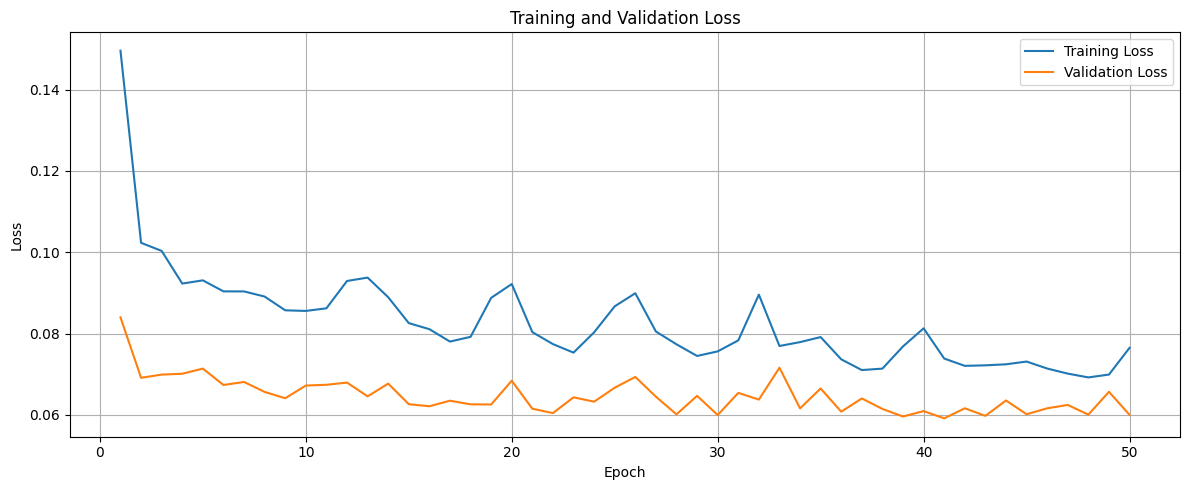

Model: "aod_LSTMSeq2SeqReduction_17_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_51      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_102 (LSTM)     │ (None, 7, 100)    │     47,600 │ input_layer_51[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_103 (LSTM)     │ [(None, 50),      │     30,200 │ lstm_102[0][0]    │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_70 (Dense)    │ (None, 17)        │        867 │ lstm_103[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_35    │ (None, 7, 17)     │          0 │ dense_70[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_104 (LSTM)     │ (None, 7, 50)     │     13,600 │ repeat_vector_35… │
│                     │                   │            │ lstm_103[0][1],   │
│                     │                   │            │ lstm_103[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_105 (LSTM)     │ (None, 7, 100)    │     60,400 │ lstm_104[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_54 │ (None, 7, 18)     │      1,818 │ lstm_105[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 463,457 (1.77 MB)

 Trainable params: 154,485 (603.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,972 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_17_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_52 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_102 (LSTM)                 │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_103 (LSTM)                 │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,667 (307.29 KB)

 Trainable params: 78,667 (307.29 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_17_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_53      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_106 (LSTM)     │ [(None, 64),      │     21,248 │ input_layer_53[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_36    │ (None, 1, 64)     │          0 │ lstm_106[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_107 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_36… │
│                     │                   │            │ lstm_106[0][1],   │
│                     │                   │            │ lstm_106[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 1, 64)     │          0 │ lstm_107[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_55 │ (None, 1, 32)     │      2,080 │ dropout_19[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_56 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,385 (220.25 KB)

 Trainable params: 56,385 (220.25 KB)

 Non-trainable params: 0 (0.00 B)

None


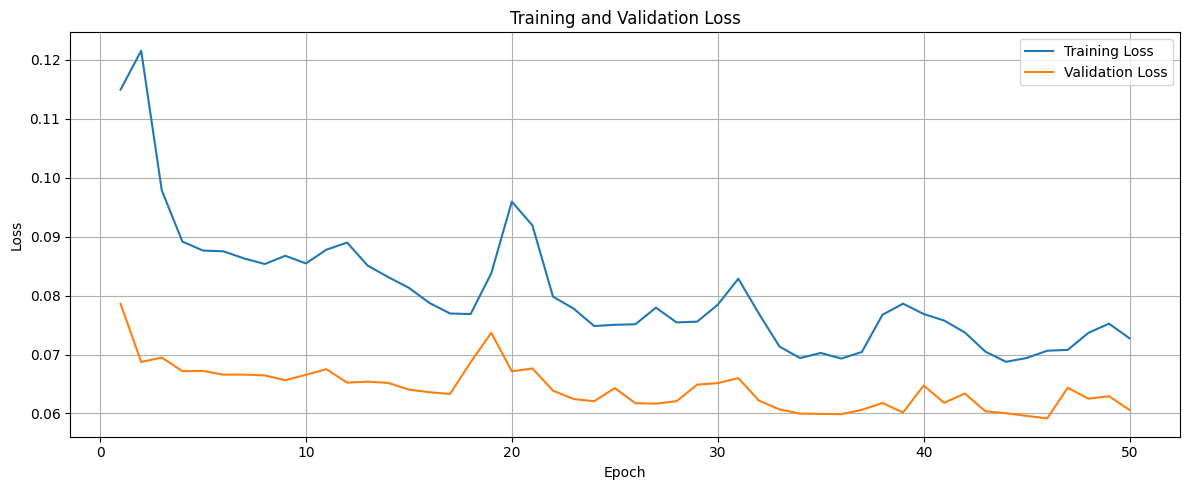

N = 10 - mae = 4.635011197311231, mse = 36.07896789655154, r2 = -5.121381160271597
N = 11 - mae = 4.407774171995895, mse = 34.14070169865559, r2 = -1.6712414907759432
N = 12 - mae = 4.720188358287469, mse = 35.609637658043916, r2 = -3.46701772240729
N = 13 - mae = 6.669857333374819, mse = 59.052797276805485, r2 = -3.8249097768069884
N = 14 - mae = 7.0170554281892645, mse = 64.14791600624477, r2 = -6.673266626193309
N = 15 - mae = 4.798225772260861, mse = 43.184333566309185, r2 = -19.97124952729556
N = 16 - mae = 4.531357023666229, mse = 35.27449417894428, r2 = -3.4107631095127964
N = 17 - mae = 4.513865121990266, mse = 38.798220001960765, r2 = -5.759418147385159


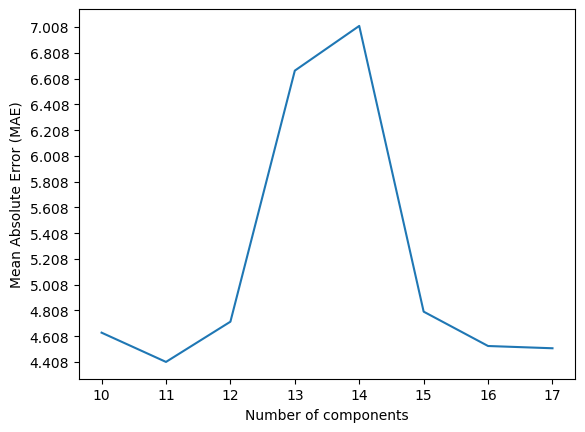

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


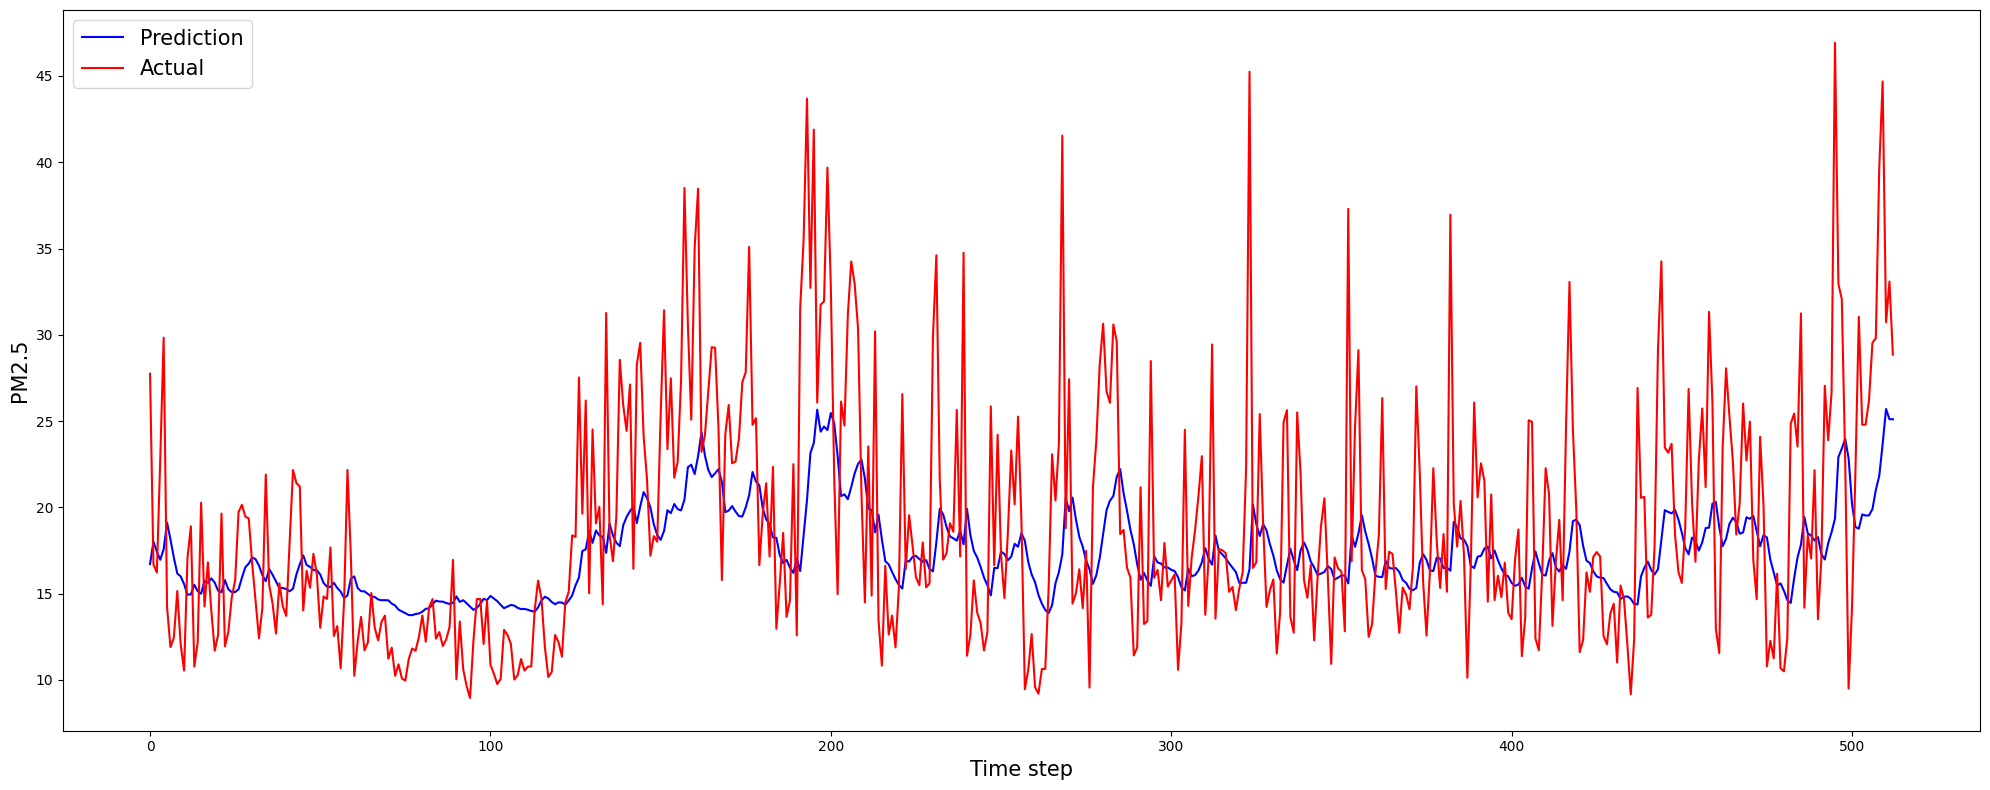

with_pm25_3km dim_reduction_method dim_after_reduction prediction       mae  \
0           Yes                 None                 N/A       LSTM  4.750573   
1            No                 None                 N/A       LSTM  7.395319   
2           Yes         LSTM-Seq2Seq                  18       LSTM  4.856416   
3            No         LSTM-Seq2Seq                  17       LSTM  4.513865   

         mse        r2  
0  36.145157 -1.044288  
1  74.086617 -2.062693  
2  38.015234 -8.149209  
3  38.798220 -5.759418

In [37]:
loopresults = generate_loopresults(RANGE_OF_DIMENSION_NO_PM25_3KM, LSTMSeq2SeqReduction, LSTMPrediction, X_aod_no_pm25_3km_scaled, y_aod_scaled, aod_label_scaler, False)
best_mae, best_mse, best_r2, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = choose_the_best(loopresults)

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['mse'] += [best_mse]
evaluation_board['r2'] += [best_r2]
evaluation_board['with_pm25_3km'] += ["No"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data (no pm25_3km)

In [38]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_lstms2s_reduced_no_pm25_3km = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_lstms2s_reduced_no_pm25_3km.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_lstms2s_reduced_2021_2022_no_pm25_3km.csv"))
df_lstms2s_reduced_no_pm25_3km

aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2021-01-01      -0.044923      -0.079401      -0.190274      -0.065436   
2021-01-02      -0.044923      -0.079401      -0.190274      -0.065436   
2021-01-03      -0.045060      -0.079754      -0.188911      -0.064276   
2021-01-04      -0.046628      -0.080558      -0.186769      -0.062662   
2021-01-05      -0.048434      -0.080953      -0.184291      -0.060907   
...                   ...            ...            ...            ...   
2022-12-27       0.280153       0.001834      -0.107981      -0.071342   
2022-12-28       0.276617       0.001742      -0.103333      -0.069159   
2022-12-29       0.272643       0.002373      -0.099755      -0.069267   
2022-12-30       0.265089       0.001797      -0.096787      -0.069462   
2022-12-31       0.263710       0.001467      -0.097712      -0.070636   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2021-01-01      -0.540536      -0.252285      -1.469840      -0.096530   
2021-01-02      -0.540536      -0.252285      -1.469840      -0.096530   
2021-01-03      -0.539360      -0.251861      -1.469053      -0.096564   
2021-01-04      -0.539006      -0.252573      -1.468018      -0.097246   
2021-01-05      -0.539247      -0.254143      -1.468143      -0.098127   
...                   ...            ...            ...            ...   
2022-12-27      -0.094203      -0.210973      -0.751337      -0.270624   
2022-12-28      -0.096827      -0.216974      -0.751081      -0.272904   
2022-12-29      -0.101051      -0.222703      -0.750923      -0.274248   
2022-12-30      -0.111119      -0.229240      -0.756555      -0.273812   
2022-12-31      -0.114415      -0.230404      -0.759876      -0.273139   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2021-01-01      -0.210297       -0.401671       -0.118221       -0.287883   
2021-01-02      -0.210297       -0.401671       -0.118221       -0.287883   
2021-01-03      -0.210516       -0.401736       -0.118651       -0.288273   
2021-01-04      -0.210295       -0.400789       -0.119535       -0.289905   
2021-01-05      -0.209319       -0.399083       -0.120529       -0.292545   
...                   ...             ...             ...             ...   
2022-12-27      -0.158274       -0.176756        0.169140       -0.292974   
2022-12-28      -0.153457       -0.173020        0.169007       -0.297220   
2022-12-29      -0.147879       -0.168878        0.167720       -0.299549   
2022-12-30      -0.144631       -0.169166        0.164313       -0.302595   
2022-12-31      -0.145291       -0.171418        0.163995       -0.303077   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2021-01-01       -0.497439        0.562462       -0.265060       -0.060774   
2021-01-02       -0.497439        0.562462       -0.265060       -0.060774   
2021-01-03       -0.496585        0.562672       -0.263976       -0.061100   
2021-01-04       -0.495771        0.562984       -0.262208       -0.062501   
2021-01-05       -0.496133        0.563997       -0.261886       -0.064096   
...                    ...             ...             ...             ...   
2022-12-27       -0.100482       -0.051469       -0.007198       -0.179565   
2022-12-28       -0.102543       -0.047087       -0.007263       -0.182779   
2022-12-29       -0.104202       -0.041625       -0.007184       -0.183429   
2022-12-30       -0.109729       -0.033207       -0.008769       -0.182550   
2022-12-31       -0.111049       -0.031534       -0.010431       -0.181109   

            aod_feature_17  station  
time                           

In [39]:
# Prepare the reduced data with additional pm25_3km and predicted pm25 values
df_lstms2s_reduced_augmented = augmentReducedData(df_lstms2s_reduced_no_pm25_3km, y_aod_scaled, aod_pm25_3km_column, aod_label_scaler)
df_lstms2s_reduced_augmented.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_lstms2s_reduced_2021_2022_no_pm25_3km_with_raw_pm25_3km_and_prediced_pm25.csv"))
df_lstms2s_reduced_augmented

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


5.226644462642911


aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2021-01-01      -0.044923      -0.079401      -0.190274      -0.065436   
2021-01-02      -0.044923      -0.079401      -0.190274      -0.065436   
2021-01-03      -0.045060      -0.079754      -0.188911      -0.064276   
2021-01-04      -0.046628      -0.080558      -0.186769      -0.062662   
2021-01-05      -0.048434      -0.080953      -0.184291      -0.060907   
...                   ...            ...            ...            ...   
2022-12-27       0.280153       0.001834      -0.107981      -0.071342   
2022-12-28       0.276617       0.001742      -0.103333      -0.069159   
2022-12-29       0.272643       0.002373      -0.099755      -0.069267   
2022-12-30       0.265089       0.001797      -0.096787      -0.069462   
2022-12-31       0.263710       0.001467      -0.097712      -0.070636   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2021-01-01      -0.540536      -0.252285      -1.469840      -0.096530   
2021-01-02      -0.540536      -0.252285      -1.469840      -0.096530   
2021-01-03      -0.539360      -0.251861      -1.469053      -0.096564   
2021-01-04      -0.539006      -0.252573      -1.468018      -0.097246   
2021-01-05      -0.539247      -0.254143      -1.468143      -0.098127   
...                   ...            ...            ...            ...   
2022-12-27      -0.094203      -0.210973      -0.751337      -0.270624   
2022-12-28      -0.096827      -0.216974      -0.751081      -0.272904   
2022-12-29      -0.101051      -0.222703      -0.750923      -0.274248   
2022-12-30      -0.111119      -0.229240      -0.756555      -0.273812   
2022-12-31      -0.114415      -0.230404      -0.759876      -0.273139   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2021-01-01      -0.210297       -0.401671       -0.118221       -0.287883   
2021-01-02      -0.210297       -0.401671       -0.118221       -0.287883   
2021-01-03      -0.210516       -0.401736       -0.118651       -0.288273   
2021-01-04      -0.210295       -0.400789       -0.119535       -0.289905   
2021-01-05      -0.209319       -0.399083       -0.120529       -0.292545   
...                   ...             ...             ...             ...   
2022-12-27      -0.158274       -0.176756        0.169140       -0.292974   
2022-12-28      -0.153457       -0.173020        0.169007       -0.297220   
2022-12-29      -0.147879       -0.168878        0.167720       -0.299549   
2022-12-30      -0.144631       -0.169166        0.164313       -0.302595   
2022-12-31      -0.145291       -0.171418        0.163995       -0.303077   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2021-01-01       -0.497439        0.562462       -0.265060       -0.060774   
2021-01-02       -0.497439        0.562462       -0.265060       -0.060774   
2021-01-03       -0.496585        0.562672       -0.263976       -0.061100   
2021-01-04       -0.495771        0.562984       -0.262208       -0.062501   
2021-01-05       -0.496133        0.563997       -0.261886       -0.064096   
...                    ...             ...             ...             ...   
2022-12-27       -0.100482       -0.051469       -0.007198       -0.179565   
2022-12-28       -0.102543       -0.047087       -0.007263       -0.182779   
2022-12-29       -0.104202       -0.041625       -0.007184       -0.183429   
2022-12-30       -0.109729       -0.033207       -0.008769       -0.182550   
2022-12-31       -0.111049       -0.031534       -0.010431       -0.181109   

            aod_feature_17  station   pm25_3km  hiep_predicted_pm25  

### Prediction + GRU-Seq2Seq

#### Doing the loop

Model: "aod_GRUSeq2SeqReduction_10_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_55      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 7, 100)    │     36,300 │ input_layer_55[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ [(None, 50),      │     22,800 │ gru[0][0]         │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_76 (Dense)    │ (None, 10)        │        510 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_38    │ (None, 7, 10)     │          0 │ dense_76[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 7, 50)     │      9,300 │ repeat_vector_38… │
│                     │                   │            │ gru_1[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 7, 100)    │     45,600 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_59 │ (None, 7, 19)     │      1,919 │ gru_3[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 349,289 (1.33 MB)

 Trainable params: 116,429 (454.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 232,860 (909.61 KB)

None


Model: "aod_GRUSeq2SeqReduction_10_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_56 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,610 (232.85 KB)

 Trainable params: 59,610 (232.85 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_10_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_57      │ (None, 7, 11)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_110 (LSTM)     │ [(None, 64),      │     19,456 │ input_layer_57[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_39    │ (None, 1, 64)     │          0 │ lstm_110[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_111 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_39… │
│                     │                   │            │ lstm_110[0][1],   │
│                     │                   │            │ lstm_110[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 1, 64)     │          0 │ lstm_111[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_60 │ (None, 1, 32)     │      2,080 │ dropout_21[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_61 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,593 (213.25 KB)

 Trainable params: 54,593 (213.25 KB)

 Non-trainable params: 0 (0.00 B)

None


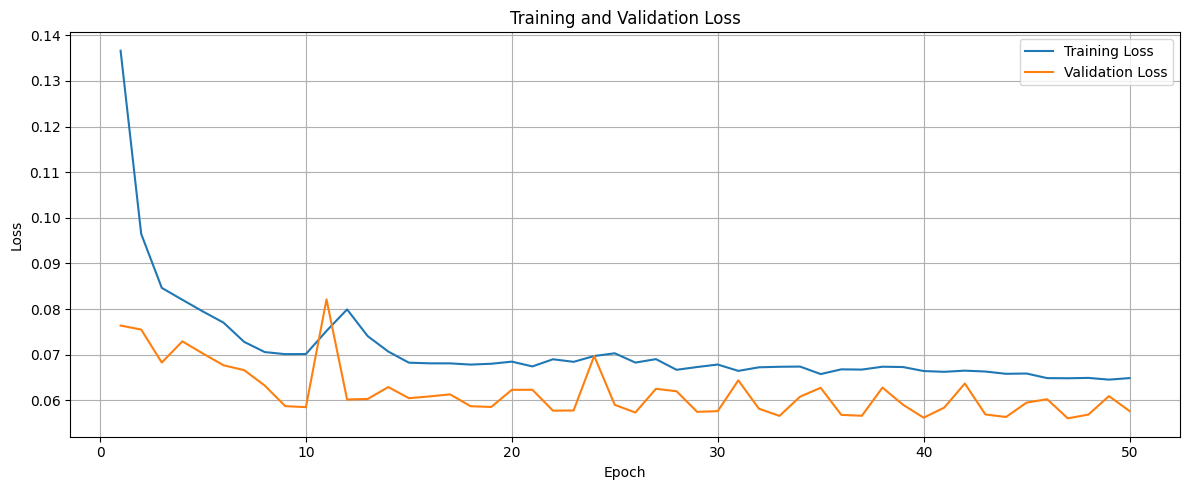

Model: "aod_GRUSeq2SeqReduction_11_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_58      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 7, 100)    │     36,300 │ input_layer_58[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ [(None, 50),      │     22,800 │ gru_4[0][0]       │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_80 (Dense)    │ (None, 11)        │        561 │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_40    │ (None, 7, 11)     │          0 │ dense_80[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ (None, 7, 50)     │      9,450 │ repeat_vector_40… │
│                     │                   │            │ gru_5[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_7 (GRU)         │ (None, 7, 100)    │     45,600 │ gru_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_62 │ (None, 7, 19)     │      1,919 │ gru_7[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 349,892 (1.33 MB)

 Trainable params: 116,630 (455.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 233,262 (911.18 KB)

None


Model: "aod_GRUSeq2SeqReduction_11_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_59 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 11)             │           561 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,661 (233.05 KB)

 Trainable params: 59,661 (233.05 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_11_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_60      │ (None, 7, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_112 (LSTM)     │ [(None, 64),      │     19,712 │ input_layer_60[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_41    │ (None, 1, 64)     │          0 │ lstm_112[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_113 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_41… │
│                     │                   │            │ lstm_112[0][1],   │
│                     │                   │            │ lstm_112[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 1, 64)     │          0 │ lstm_113[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_63 │ (None, 1, 32)     │      2,080 │ dropout_22[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_64 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,849 (214.25 KB)

 Trainable params: 54,849 (214.25 KB)

 Non-trainable params: 0 (0.00 B)

None


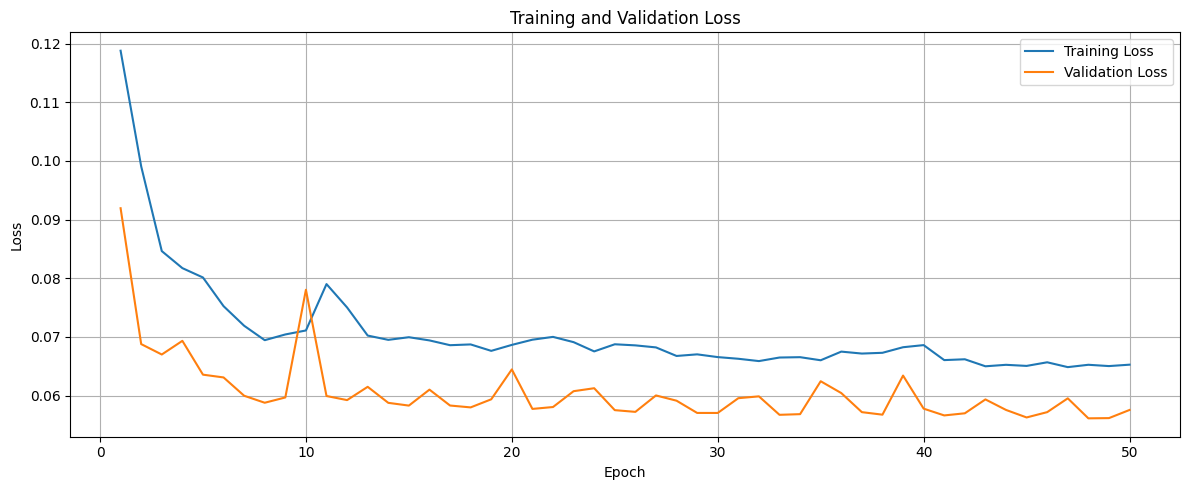

Model: "aod_GRUSeq2SeqReduction_12_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_61      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_8 (GRU)         │ (None, 7, 100)    │     36,300 │ input_layer_61[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_9 (GRU)         │ [(None, 50),      │     22,800 │ gru_8[0][0]       │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_84 (Dense)    │ (None, 12)        │        612 │ gru_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_42    │ (None, 7, 12)     │          0 │ dense_84[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_10 (GRU)        │ (None, 7, 50)     │      9,600 │ repeat_vector_42… │
│                     │                   │            │ gru_9[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_11 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_65 │ (None, 7, 19)     │      1,919 │ gru_11[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 350,495 (1.34 MB)

 Trainable params: 116,831 (456.37 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 233,664 (912.75 KB)

None


Model: "aod_GRUSeq2SeqReduction_12_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_62 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,712 (233.25 KB)

 Trainable params: 59,712 (233.25 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_12_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_63      │ (None, 7, 13)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_114 (LSTM)     │ [(None, 64),      │     19,968 │ input_layer_63[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_43    │ (None, 1, 64)     │          0 │ lstm_114[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_115 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_43… │
│                     │                   │            │ lstm_114[0][1],   │
│                     │                   │            │ lstm_114[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 1, 64)     │          0 │ lstm_115[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_66 │ (None, 1, 32)     │      2,080 │ dropout_23[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_67 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,105 (215.25 KB)

 Trainable params: 55,105 (215.25 KB)

 Non-trainable params: 0 (0.00 B)

None


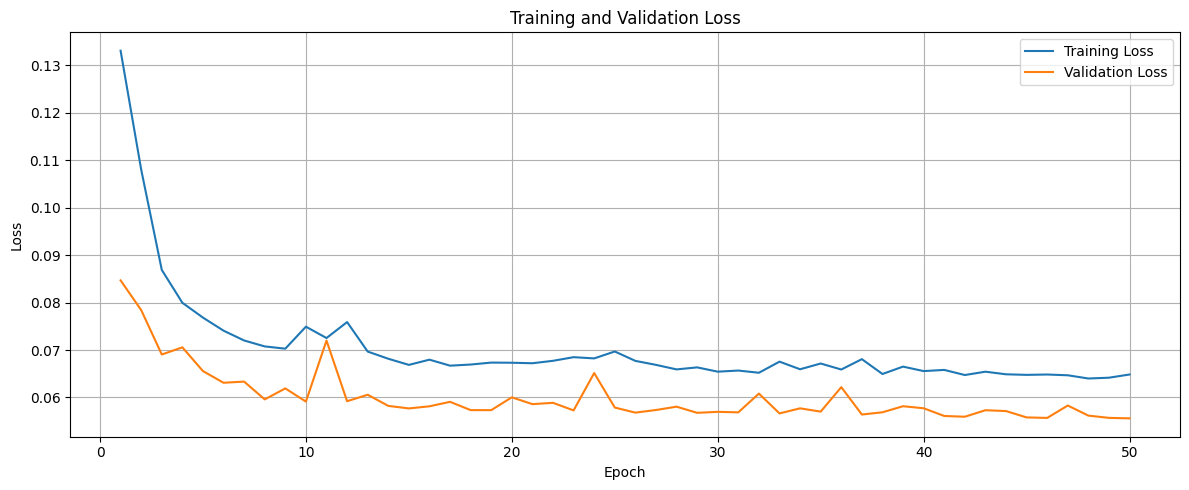

Model: "aod_GRUSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_64      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_12 (GRU)        │ (None, 7, 100)    │     36,300 │ input_layer_64[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_13 (GRU)        │ [(None, 50),      │     22,800 │ gru_12[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_88 (Dense)    │ (None, 13)        │        663 │ gru_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_44    │ (None, 7, 13)     │          0 │ dense_88[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_14 (GRU)        │ (None, 7, 50)     │      9,750 │ repeat_vector_44… │
│                     │                   │            │ gru_13[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_15 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_68 │ (None, 7, 19)     │      1,919 │ gru_15[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 351,098 (1.34 MB)

 Trainable params: 117,032 (457.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,066 (914.32 KB)

None


Model: "aod_GRUSeq2SeqReduction_13_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_65 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_12 (GRU)                    │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,763 (233.45 KB)

 Trainable params: 59,763 (233.45 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_66      │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_116 (LSTM)     │ [(None, 64),      │     20,224 │ input_layer_66[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_45    │ (None, 1, 64)     │          0 │ lstm_116[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_117 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_45… │
│                     │                   │            │ lstm_116[0][1],   │
│                     │                   │            │ lstm_116[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 1, 64)     │          0 │ lstm_117[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_69 │ (None, 1, 32)     │      2,080 │ dropout_24[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_70 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,361 (216.25 KB)

 Trainable params: 55,361 (216.25 KB)

 Non-trainable params: 0 (0.00 B)

None


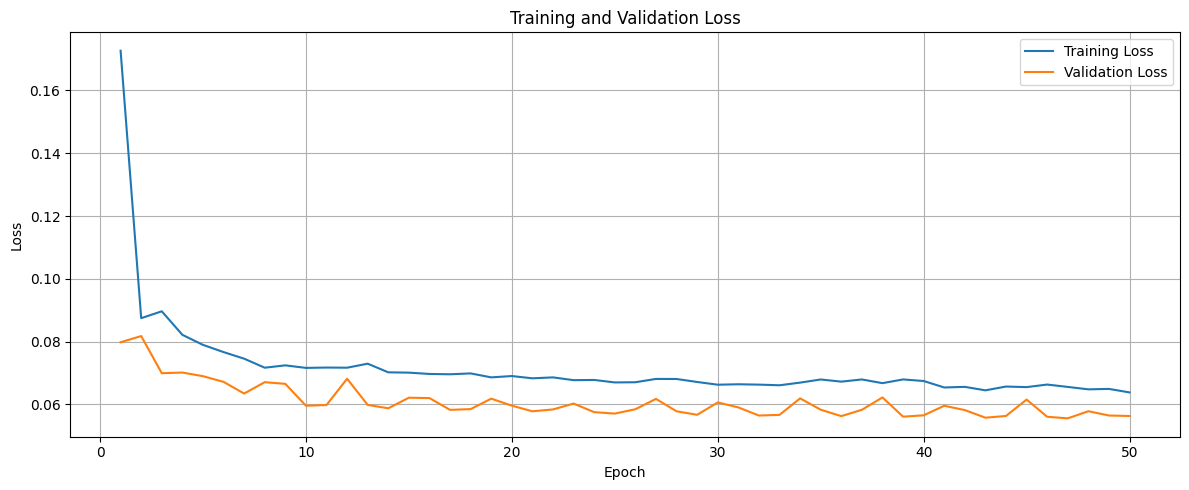

Model: "aod_GRUSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_67      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_16 (GRU)        │ (None, 7, 100)    │     36,300 │ input_layer_67[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_17 (GRU)        │ [(None, 50),      │     22,800 │ gru_16[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_92 (Dense)    │ (None, 14)        │        714 │ gru_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_46    │ (None, 7, 14)     │          0 │ dense_92[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_18 (GRU)        │ (None, 7, 50)     │      9,900 │ repeat_vector_46… │
│                     │                   │            │ gru_17[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_19 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_71 │ (None, 7, 19)     │      1,919 │ gru_19[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 351,701 (1.34 MB)

 Trainable params: 117,233 (457.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,468 (915.89 KB)

None


Model: "aod_GRUSeq2SeqReduction_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_68 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_16 (GRU)                    │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_17 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,814 (233.65 KB)

 Trainable params: 59,814 (233.65 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_69      │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_118 (LSTM)     │ [(None, 64),      │     20,480 │ input_layer_69[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_47    │ (None, 1, 64)     │          0 │ lstm_118[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_119 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_47… │
│                     │                   │            │ lstm_118[0][1],   │
│                     │                   │            │ lstm_118[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 1, 64)     │          0 │ lstm_119[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_72 │ (None, 1, 32)     │      2,080 │ dropout_25[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_73 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,617 (217.25 KB)

 Trainable params: 55,617 (217.25 KB)

 Non-trainable params: 0 (0.00 B)

None


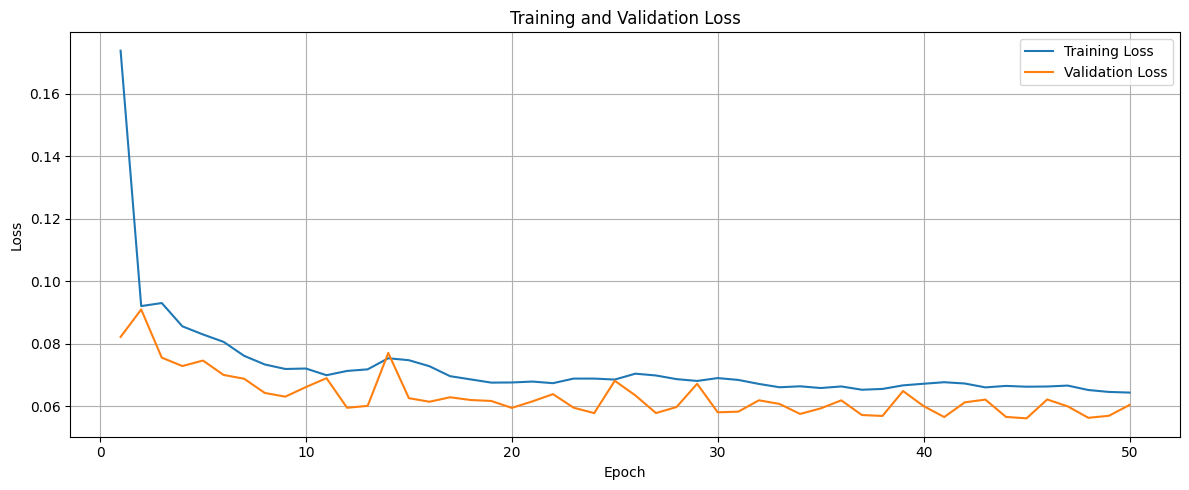

Model: "aod_GRUSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_70      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_20 (GRU)        │ (None, 7, 100)    │     36,300 │ input_layer_70[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_21 (GRU)        │ [(None, 50),      │     22,800 │ gru_20[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_96 (Dense)    │ (None, 15)        │        765 │ gru_21[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_48    │ (None, 7, 15)     │          0 │ dense_96[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_22 (GRU)        │ (None, 7, 50)     │     10,050 │ repeat_vector_48… │
│                     │                   │            │ gru_21[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_23 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_22[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_74 │ (None, 7, 19)     │      1,919 │ gru_23[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 352,304 (1.34 MB)

 Trainable params: 117,434 (458.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,870 (917.46 KB)

None


Model: "aod_GRUSeq2SeqReduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_71 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_20 (GRU)                    │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_21 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,865 (233.85 KB)

 Trainable params: 59,865 (233.85 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_72      │ (None, 7, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_120 (LSTM)     │ [(None, 64),      │     20,736 │ input_layer_72[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_49    │ (None, 1, 64)     │          0 │ lstm_120[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_121 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_49… │
│                     │                   │            │ lstm_120[0][1],   │
│                     │                   │            │ lstm_120[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 1, 64)     │          0 │ lstm_121[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_75 │ (None, 1, 32)     │      2,080 │ dropout_26[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_76 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,873 (218.25 KB)

 Trainable params: 55,873 (218.25 KB)

 Non-trainable params: 0 (0.00 B)

None


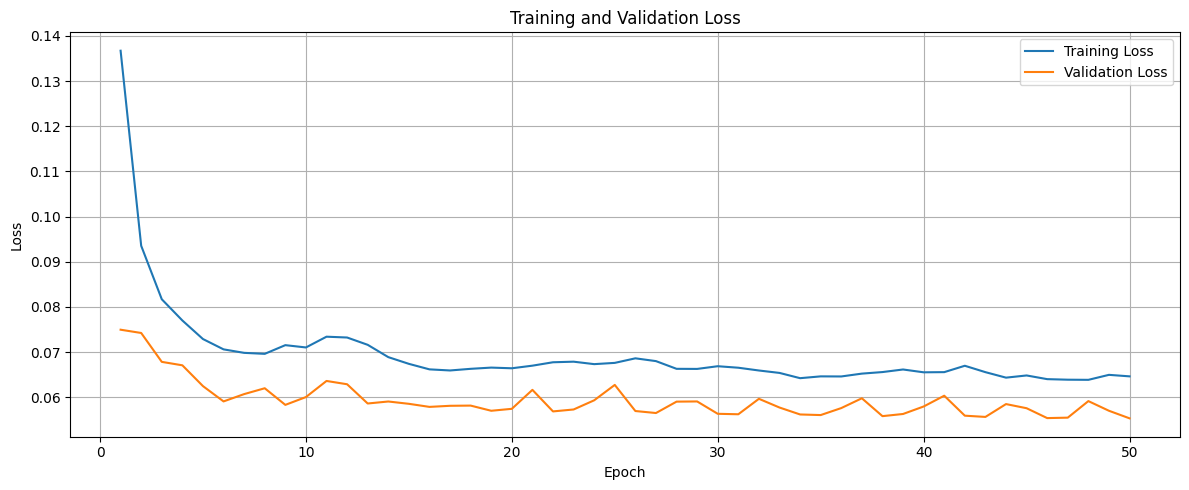

Model: "aod_GRUSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_73      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_24 (GRU)        │ (None, 7, 100)    │     36,300 │ input_layer_73[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_25 (GRU)        │ [(None, 50),      │     22,800 │ gru_24[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_100 (Dense)   │ (None, 16)        │        816 │ gru_25[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_50    │ (None, 7, 16)     │          0 │ dense_100[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_26 (GRU)        │ (None, 7, 50)     │     10,200 │ repeat_vector_50… │
│                     │                   │            │ gru_25[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_27 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_26[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_77 │ (None, 7, 19)     │      1,919 │ gru_27[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 352,907 (1.35 MB)

 Trainable params: 117,635 (459.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,272 (919.04 KB)

None


Model: "aod_GRUSeq2SeqReduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_74 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_24 (GRU)                    │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_25 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,916 (234.05 KB)

 Trainable params: 59,916 (234.05 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_75      │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_122 (LSTM)     │ [(None, 64),      │     20,992 │ input_layer_75[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_51    │ (None, 1, 64)     │          0 │ lstm_122[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_123 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_51… │
│                     │                   │            │ lstm_122[0][1],   │
│                     │                   │            │ lstm_122[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 1, 64)     │          0 │ lstm_123[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_78 │ (None, 1, 32)     │      2,080 │ dropout_27[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_79 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,129 (219.25 KB)

 Trainable params: 56,129 (219.25 KB)

 Non-trainable params: 0 (0.00 B)

None


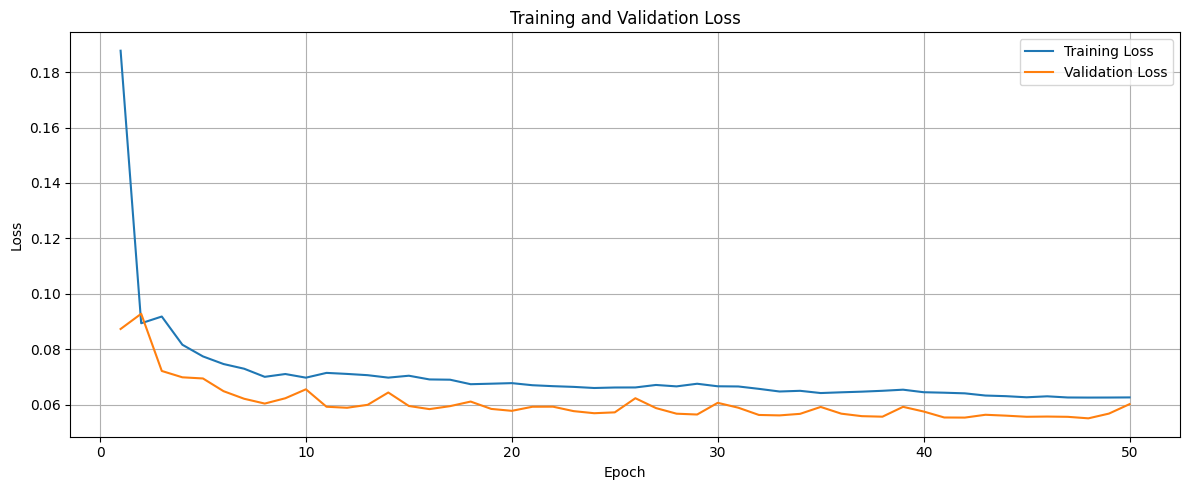

Model: "aod_GRUSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_76      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_28 (GRU)        │ (None, 7, 100)    │     36,300 │ input_layer_76[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_29 (GRU)        │ [(None, 50),      │     22,800 │ gru_28[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_104 (Dense)   │ (None, 17)        │        867 │ gru_29[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_52    │ (None, 7, 17)     │          0 │ dense_104[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_30 (GRU)        │ (None, 7, 50)     │     10,350 │ repeat_vector_52… │
│                     │                   │            │ gru_29[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_31 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_30[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_80 │ (None, 7, 19)     │      1,919 │ gru_31[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 353,510 (1.35 MB)

 Trainable params: 117,836 (460.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,674 (920.61 KB)

None


Model: "aod_GRUSeq2SeqReduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_77 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_28 (GRU)                    │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_29 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,967 (234.25 KB)

 Trainable params: 59,967 (234.25 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_78      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_124 (LSTM)     │ [(None, 64),      │     21,248 │ input_layer_78[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_53    │ (None, 1, 64)     │          0 │ lstm_124[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_125 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_53… │
│                     │                   │            │ lstm_124[0][1],   │
│                     │                   │            │ lstm_124[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 1, 64)     │          0 │ lstm_125[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_81 │ (None, 1, 32)     │      2,080 │ dropout_28[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_82 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,385 (220.25 KB)

 Trainable params: 56,385 (220.25 KB)

 Non-trainable params: 0 (0.00 B)

None


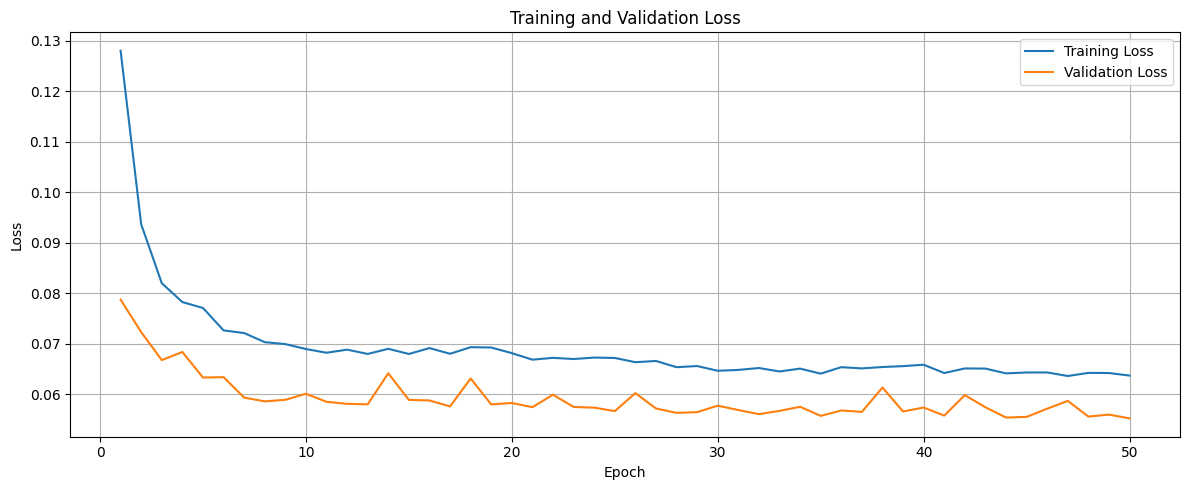

Model: "aod_GRUSeq2SeqReduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_79      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_32 (GRU)        │ (None, 7, 100)    │     36,300 │ input_layer_79[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_33 (GRU)        │ [(None, 50),      │     22,800 │ gru_32[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_108 (Dense)   │ (None, 18)        │        918 │ gru_33[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_54    │ (None, 7, 18)     │          0 │ dense_108[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_34 (GRU)        │ (None, 7, 50)     │     10,500 │ repeat_vector_54… │
│                     │                   │            │ gru_33[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_35 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_34[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_83 │ (None, 7, 19)     │      1,919 │ gru_35[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 354,113 (1.35 MB)

 Trainable params: 118,037 (461.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 236,076 (922.18 KB)

None


Model: "aod_GRUSeq2SeqReduction_18_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_80 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_32 (GRU)                    │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_33 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,018 (234.45 KB)

 Trainable params: 60,018 (234.45 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_81      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_126 (LSTM)     │ [(None, 64),      │     21,504 │ input_layer_81[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_55    │ (None, 1, 64)     │          0 │ lstm_126[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_127 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_55… │
│                     │                   │            │ lstm_126[0][1],   │
│                     │                   │            │ lstm_126[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 1, 64)     │          0 │ lstm_127[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_84 │ (None, 1, 32)     │      2,080 │ dropout_29[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_85 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,641 (221.25 KB)

 Trainable params: 56,641 (221.25 KB)

 Non-trainable params: 0 (0.00 B)

None


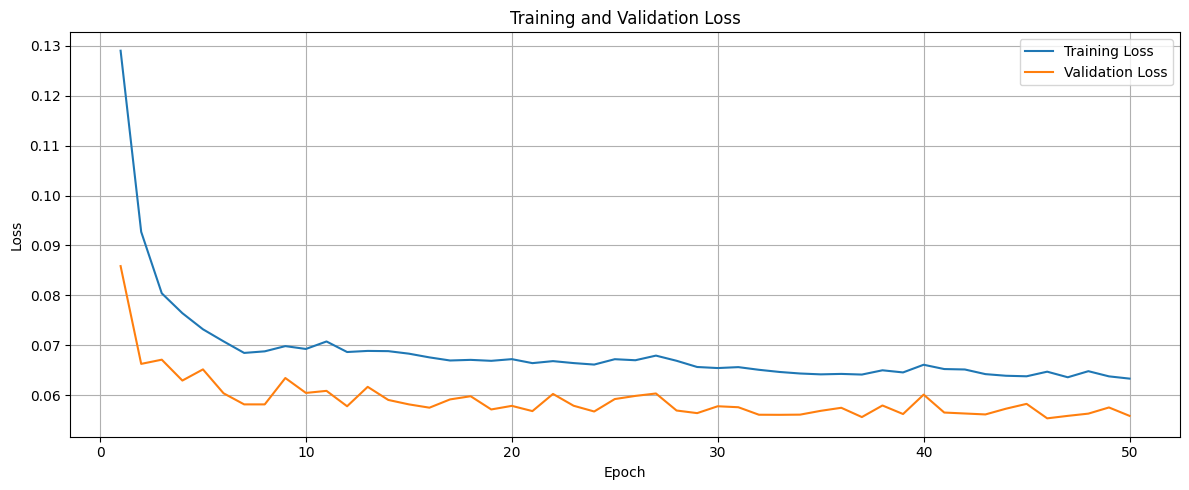

N = 10 - mae = 4.347708663522587, mse = 32.763290813422806, r2 = -0.8904423300244622
N = 11 - mae = 4.239922682972609, mse = 33.4449334068692, r2 = -0.4619547257624379
N = 12 - mae = 4.190948655380651, mse = 34.90728830832122, r2 = -0.6312627004367681
N = 13 - mae = 4.2329859266155445, mse = 32.83940655906777, r2 = -0.6160104488911669
N = 14 - mae = 4.5429744409642145, mse = 34.44503153226053, r2 = -0.6913182363137143
N = 15 - mae = 4.1760131808232845, mse = 34.46369314014337, r2 = -0.7850427691539692
N = 16 - mae = 4.422208878080247, mse = 33.29781613554481, r2 = -0.5221341506552775
N = 17 - mae = 4.131507321856711, mse = 32.81381452898502, r2 = -0.6050668763956775
N = 18 - mae = 4.176987881226413, mse = 32.6255881740273, r2 = -0.48424072424374076


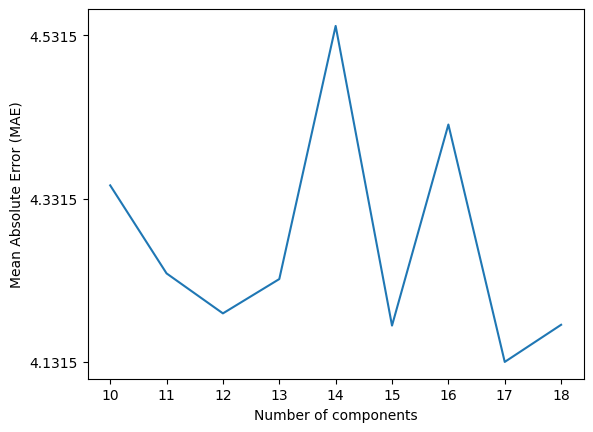

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


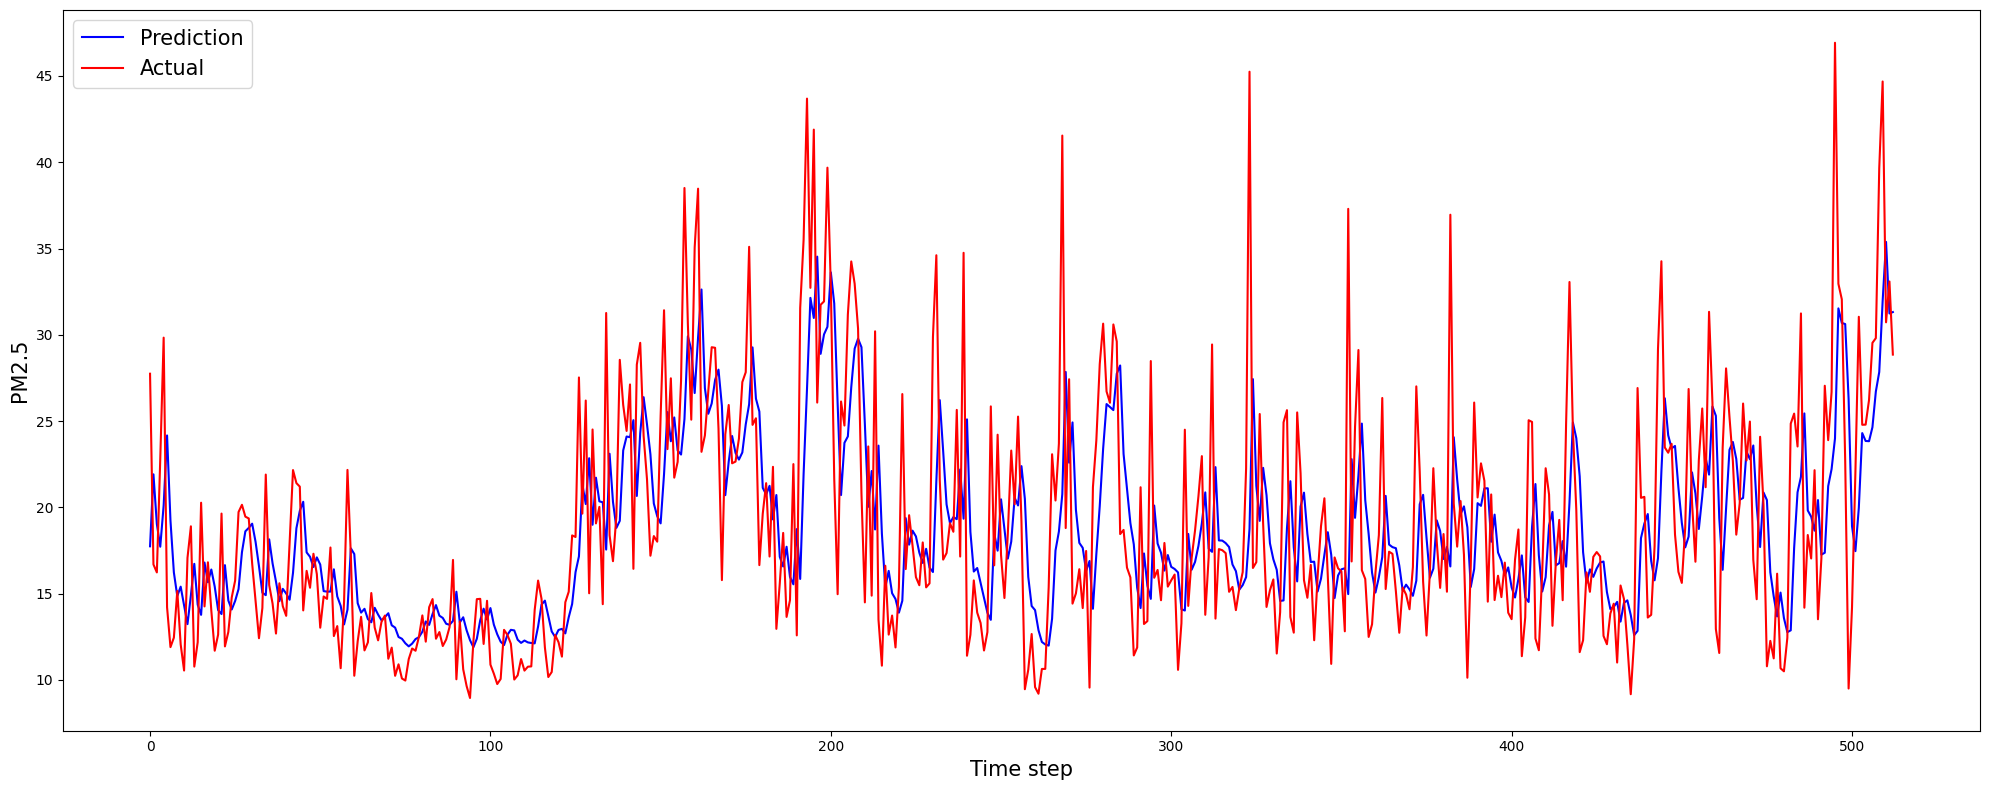

with_pm25_3km dim_reduction_method dim_after_reduction prediction       mae  \
0           Yes                 None                 N/A       LSTM  4.750573   
1            No                 None                 N/A       LSTM  7.395319   
2           Yes         LSTM-Seq2Seq                  18       LSTM  4.856416   
3            No         LSTM-Seq2Seq                  17       LSTM  4.513865   
4           Yes          GRU-Seq2Seq                  18       LSTM  4.176988   

         mse        r2  
0  36.145157 -1.044288  
1  74.086617 -2.062693  
2  38.015234 -8.149209  
3  38.798220 -5.759418  
4  32.625588 -0.484241

In [40]:
loopresults = generate_loopresults(RANGE_OF_DIMENSION, GRUSeq2SeqReduction, LSTMPrediction, X_aod_scaled, y_aod_scaled, aod_label_scaler)
best_mae, best_mse, best_r2, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = choose_the_best(loopresults)

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["GRU-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['mse'] += [best_mse]
evaluation_board['r2'] += [best_r2]
evaluation_board['with_pm25_3km'] += ["Yes"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [41]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_grus2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_grus2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_grus2s_reduced_2021_2022.csv"))
df_grus2s_reduced

aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2021-01-01       0.093146       0.030110       0.041388       0.022187   
2021-01-02       0.093146       0.030110       0.041388       0.022187   
2021-01-03       0.093007       0.030350       0.041553       0.022321   
2021-01-04       0.092914       0.030510       0.041703       0.022464   
2021-01-05       0.092814       0.030576       0.041727       0.022503   
...                   ...            ...            ...            ...   
2022-12-27       0.034527       0.058683       0.040920       0.028763   
2022-12-28       0.034846       0.058243       0.041283       0.028981   
2022-12-29       0.034415       0.058493       0.041093       0.028889   
2022-12-30       0.033755       0.058974       0.040670       0.028706   
2022-12-31       0.033265       0.059425       0.040099       0.028423   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2021-01-01       0.049582       0.030376       0.071542       0.083905   
2021-01-02       0.049582       0.030376       0.071542       0.083905   
2021-01-03       0.049436       0.030554       0.071506       0.084129   
2021-01-04       0.049324       0.030784       0.071458       0.084416   
2021-01-05       0.049192       0.030903       0.071484       0.084793   
...                   ...            ...            ...            ...   
2022-12-27       0.057808       0.034219       0.049428       0.041346   
2022-12-28       0.057630       0.034520       0.049276       0.041309   
2022-12-29       0.058100       0.034487       0.049257       0.041312   
2022-12-30       0.058748       0.034425       0.049233       0.041363   
2022-12-31       0.058984       0.034068       0.049373       0.041469   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2021-01-01       0.103793        0.052190        0.084611        0.086532   
2021-01-02       0.103793        0.052190        0.084611        0.086532   
2021-01-03       0.103152        0.052362        0.084230        0.086256   
2021-01-04       0.102499        0.052575        0.083637        0.086124   
2021-01-05       0.102240        0.052773        0.083144        0.086213   
...                   ...             ...             ...             ...   
2022-12-27       0.052598        0.046908        0.125811        0.115869   
2022-12-28       0.052625        0.046854        0.125763        0.115615   
2022-12-29       0.052097        0.046988        0.125298        0.115901   
2022-12-30       0.051531        0.046999        0.124785        0.116389   
2022-12-31       0.051183        0.047001        0.124966        0.117557   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2021-01-01        0.046715        0.054550        0.018423        0.030174   
2021-01-02        0.046715        0.054550        0.018423        0.030174   
2021-01-03        0.046742        0.054559        0.018603        0.030383   
2021-01-04        0.046833        0.054522        0.018809        0.030523   
2021-01-05        0.046871        0.054481        0.018922        0.030510   
...                    ...             ...             ...             ...   
2022-12-27        0.081545        0.045259        0.027778        0.033249   
2022-12-28        0.081301        0.045364        0.028104        0.033204   
2022-12-29        0.081657        0.045203        0.028037        0.033423   
2022-12-30        0.082046        0.044835        0.027860        0.033812   
2022-12-31        0.082466        0.044387        0.027462        0.033919   

            aod_feature_17  aod_feature_18  station  
time           

In [42]:
# Prepare the reduced data with additional pm25_3km and predicted pm25 values
df_grus2s_reduced_augmented = augmentReducedData(df_grus2s_reduced, y_aod_scaled, aod_pm25_3km_column, aod_label_scaler)
df_grus2s_reduced_augmented.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_grus2s_reduced_2021_2022_with_raw_pm25_3km_and_prediced_pm25.csv"))
df_grus2s_reduced_augmented

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


4.829452256801344


aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2021-01-01       0.093146       0.030110       0.041388       0.022187   
2021-01-02       0.093146       0.030110       0.041388       0.022187   
2021-01-03       0.093007       0.030350       0.041553       0.022321   
2021-01-04       0.092914       0.030510       0.041703       0.022464   
2021-01-05       0.092814       0.030576       0.041727       0.022503   
...                   ...            ...            ...            ...   
2022-12-27       0.034527       0.058683       0.040920       0.028763   
2022-12-28       0.034846       0.058243       0.041283       0.028981   
2022-12-29       0.034415       0.058493       0.041093       0.028889   
2022-12-30       0.033755       0.058974       0.040670       0.028706   
2022-12-31       0.033265       0.059425       0.040099       0.028423   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2021-01-01       0.049582       0.030376       0.071542       0.083905   
2021-01-02       0.049582       0.030376       0.071542       0.083905   
2021-01-03       0.049436       0.030554       0.071506       0.084129   
2021-01-04       0.049324       0.030784       0.071458       0.084416   
2021-01-05       0.049192       0.030903       0.071484       0.084793   
...                   ...            ...            ...            ...   
2022-12-27       0.057808       0.034219       0.049428       0.041346   
2022-12-28       0.057630       0.034520       0.049276       0.041309   
2022-12-29       0.058100       0.034487       0.049257       0.041312   
2022-12-30       0.058748       0.034425       0.049233       0.041363   
2022-12-31       0.058984       0.034068       0.049373       0.041469   

            aod_feature_9  aod_feature_10  ...  aod_feature_12  \
time                                       ...                   
2021-01-01       0.103793        0.052190  ...        0.086532   
2021-01-02       0.103793        0.052190  ...        0.086532   
2021-01-03       0.103152        0.052362  ...        0.086256   
2021-01-04       0.102499        0.052575  ...        0.086124   
2021-01-05       0.102240        0.052773  ...        0.086213   
...                   ...             ...  ...             ...   
2022-12-27       0.052598        0.046908  ...        0.115869   
2022-12-28       0.052625        0.046854  ...        0.115615   
2022-12-29       0.052097        0.046988  ...        0.115901   
2022-12-30       0.051531        0.046999  ...        0.116389   
2022-12-31       0.051183        0.047001  ...        0.117557   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2021-01-01        0.046715        0.054550        0.018423        0.030174   
2021-01-02        0.046715        0.054550        0.018423        0.030174   
2021-01-03        0.046742        0.054559        0.018603        0.030383   
2021-01-04        0.046833        0.054522        0.018809        0.030523   
2021-01-05        0.046871        0.054481        0.018922        0.030510   
...                    ...             ...             ...             ...   
2022-12-27        0.081545        0.045259        0.027778        0.033249   
2022-12-28        0.081301        0.045364        0.028104        0.033204   
2022-12-29        0.081657        0.045203        0.028037        0.033423   
2022-12-30        0.082046        0.044835        0.027860        0.033812   
2022-12-31        0.082466        0.044387        0.027462        0.033919   

            aod_feature_17  aod_feature_18  station   pm25_3km  \
time                                                             
2021-01-01        0.045788        0.054989      201  38.320000   
2021-01-02    

#### Doing the loop (no pm25_3km)

Model: "aod_GRUSeq2SeqReduction_10_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_83      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_36 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_83[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_37 (GRU)        │ [(None, 50),      │     22,800 │ gru_36[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_114 (Dense)   │ (None, 10)        │        510 │ gru_37[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_57    │ (None, 7, 10)     │          0 │ dense_114[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_38 (GRU)        │ (None, 7, 50)     │      9,300 │ repeat_vector_57… │
│                     │                   │            │ gru_37[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_39 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_38[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_88 │ (None, 7, 18)     │      1,818 │ gru_39[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 348,086 (1.33 MB)

 Trainable params: 116,028 (453.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 232,058 (906.48 KB)

None


Model: "aod_GRUSeq2SeqReduction_10_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_84 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_36 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_37 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,310 (231.68 KB)

 Trainable params: 59,310 (231.68 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_10_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_85      │ (None, 7, 11)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_130 (LSTM)     │ [(None, 64),      │     19,456 │ input_layer_85[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_58    │ (None, 1, 64)     │          0 │ lstm_130[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_131 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_58… │
│                     │                   │            │ lstm_130[0][1],   │
│                     │                   │            │ lstm_130[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 1, 64)     │          0 │ lstm_131[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_89 │ (None, 1, 32)     │      2,080 │ dropout_31[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_90 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,593 (213.25 KB)

 Trainable params: 54,593 (213.25 KB)

 Non-trainable params: 0 (0.00 B)

None


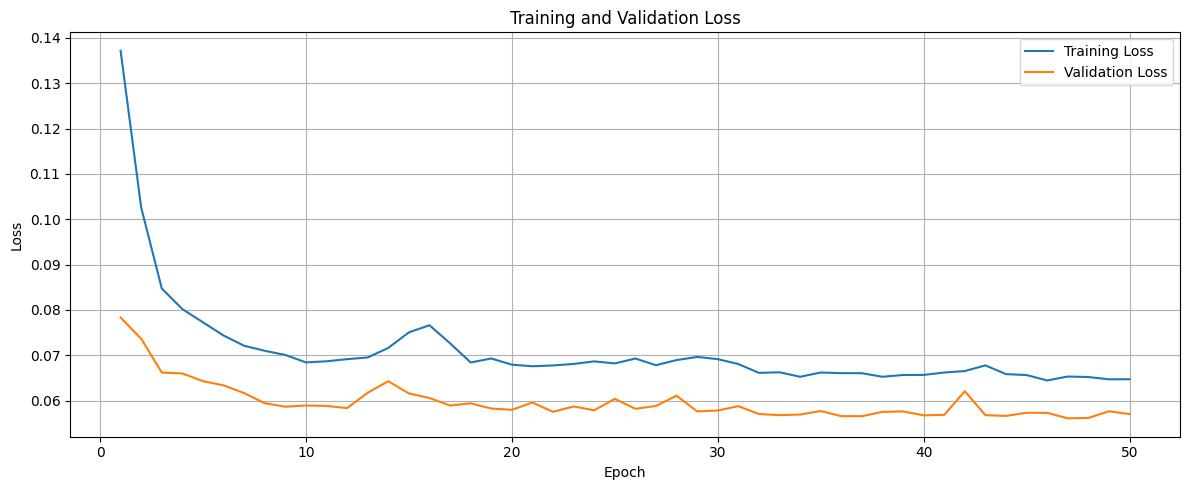

Model: "aod_GRUSeq2SeqReduction_11_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_86      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_40 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_86[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_41 (GRU)        │ [(None, 50),      │     22,800 │ gru_40[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_118 (Dense)   │ (None, 11)        │        561 │ gru_41[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_59    │ (None, 7, 11)     │          0 │ dense_118[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_42 (GRU)        │ (None, 7, 50)     │      9,450 │ repeat_vector_59… │
│                     │                   │            │ gru_41[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_43 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_42[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_91 │ (None, 7, 18)     │      1,818 │ gru_43[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 348,689 (1.33 MB)

 Trainable params: 116,229 (454.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 232,460 (908.05 KB)

None


Model: "aod_GRUSeq2SeqReduction_11_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_87 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_40 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_41 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 11)             │           561 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,361 (231.88 KB)

 Trainable params: 59,361 (231.88 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_11_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_88      │ (None, 7, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_132 (LSTM)     │ [(None, 64),      │     19,712 │ input_layer_88[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_60    │ (None, 1, 64)     │          0 │ lstm_132[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_133 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_60… │
│                     │                   │            │ lstm_132[0][1],   │
│                     │                   │            │ lstm_132[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 1, 64)     │          0 │ lstm_133[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_92 │ (None, 1, 32)     │      2,080 │ dropout_32[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_93 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,849 (214.25 KB)

 Trainable params: 54,849 (214.25 KB)

 Non-trainable params: 0 (0.00 B)

None


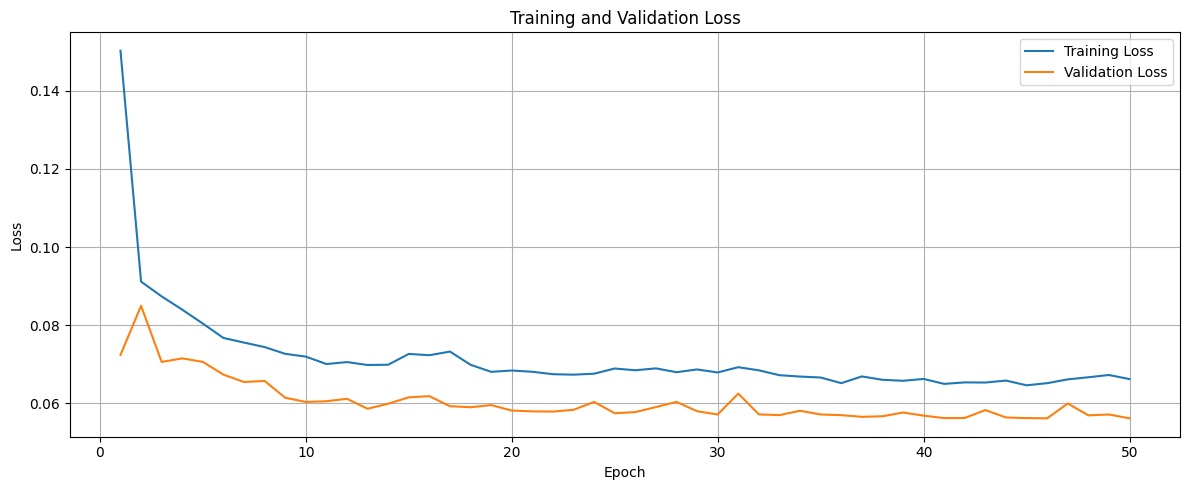

Model: "aod_GRUSeq2SeqReduction_12_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_89      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_44 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_89[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_45 (GRU)        │ [(None, 50),      │     22,800 │ gru_44[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_122 (Dense)   │ (None, 12)        │        612 │ gru_45[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_61    │ (None, 7, 12)     │          0 │ dense_122[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_46 (GRU)        │ (None, 7, 50)     │      9,600 │ repeat_vector_61… │
│                     │                   │            │ gru_45[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_47 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_46[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_94 │ (None, 7, 18)     │      1,818 │ gru_47[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 349,292 (1.33 MB)

 Trainable params: 116,430 (454.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 232,862 (909.62 KB)

None


Model: "aod_GRUSeq2SeqReduction_12_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_90 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_44 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_45 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,412 (232.08 KB)

 Trainable params: 59,412 (232.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_12_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_91      │ (None, 7, 13)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_134 (LSTM)     │ [(None, 64),      │     19,968 │ input_layer_91[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_62    │ (None, 1, 64)     │          0 │ lstm_134[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_135 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_62… │
│                     │                   │            │ lstm_134[0][1],   │
│                     │                   │            │ lstm_134[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 1, 64)     │          0 │ lstm_135[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_95 │ (None, 1, 32)     │      2,080 │ dropout_33[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_96 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,105 (215.25 KB)

 Trainable params: 55,105 (215.25 KB)

 Non-trainable params: 0 (0.00 B)

None


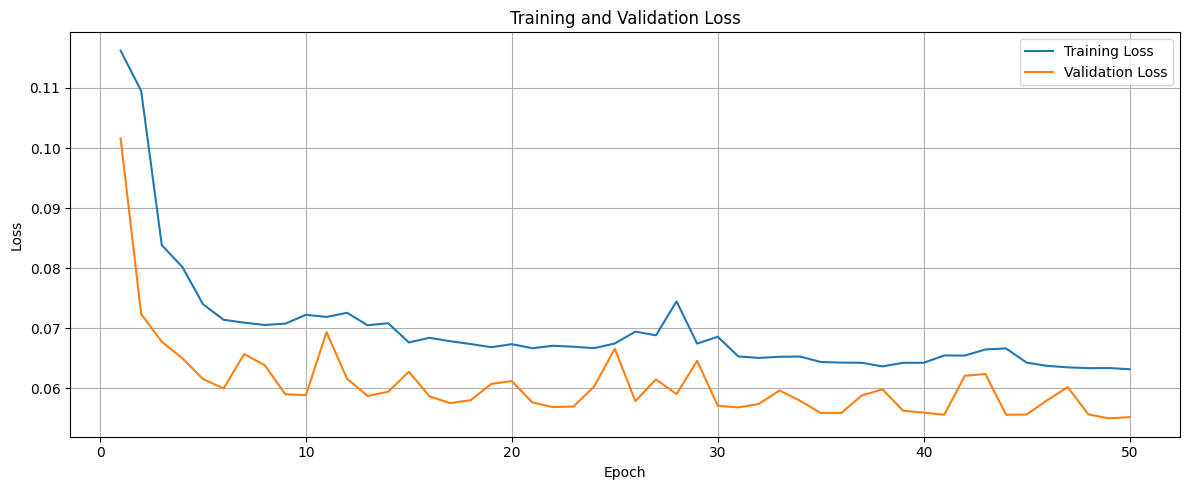

Model: "aod_GRUSeq2SeqReduction_13_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_92      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_48 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_92[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_49 (GRU)        │ [(None, 50),      │     22,800 │ gru_48[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_126 (Dense)   │ (None, 13)        │        663 │ gru_49[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_63    │ (None, 7, 13)     │          0 │ dense_126[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_50 (GRU)        │ (None, 7, 50)     │      9,750 │ repeat_vector_63… │
│                     │                   │            │ gru_49[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_51 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_50[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_97 │ (None, 7, 18)     │      1,818 │ gru_51[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 349,895 (1.33 MB)

 Trainable params: 116,631 (455.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 233,264 (911.19 KB)

None


Model: "aod_GRUSeq2SeqReduction_13_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_93 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_48 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_49 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,463 (232.28 KB)

 Trainable params: 59,463 (232.28 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_13_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_94      │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_136 (LSTM)     │ [(None, 64),      │     20,224 │ input_layer_94[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_64    │ (None, 1, 64)     │          0 │ lstm_136[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_137 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_64… │
│                     │                   │            │ lstm_136[0][1],   │
│                     │                   │            │ lstm_136[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 1, 64)     │          0 │ lstm_137[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_98 │ (None, 1, 32)     │      2,080 │ dropout_34[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_99 │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,361 (216.25 KB)

 Trainable params: 55,361 (216.25 KB)

 Non-trainable params: 0 (0.00 B)

None


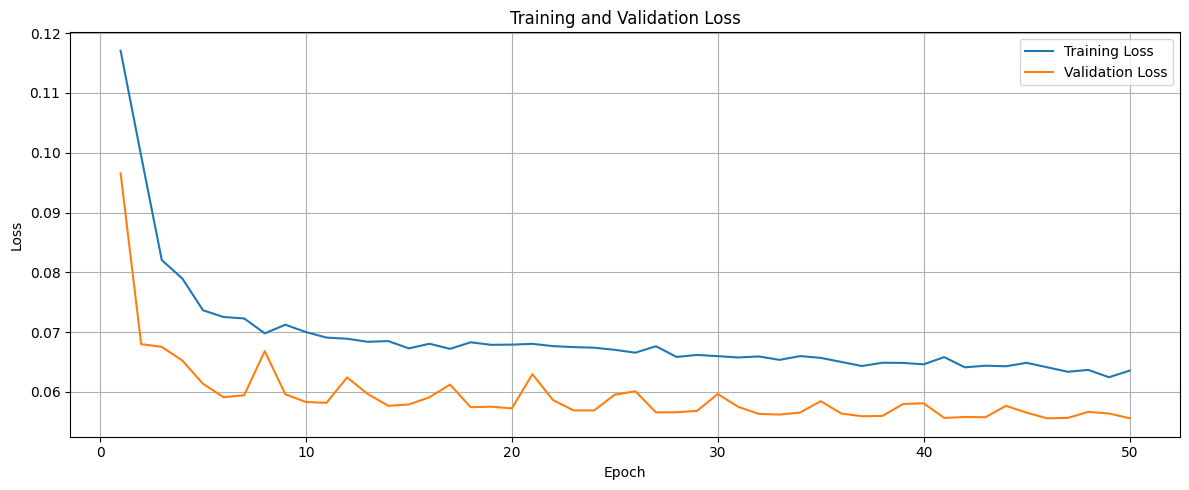

Model: "aod_GRUSeq2SeqReduction_14_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_95      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_52 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_95[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_53 (GRU)        │ [(None, 50),      │     22,800 │ gru_52[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_130 (Dense)   │ (None, 14)        │        714 │ gru_53[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_65    │ (None, 7, 14)     │          0 │ dense_130[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_54 (GRU)        │ (None, 7, 50)     │      9,900 │ repeat_vector_65… │
│                     │                   │            │ gru_53[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_55 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_54[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ gru_55[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 350,498 (1.34 MB)

 Trainable params: 116,832 (456.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 233,666 (912.76 KB)

None


Model: "aod_GRUSeq2SeqReduction_14_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_96 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_52 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_53 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,514 (232.48 KB)

 Trainable params: 59,514 (232.48 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_14_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_97      │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_138 (LSTM)     │ [(None, 64),      │     20,480 │ input_layer_97[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_66    │ (None, 1, 64)     │          0 │ lstm_138[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_139 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_66… │
│                     │                   │            │ lstm_138[0][1],   │
│                     │                   │            │ lstm_138[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 1, 64)     │          0 │ lstm_139[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_35[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,617 (217.25 KB)

 Trainable params: 55,617 (217.25 KB)

 Non-trainable params: 0 (0.00 B)

None


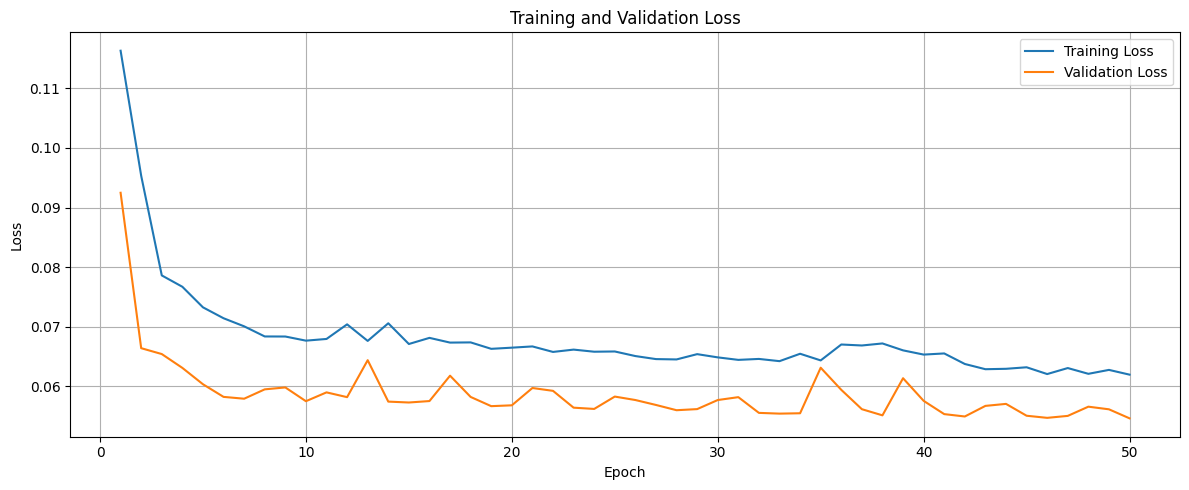

Model: "aod_GRUSeq2SeqReduction_15_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_98      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_56 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_98[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_57 (GRU)        │ [(None, 50),      │     22,800 │ gru_56[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_134 (Dense)   │ (None, 15)        │        765 │ gru_57[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_67    │ (None, 7, 15)     │          0 │ dense_134[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_58 (GRU)        │ (None, 7, 50)     │     10,050 │ repeat_vector_67… │
│                     │                   │            │ gru_57[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_59 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_58[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ gru_59[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 351,101 (1.34 MB)

 Trainable params: 117,033 (457.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,068 (914.33 KB)

None


Model: "aod_GRUSeq2SeqReduction_15_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_99 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_56 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_57 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,565 (232.68 KB)

 Trainable params: 59,565 (232.68 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_15_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_100     │ (None, 7, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_140 (LSTM)     │ [(None, 64),      │     20,736 │ input_layer_100[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_68    │ (None, 1, 64)     │          0 │ lstm_140[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_141 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_68… │
│                     │                   │            │ lstm_140[0][1],   │
│                     │                   │            │ lstm_140[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 1, 64)     │          0 │ lstm_141[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_36[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,873 (218.25 KB)

 Trainable params: 55,873 (218.25 KB)

 Non-trainable params: 0 (0.00 B)

None


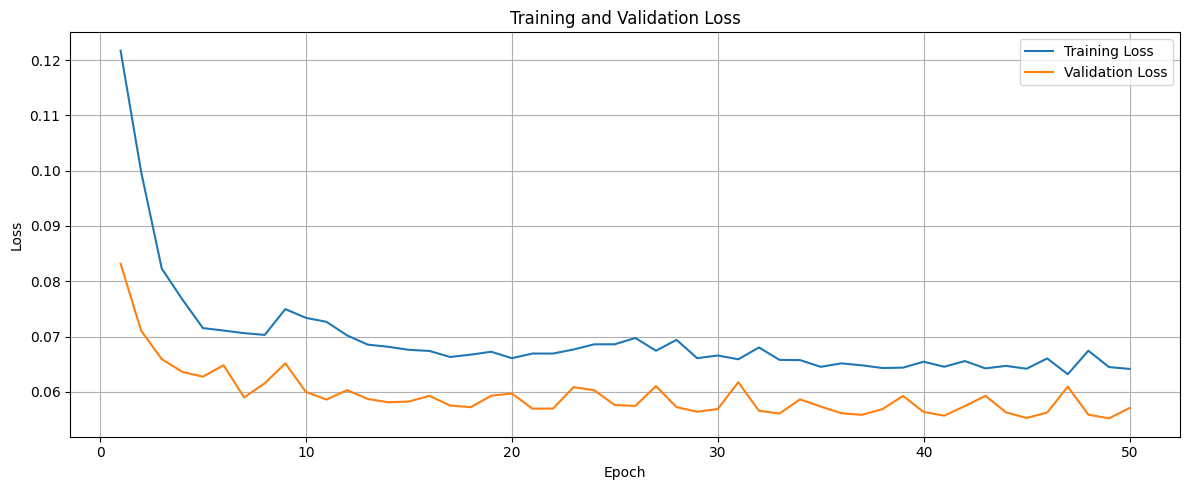

Model: "aod_GRUSeq2SeqReduction_16_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_101     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_60 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_101[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_61 (GRU)        │ [(None, 50),      │     22,800 │ gru_60[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_138 (Dense)   │ (None, 16)        │        816 │ gru_61[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_69    │ (None, 7, 16)     │          0 │ dense_138[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_62 (GRU)        │ (None, 7, 50)     │     10,200 │ repeat_vector_69… │
│                     │                   │            │ gru_61[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_63 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_62[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ gru_63[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 351,704 (1.34 MB)

 Trainable params: 117,234 (457.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,470 (915.90 KB)

None


Model: "aod_GRUSeq2SeqReduction_16_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_102 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_60 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_61 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,616 (232.88 KB)

 Trainable params: 59,616 (232.88 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_16_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_103     │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_142 (LSTM)     │ [(None, 64),      │     20,992 │ input_layer_103[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_70    │ (None, 1, 64)     │          0 │ lstm_142[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_143 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_70… │
│                     │                   │            │ lstm_142[0][1],   │
│                     │                   │            │ lstm_142[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 1, 64)     │          0 │ lstm_143[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_37[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,129 (219.25 KB)

 Trainable params: 56,129 (219.25 KB)

 Non-trainable params: 0 (0.00 B)

None


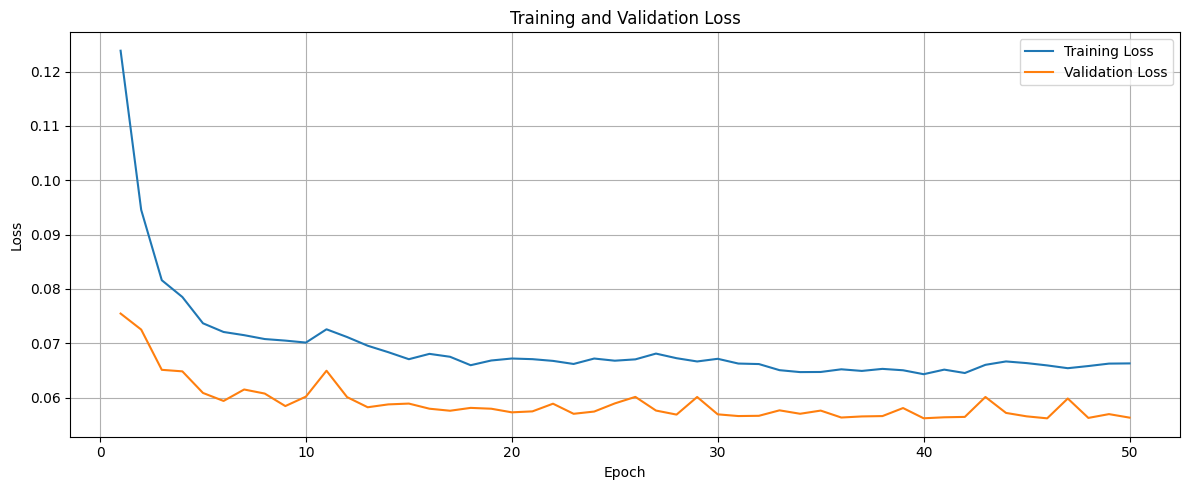

Model: "aod_GRUSeq2SeqReduction_17_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_104     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_64 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_104[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_65 (GRU)        │ [(None, 50),      │     22,800 │ gru_64[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_142 (Dense)   │ (None, 17)        │        867 │ gru_65[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_71    │ (None, 7, 17)     │          0 │ dense_142[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_66 (GRU)        │ (None, 7, 50)     │     10,350 │ repeat_vector_71… │
│                     │                   │            │ gru_65[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_67 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_66[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │      1,818 │ gru_67[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 352,307 (1.34 MB)

 Trainable params: 117,435 (458.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,872 (917.47 KB)

None


Model: "aod_GRUSeq2SeqReduction_17_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_105 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_64 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_65 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,667 (233.07 KB)

 Trainable params: 59,667 (233.07 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_17_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_106     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_144 (LSTM)     │ [(None, 64),      │     21,248 │ input_layer_106[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_72    │ (None, 1, 64)     │          0 │ lstm_144[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_145 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_72… │
│                     │                   │            │ lstm_144[0][1],   │
│                     │                   │            │ lstm_144[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 1, 64)     │          0 │ lstm_145[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_38[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,385 (220.25 KB)

 Trainable params: 56,385 (220.25 KB)

 Non-trainable params: 0 (0.00 B)

None


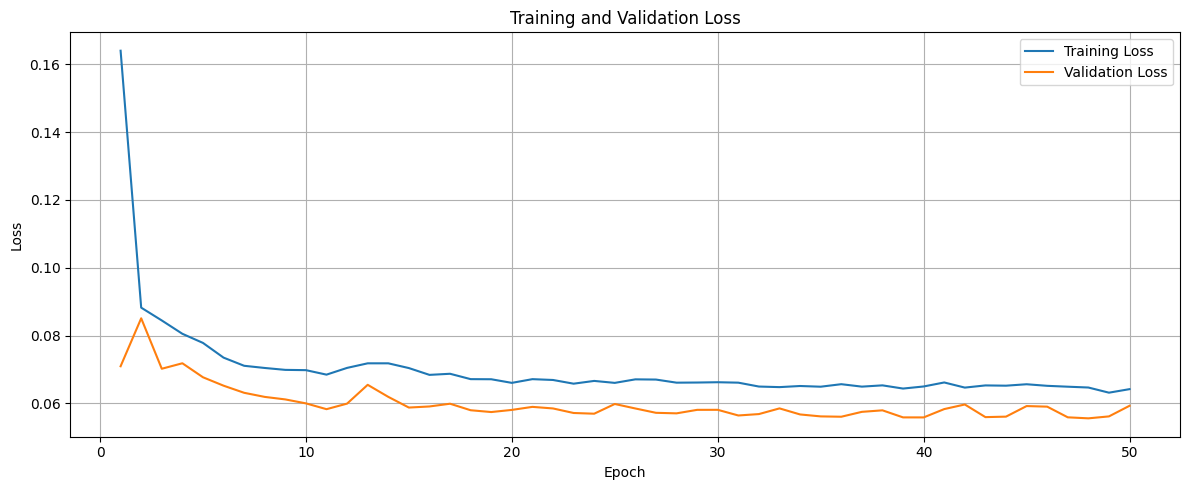

N = 10 - mae = 4.249633359645226, mse = 33.040019463969166, r2 = -1.1130834863700807
N = 11 - mae = 4.184871430982797, mse = 34.20055109931083, r2 = -0.8123075773101294
N = 12 - mae = 4.148434447794672, mse = 33.19187839601639, r2 = -0.33138283704815463
N = 13 - mae = 4.154221929567401, mse = 32.968479961929624, r2 = -0.4903626922236628
N = 14 - mae = 4.10953826101724, mse = 32.15117867993318, r2 = -0.4615525998156209
N = 15 - mae = 4.241931567828882, mse = 32.45881935379316, r2 = -0.5539756767676265
N = 16 - mae = 4.176102494221854, mse = 33.95806366123946, r2 = -0.6421163622541786
N = 17 - mae = 4.444521663146482, mse = 33.68295201799573, r2 = -0.646831644461701


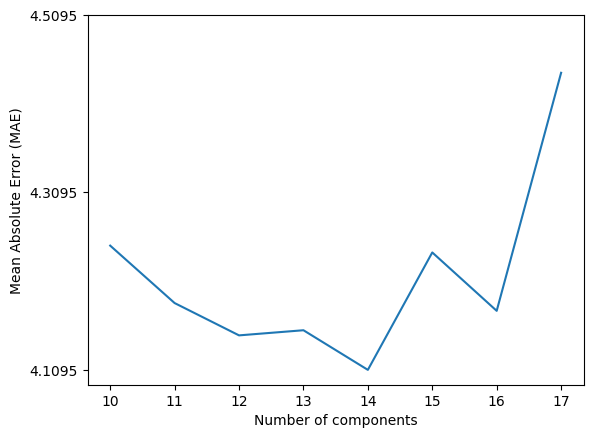

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


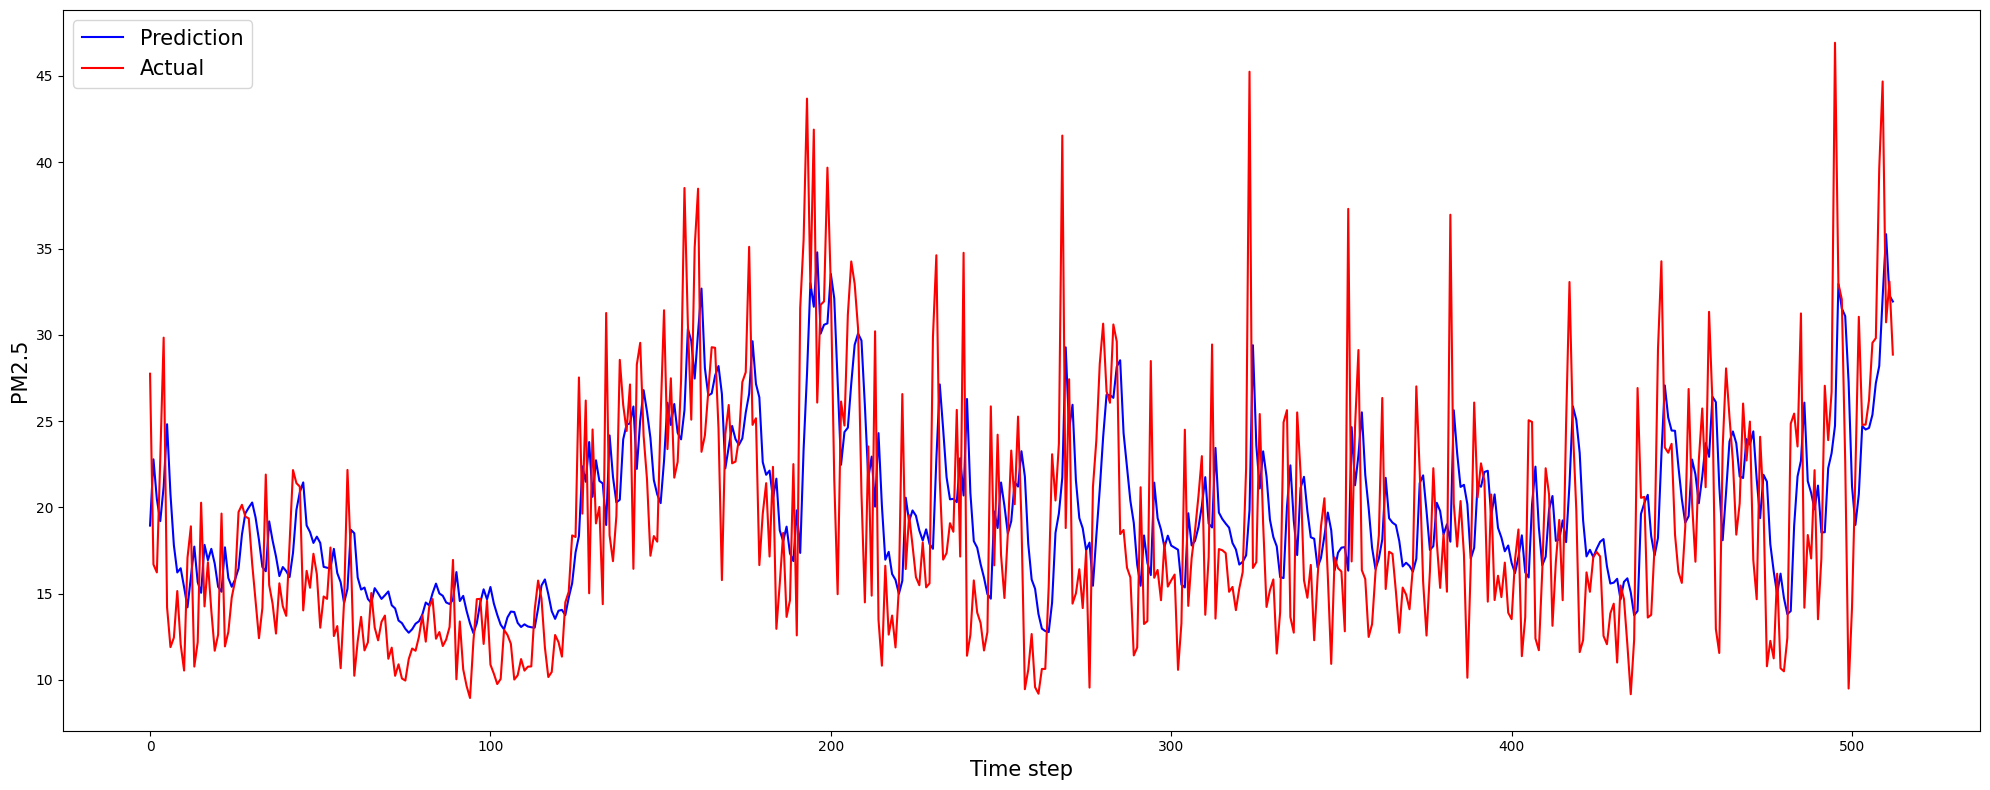

with_pm25_3km dim_reduction_method dim_after_reduction prediction       mae  \
0           Yes                 None                 N/A       LSTM  4.750573   
1            No                 None                 N/A       LSTM  7.395319   
2           Yes         LSTM-Seq2Seq                  18       LSTM  4.856416   
3            No         LSTM-Seq2Seq                  17       LSTM  4.513865   
4           Yes          GRU-Seq2Seq                  18       LSTM  4.176988   
5            No          GRU-Seq2Seq                  17       LSTM  4.444522   

         mse        r2  
0  36.145157 -1.044288  
1  74.086617 -2.062693  
2  38.015234 -8.149209  
3  38.798220 -5.759418  
4  32.625588 -0.484241  
5  33.682952 -0.646832

In [43]:
loopresults = generate_loopresults(RANGE_OF_DIMENSION_NO_PM25_3KM, GRUSeq2SeqReduction, LSTMPrediction, X_aod_no_pm25_3km_scaled, y_aod_scaled, aod_label_scaler, False)
best_mae, best_mse, best_r2, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = choose_the_best(loopresults)

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["GRU-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['mse'] += [best_mse]
evaluation_board['r2'] += [best_r2]
evaluation_board['with_pm25_3km'] += ["No"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data (no pm25_3km)

In [44]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_grus2s_reduced_no_pm25_3km = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_grus2s_reduced_no_pm25_3km.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_grus2s_reduced_2021_2022_no_pm25_3km.csv"))
df_grus2s_reduced_no_pm25_3km

aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2021-01-01       0.059399       0.049636       0.061489       0.156121   
2021-01-02       0.059399       0.049636       0.061489       0.156121   
2021-01-03       0.059528       0.049738       0.061748       0.155386   
2021-01-04       0.059666       0.049783       0.062027       0.155107   
2021-01-05       0.059656       0.049894       0.062226       0.155546   
...                   ...            ...            ...            ...   
2022-12-27       0.054966       0.036644       0.086049       0.060381   
2022-12-28       0.054937       0.036690       0.086598       0.060244   
2022-12-29       0.055005       0.036884       0.086372       0.060733   
2022-12-30       0.054978       0.036956       0.086001       0.061225   
2022-12-31       0.054834       0.036774       0.085404       0.061449   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2021-01-01       0.035097       0.023685       0.031578       0.062009   
2021-01-02       0.035097       0.023685       0.031578       0.062009   
2021-01-03       0.035184       0.023846       0.031740       0.061973   
2021-01-04       0.035206       0.024016       0.031874       0.061728   
2021-01-05       0.035110       0.024079       0.031827       0.061446   
...                   ...            ...            ...            ...   
2022-12-27       0.058458       0.022848       0.063333       0.100591   
2022-12-28       0.057957       0.022728       0.062946       0.100658   
2022-12-29       0.057946       0.022857       0.062913       0.100485   
2022-12-30       0.057772       0.022878       0.062793       0.100834   
2022-12-31       0.058209       0.022867       0.063083       0.100966   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2021-01-01       0.030067        0.057801        0.019722        0.101772   
2021-01-02       0.030067        0.057801        0.019722        0.101772   
2021-01-03       0.030269        0.057899        0.019852        0.101740   
2021-01-04       0.030486        0.058051        0.019937        0.102085   
2021-01-05       0.030599        0.057983        0.019931        0.102556   
...                   ...             ...             ...             ...   
2022-12-27       0.024373        0.037394        0.048536        0.035046   
2022-12-28       0.024535        0.037371        0.048345        0.035215   
2022-12-29       0.024552        0.037502        0.048310        0.035324   
2022-12-30       0.024331        0.037534        0.048355        0.035186   
2022-12-31       0.023976        0.037406        0.048354        0.034868   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2021-01-01        0.038251        0.044002        0.090949        0.109249   
2021-01-02        0.038251        0.044002        0.090949        0.109249   
2021-01-03        0.038454        0.044116        0.090623        0.108512   
2021-01-04        0.038607        0.044063        0.089915        0.107884   
2021-01-05        0.038597        0.043790        0.089250        0.107883   
...                    ...             ...             ...             ...   
2022-12-27        0.052210        0.096256        0.102925        0.061807   
2022-12-28        0.052236        0.095981        0.103855        0.061388   
2022-12-29        0.052192        0.095691        0.103396        0.061646   
2022-12-30        0.051943        0.095806        0.103516        0.061797   
2022-12-31        0.051776        0.096587        0.103276        0.062262   

            aod_feature_17  station  
time                           

In [45]:
# Prepare the reduced data with additional pm25_3km and predicted pm25 values
df_grus2s_reduced_augmented = augmentReducedData(df_grus2s_reduced_no_pm25_3km, y_aod_scaled, aod_pm25_3km_column, aod_label_scaler)
df_grus2s_reduced_augmented.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_grus2s_reduced_2021_2022_no_pm25_3km_with_raw_pm25_3km_and_prediced_pm25.csv"))
df_grus2s_reduced_augmented

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


4.982758732169515


aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2021-01-01       0.059399       0.049636       0.061489       0.156121   
2021-01-02       0.059399       0.049636       0.061489       0.156121   
2021-01-03       0.059528       0.049738       0.061748       0.155386   
2021-01-04       0.059666       0.049783       0.062027       0.155107   
2021-01-05       0.059656       0.049894       0.062226       0.155546   
...                   ...            ...            ...            ...   
2022-12-27       0.054966       0.036644       0.086049       0.060381   
2022-12-28       0.054937       0.036690       0.086598       0.060244   
2022-12-29       0.055005       0.036884       0.086372       0.060733   
2022-12-30       0.054978       0.036956       0.086001       0.061225   
2022-12-31       0.054834       0.036774       0.085404       0.061449   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2021-01-01       0.035097       0.023685       0.031578       0.062009   
2021-01-02       0.035097       0.023685       0.031578       0.062009   
2021-01-03       0.035184       0.023846       0.031740       0.061973   
2021-01-04       0.035206       0.024016       0.031874       0.061728   
2021-01-05       0.035110       0.024079       0.031827       0.061446   
...                   ...            ...            ...            ...   
2022-12-27       0.058458       0.022848       0.063333       0.100591   
2022-12-28       0.057957       0.022728       0.062946       0.100658   
2022-12-29       0.057946       0.022857       0.062913       0.100485   
2022-12-30       0.057772       0.022878       0.062793       0.100834   
2022-12-31       0.058209       0.022867       0.063083       0.100966   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2021-01-01       0.030067        0.057801        0.019722        0.101772   
2021-01-02       0.030067        0.057801        0.019722        0.101772   
2021-01-03       0.030269        0.057899        0.019852        0.101740   
2021-01-04       0.030486        0.058051        0.019937        0.102085   
2021-01-05       0.030599        0.057983        0.019931        0.102556   
...                   ...             ...             ...             ...   
2022-12-27       0.024373        0.037394        0.048536        0.035046   
2022-12-28       0.024535        0.037371        0.048345        0.035215   
2022-12-29       0.024552        0.037502        0.048310        0.035324   
2022-12-30       0.024331        0.037534        0.048355        0.035186   
2022-12-31       0.023976        0.037406        0.048354        0.034868   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2021-01-01        0.038251        0.044002        0.090949        0.109249   
2021-01-02        0.038251        0.044002        0.090949        0.109249   
2021-01-03        0.038454        0.044116        0.090623        0.108512   
2021-01-04        0.038607        0.044063        0.089915        0.107884   
2021-01-05        0.038597        0.043790        0.089250        0.107883   
...                    ...             ...             ...             ...   
2022-12-27        0.052210        0.096256        0.102925        0.061807   
2022-12-28        0.052236        0.095981        0.103855        0.061388   
2022-12-29        0.052192        0.095691        0.103396        0.061646   
2022-12-30        0.051943        0.095806        0.103516        0.061797   
2022-12-31        0.051776        0.096587        0.103276        0.062262   

            aod_feature_17  station   pm25_3km  hiep_predicted_pm25  

### Prediction + CNN-LSTM Seq2seq

#### Doing the loop

Could not load symbol cuFuncGetName. Error: /lib/x86_64-linux-gnu/libcuda.so.1: undefined symbol: cuFuncGetName


Model: "aod_CNNLSTMSeq2SeqReduction_10_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_108     │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5, 24)     │      1,392 │ input_layer_108[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 3, 12)     │        876 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1, 12)     │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12)        │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_74    │ (None, 7, 12)     │          0 │ flatten[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_148 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_74… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_148 (Dense)   │ (None, 10)        │        510 │ lstm_148[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_75    │ (None, 7, 10)     │          0 │ dense_148[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_149 (LSTM)     │ (None, 7, 50)     │     12,200 │ repeat_vector_75… │
│                     │                   │            │ lstm_148[0][1],   │
│                     │                   │            │ lstm_148[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_149[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 19)     │        475 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 87,833 (343.10 KB)

 Trainable params: 29,277 (114.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,556 (228.74 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_10_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_109 (InputLayer)    │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 5, 24)          │         1,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_74 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_148 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,378 (60.07 KB)

 Trainable params: 15,378 (60.07 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_10_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_110     │ (None, 7, 11)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_150 (LSTM)     │ [(None, 64),      │     19,456 │ input_layer_110[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_76    │ (None, 1, 64)     │          0 │ lstm_150[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_151 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_76… │
│                     │                   │            │ lstm_150[0][1],   │
│                     │                   │            │ lstm_150[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 1, 64)     │          0 │ lstm_151[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_40[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,593 (213.25 KB)

 Trainable params: 54,593 (213.25 KB)

 Non-trainable params: 0 (0.00 B)

None


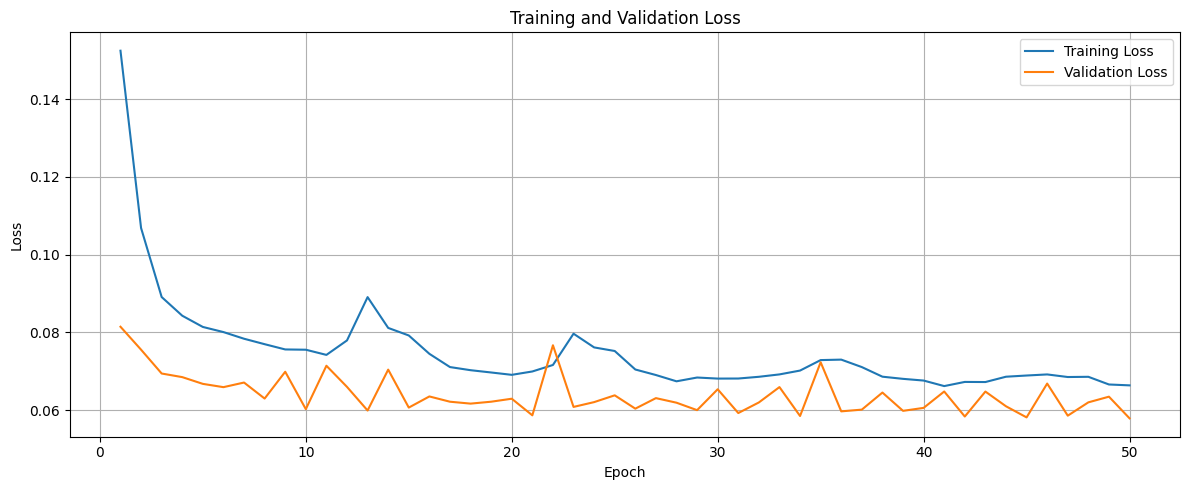

Model: "aod_CNNLSTMSeq2SeqReduction_11_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_111     │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 5, 24)     │      1,392 │ input_layer_111[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 3, 12)     │        876 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 1, 12)     │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_77    │ (None, 7, 12)     │          0 │ flatten_1[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_152 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_77… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_153 (Dense)   │ (None, 11)        │        561 │ lstm_152[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_78    │ (None, 7, 11)     │          0 │ dense_153[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_153 (LSTM)     │ (None, 7, 50)     │     12,400 │ repeat_vector_78… │
│                     │                   │            │ lstm_152[0][1],   │
│                     │                   │            │ lstm_152[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_153[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 19)     │        475 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 88,586 (346.04 KB)

 Trainable params: 29,528 (115.34 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,058 (230.70 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_11_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_112 (InputLayer)    │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5, 24)          │         1,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_77 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_152 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 11)             │           561 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,429 (60.27 KB)

 Trainable params: 15,429 (60.27 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_11_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_113     │ (None, 7, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_154 (LSTM)     │ [(None, 64),      │     19,712 │ input_layer_113[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_79    │ (None, 1, 64)     │          0 │ lstm_154[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_155 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_79… │
│                     │                   │            │ lstm_154[0][1],   │
│                     │                   │            │ lstm_154[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 1, 64)     │          0 │ lstm_155[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_41[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,849 (214.25 KB)

 Trainable params: 54,849 (214.25 KB)

 Non-trainable params: 0 (0.00 B)

None


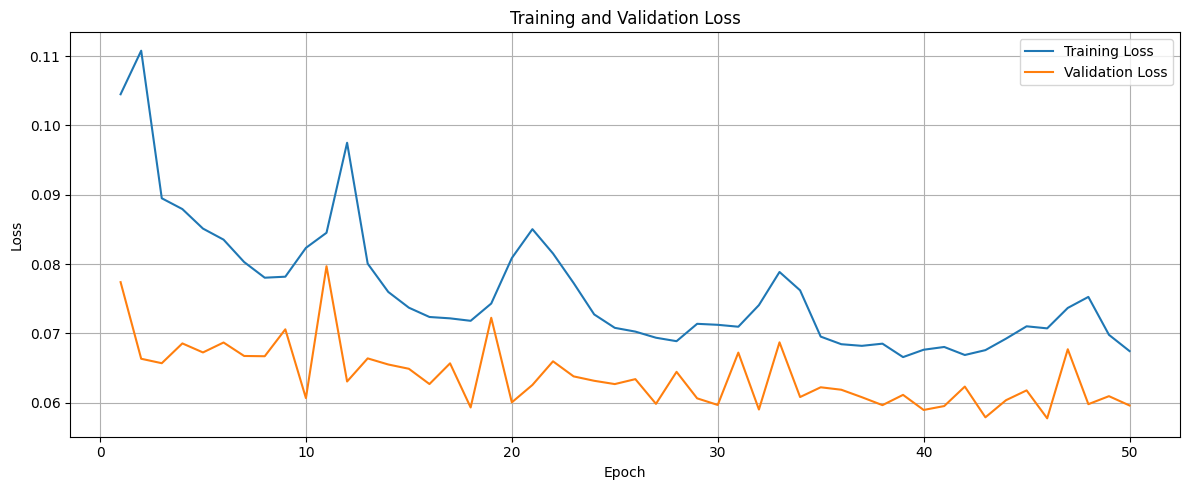

Model: "aod_CNNLSTMSeq2SeqReduction_12_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_114     │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 5, 24)     │      1,392 │ input_layer_114[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 3, 12)     │        876 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 1, 12)     │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_80    │ (None, 7, 12)     │          0 │ flatten_2[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_156 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_80… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_158 (Dense)   │ (None, 12)        │        612 │ lstm_156[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_81    │ (None, 7, 12)     │          0 │ dense_158[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_157 (LSTM)     │ (None, 7, 50)     │     12,600 │ repeat_vector_81… │
│                     │                   │            │ lstm_156[0][1],   │
│                     │                   │            │ lstm_156[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_157[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 19)     │        475 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,339 (348.98 KB)

 Trainable params: 29,779 (116.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,560 (232.66 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_12_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_115 (InputLayer)    │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 5, 24)          │         1,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_80 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_156 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,480 (60.47 KB)

 Trainable params: 15,480 (60.47 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_12_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_116     │ (None, 7, 13)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_158 (LSTM)     │ [(None, 64),      │     19,968 │ input_layer_116[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_82    │ (None, 1, 64)     │          0 │ lstm_158[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_159 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_82… │
│                     │                   │            │ lstm_158[0][1],   │
│                     │                   │            │ lstm_158[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 1, 64)     │          0 │ lstm_159[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_42[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,105 (215.25 KB)

 Trainable params: 55,105 (215.25 KB)

 Non-trainable params: 0 (0.00 B)

None


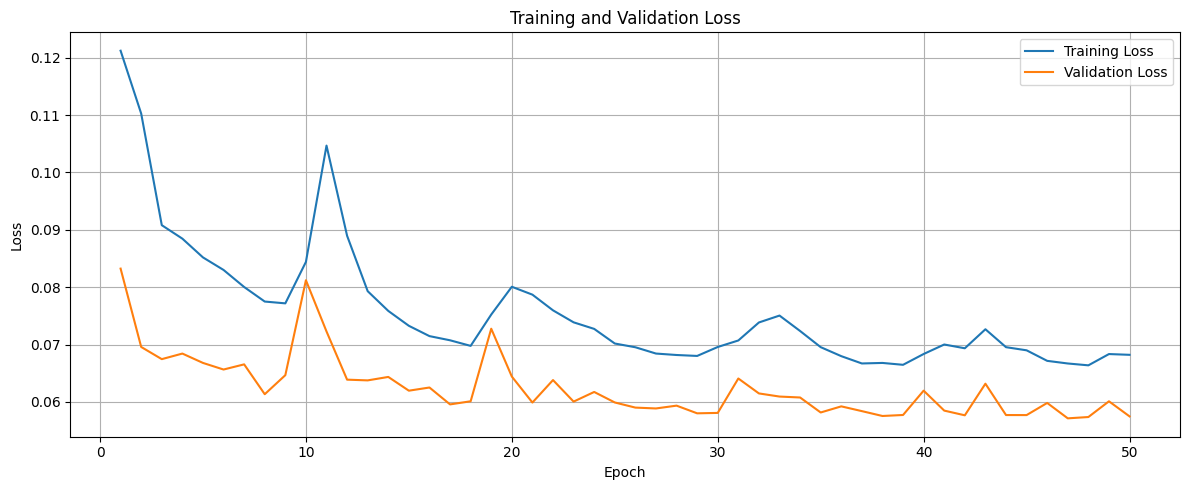

Model: "aod_CNNLSTMSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_117     │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 5, 24)     │      1,392 │ input_layer_117[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 3, 12)     │        876 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 1, 12)     │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_83    │ (None, 7, 12)     │          0 │ flatten_3[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_160 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_83… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_163 (Dense)   │ (None, 13)        │        663 │ lstm_160[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_84    │ (None, 7, 13)     │          0 │ dense_163[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_161 (LSTM)     │ (None, 7, 50)     │     12,800 │ repeat_vector_84… │
│                     │                   │            │ lstm_160[0][1],   │
│                     │                   │            │ lstm_160[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_161[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 19)     │        475 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 90,092 (351.93 KB)

 Trainable params: 30,030 (117.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 60,062 (234.62 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_13_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_118 (InputLayer)    │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 5, 24)          │         1,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_83 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_160 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,531 (60.67 KB)

 Trainable params: 15,531 (60.67 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_119     │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_162 (LSTM)     │ [(None, 64),      │     20,224 │ input_layer_119[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_85    │ (None, 1, 64)     │          0 │ lstm_162[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_163 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_85… │
│                     │                   │            │ lstm_162[0][1],   │
│                     │                   │            │ lstm_162[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 1, 64)     │          0 │ lstm_163[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_43[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,361 (216.25 KB)

 Trainable params: 55,361 (216.25 KB)

 Non-trainable params: 0 (0.00 B)

None


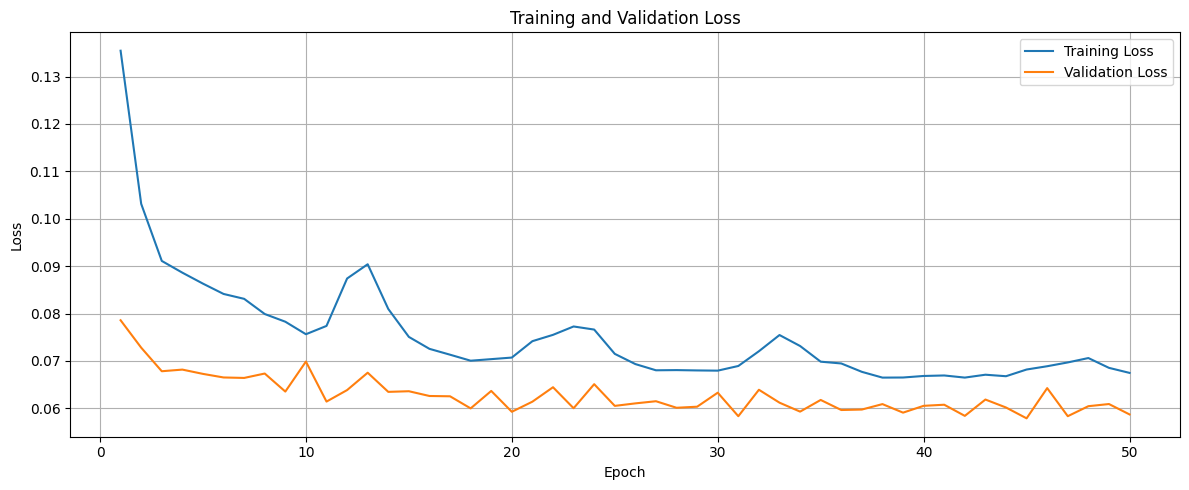

Model: "aod_CNNLSTMSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_120     │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 5, 24)     │      1,392 │ input_layer_120[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 3, 12)     │        876 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 1, 12)     │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_86    │ (None, 7, 12)     │          0 │ flatten_4[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_164 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_86… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_168 (Dense)   │ (None, 14)        │        714 │ lstm_164[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_87    │ (None, 7, 14)     │          0 │ dense_168[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_165 (LSTM)     │ (None, 7, 50)     │     13,000 │ repeat_vector_87… │
│                     │                   │            │ lstm_164[0][1],   │
│                     │                   │            │ lstm_164[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_165[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 19)     │        475 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 90,845 (354.87 KB)

 Trainable params: 30,281 (118.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 60,564 (236.58 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_121 (InputLayer)    │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 5, 24)          │         1,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_86 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_164 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_168 (Dense)               │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,582 (60.87 KB)

 Trainable params: 15,582 (60.87 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_122     │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_166 (LSTM)     │ [(None, 64),      │     20,480 │ input_layer_122[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_88    │ (None, 1, 64)     │          0 │ lstm_166[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_167 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_88… │
│                     │                   │            │ lstm_166[0][1],   │
│                     │                   │            │ lstm_166[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 1, 64)     │          0 │ lstm_167[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_44[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,617 (217.25 KB)

 Trainable params: 55,617 (217.25 KB)

 Non-trainable params: 0 (0.00 B)

None


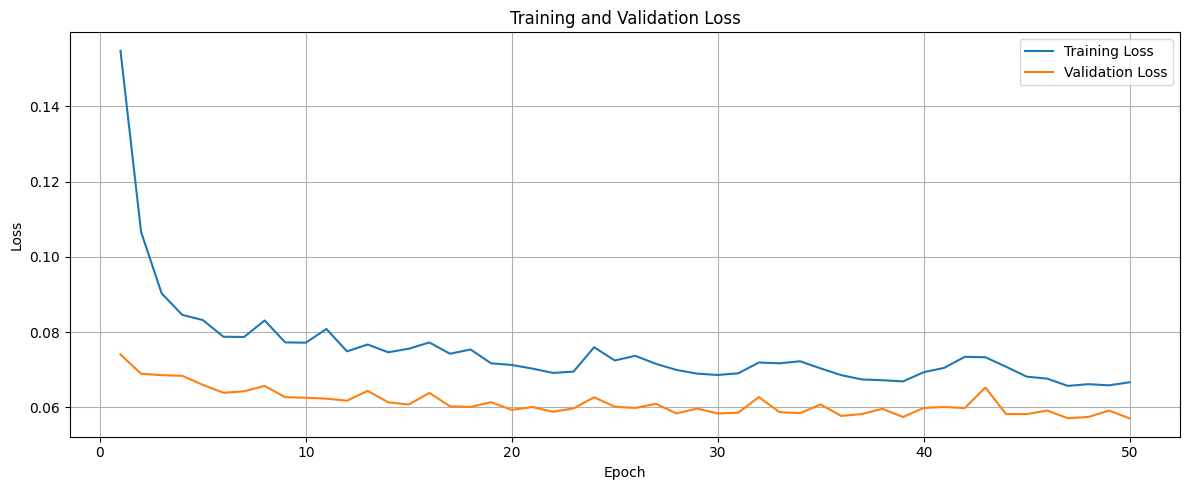

Model: "aod_CNNLSTMSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_123     │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 5, 24)     │      1,392 │ input_layer_123[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 1, 12)     │          0 │ conv1d_11[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_89    │ (None, 7, 12)     │          0 │ flatten_5[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_168 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_89… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_173 (Dense)   │ (None, 15)        │        765 │ lstm_168[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_90    │ (None, 7, 15)     │          0 │ dense_173[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_169 (LSTM)     │ (None, 7, 50)     │     13,200 │ repeat_vector_90… │
│                     │                   │            │ lstm_168[0][1],   │
│                     │                   │            │ lstm_168[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_169[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 19)     │        475 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,598 (357.81 KB)

 Trainable params: 30,532 (119.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,066 (238.54 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_124 (InputLayer)    │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 5, 24)          │         1,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_89 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_168 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,633 (61.07 KB)

 Trainable params: 15,633 (61.07 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_125     │ (None, 7, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_170 (LSTM)     │ [(None, 64),      │     20,736 │ input_layer_125[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_91    │ (None, 1, 64)     │          0 │ lstm_170[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_171 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_91… │
│                     │                   │            │ lstm_170[0][1],   │
│                     │                   │            │ lstm_170[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 1, 64)     │          0 │ lstm_171[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_45[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,873 (218.25 KB)

 Trainable params: 55,873 (218.25 KB)

 Non-trainable params: 0 (0.00 B)

None


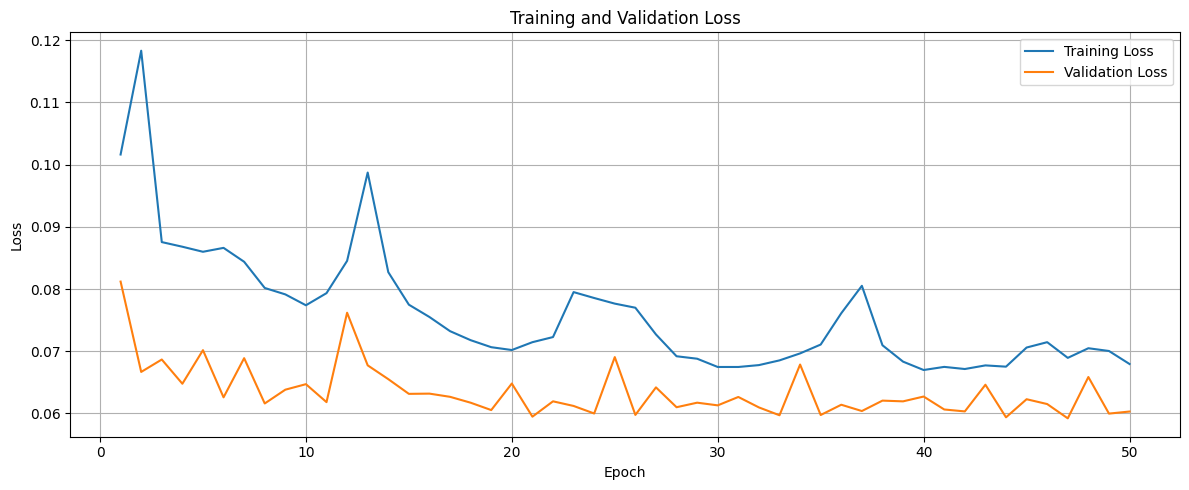

Model: "aod_CNNLSTMSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_126     │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 5, 24)     │      1,392 │ input_layer_126[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 1, 12)     │          0 │ conv1d_13[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_92    │ (None, 7, 12)     │          0 │ flatten_6[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_172 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_92… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_178 (Dense)   │ (None, 16)        │        816 │ lstm_172[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_93    │ (None, 7, 16)     │          0 │ dense_178[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_173 (LSTM)     │ (None, 7, 50)     │     13,400 │ repeat_vector_93… │
│                     │                   │            │ lstm_172[0][1],   │
│                     │                   │            │ lstm_172[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_173[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 19)     │        475 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,351 (360.75 KB)

 Trainable params: 30,783 (120.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,568 (240.50 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_127 (InputLayer)    │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 5, 24)          │         1,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_92 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_172 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,684 (61.27 KB)

 Trainable params: 15,684 (61.27 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_128     │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_174 (LSTM)     │ [(None, 64),      │     20,992 │ input_layer_128[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_94    │ (None, 1, 64)     │          0 │ lstm_174[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_175 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_94… │
│                     │                   │            │ lstm_174[0][1],   │
│                     │                   │            │ lstm_174[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_46          │ (None, 1, 64)     │          0 │ lstm_175[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_46[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,129 (219.25 KB)

 Trainable params: 56,129 (219.25 KB)

 Non-trainable params: 0 (0.00 B)

None


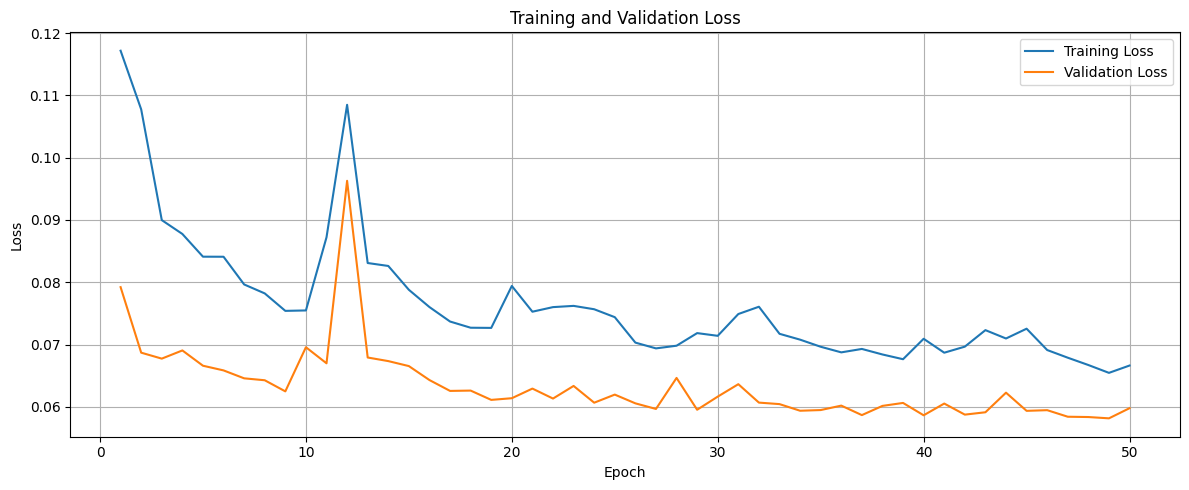

Model: "aod_CNNLSTMSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_129     │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 5, 24)     │      1,392 │ input_layer_129[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 1, 12)     │          0 │ conv1d_15[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_95    │ (None, 7, 12)     │          0 │ flatten_7[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_176 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_95… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_183 (Dense)   │ (None, 17)        │        867 │ lstm_176[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_96    │ (None, 7, 17)     │          0 │ dense_183[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_177 (LSTM)     │ (None, 7, 50)     │     13,600 │ repeat_vector_96… │
│                     │                   │            │ lstm_176[0][1],   │
│                     │                   │            │ lstm_176[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_177[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 19)     │        475 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 93,104 (363.69 KB)

 Trainable params: 31,034 (121.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,070 (242.46 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_130 (InputLayer)    │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 5, 24)          │         1,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_95 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_176 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,735 (61.46 KB)

 Trainable params: 15,735 (61.46 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_131     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_178 (LSTM)     │ [(None, 64),      │     21,248 │ input_layer_131[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_97    │ (None, 1, 64)     │          0 │ lstm_178[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_179 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_97… │
│                     │                   │            │ lstm_178[0][1],   │
│                     │                   │            │ lstm_178[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 1, 64)     │          0 │ lstm_179[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_47[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,385 (220.25 KB)

 Trainable params: 56,385 (220.25 KB)

 Non-trainable params: 0 (0.00 B)

None


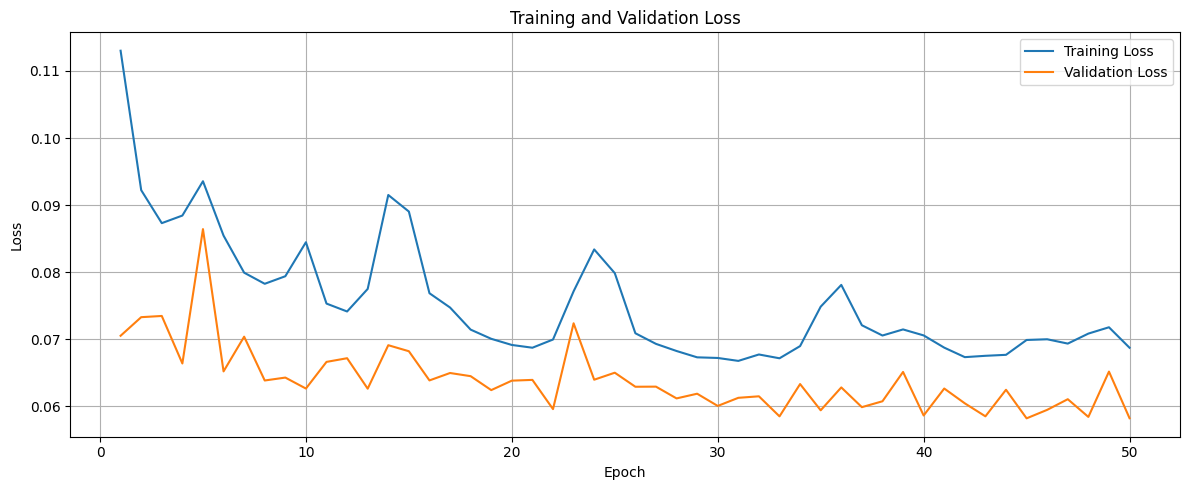

Model: "aod_CNNLSTMSeq2SeqReduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_132     │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 5, 24)     │      1,392 │ input_layer_132[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 1, 12)     │          0 │ conv1d_17[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_98    │ (None, 7, 12)     │          0 │ flatten_8[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_180 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_98… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_188 (Dense)   │ (None, 18)        │        918 │ lstm_180[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_99    │ (None, 7, 18)     │          0 │ dense_188[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_181 (LSTM)     │ (None, 7, 50)     │     13,800 │ repeat_vector_99… │
│                     │                   │            │ lstm_180[0][1],   │
│                     │                   │            │ lstm_180[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_181[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 19)     │        475 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 93,857 (366.63 KB)

 Trainable params: 31,285 (122.21 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,572 (244.43 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_18_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_133 (InputLayer)    │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 5, 24)          │         1,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_98 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_180 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,786 (61.66 KB)

 Trainable params: 15,786 (61.66 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_134     │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_182 (LSTM)     │ [(None, 64),      │     21,504 │ input_layer_134[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_100   │ (None, 1, 64)     │          0 │ lstm_182[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_183 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_10… │
│                     │                   │            │ lstm_182[0][1],   │
│                     │                   │            │ lstm_182[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 1, 64)     │          0 │ lstm_183[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_48[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,641 (221.25 KB)

 Trainable params: 56,641 (221.25 KB)

 Non-trainable params: 0 (0.00 B)

None


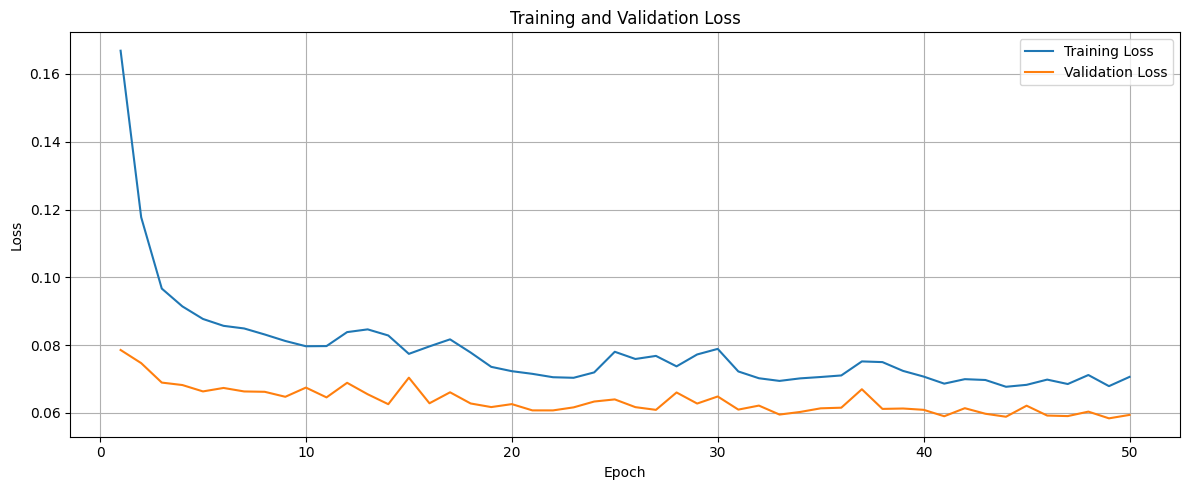

N = 10 - mae = 4.404779827968379, mse = 34.48425240139578, r2 = -1.9383357001880497
N = 11 - mae = 4.486003506070385, mse = 34.46714443260811, r2 = -2.1834863842173475
N = 12 - mae = 4.249481980752742, mse = 34.25382471087744, r2 = -1.223737285505552
N = 13 - mae = 4.419960307736783, mse = 34.911097051783614, r2 = -2.5696473405625917
N = 14 - mae = 4.300246830846349, mse = 37.303442068409105, r2 = -1.834064046443466
N = 15 - mae = 4.625317670208912, mse = 34.62546555055639, r2 = -1.9652955516195632
N = 16 - mae = 4.644171299805924, mse = 44.769263129925896, r2 = -3.5628330301254865
N = 17 - mae = 4.350427897456621, mse = 34.779643520983726, r2 = -2.235514586446715
N = 18 - mae = 4.376068860353957, mse = 35.69494675038264, r2 = -2.489013685245866


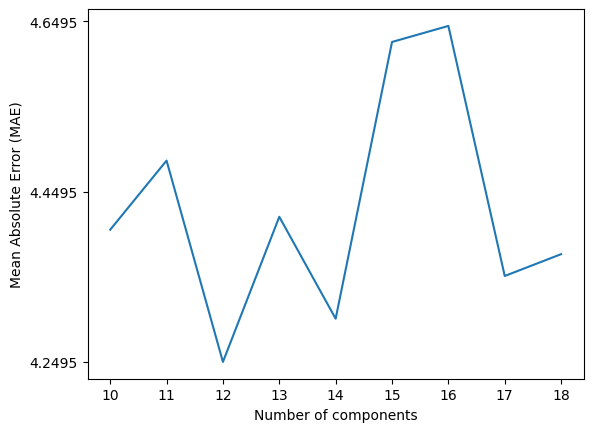

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


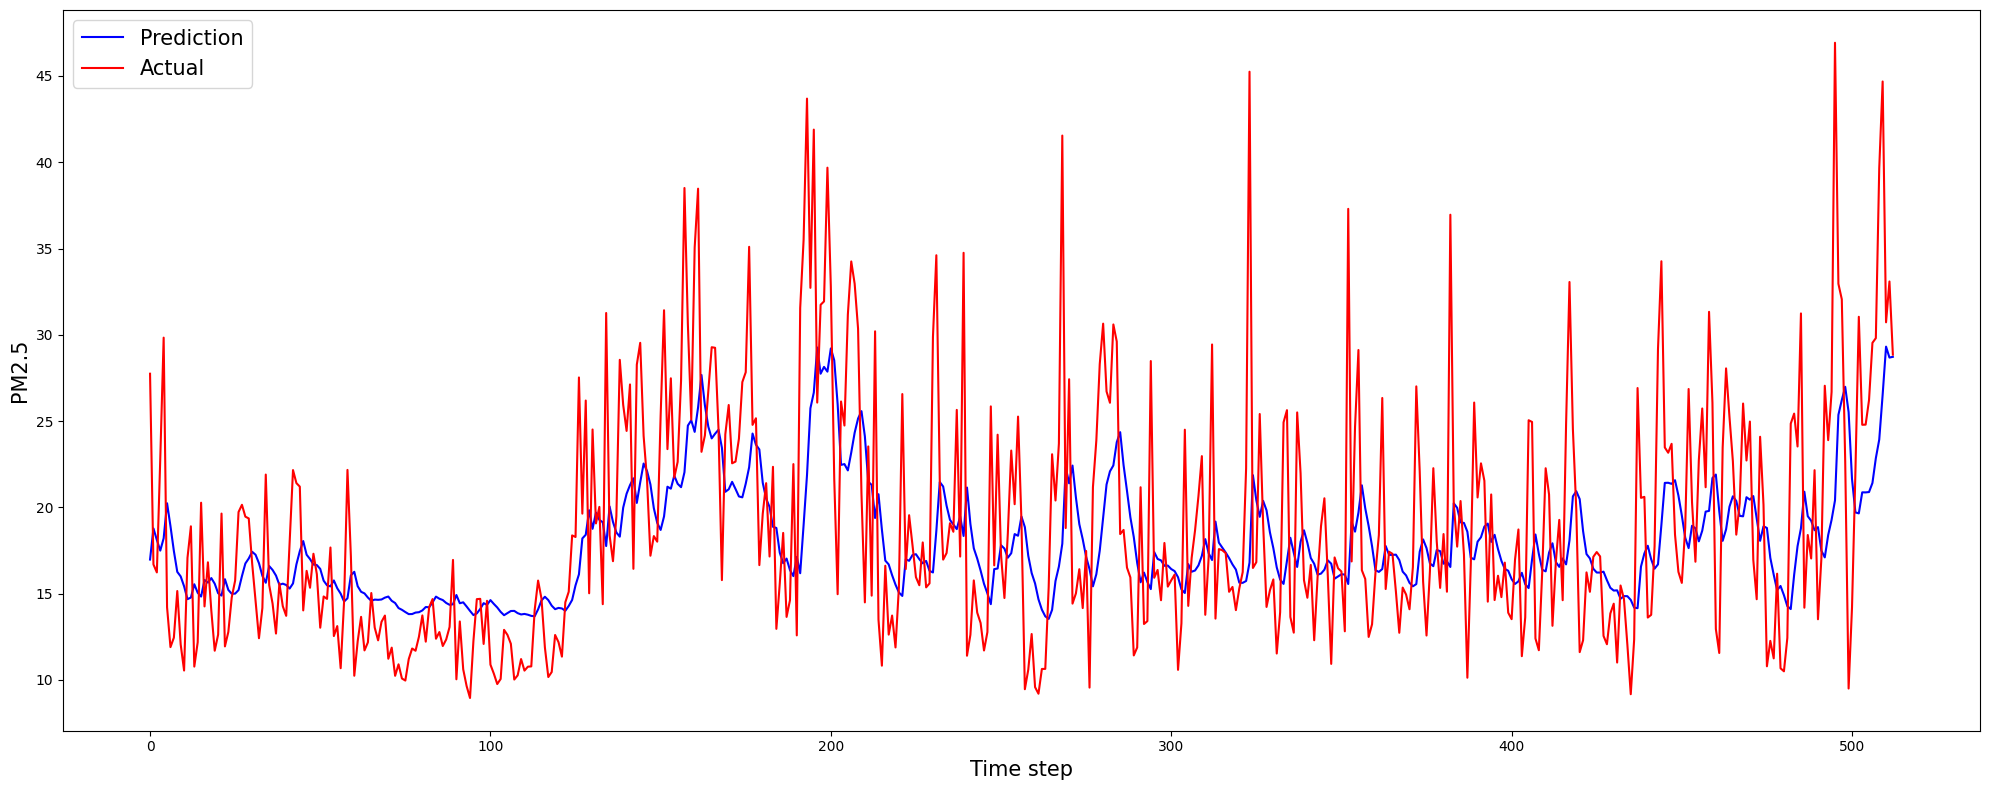

with_pm25_3km dim_reduction_method dim_after_reduction prediction       mae  \
0           Yes                 None                 N/A       LSTM  4.750573   
1            No                 None                 N/A       LSTM  7.395319   
2           Yes         LSTM-Seq2Seq                  18       LSTM  4.856416   
3            No         LSTM-Seq2Seq                  17       LSTM  4.513865   
4           Yes          GRU-Seq2Seq                  18       LSTM  4.176988   
5            No          GRU-Seq2Seq                  17       LSTM  4.444522   
6           Yes      CNNLSTM-Seq2Seq                  18       LSTM  4.376069   

         mse        r2  
0  36.145157 -1.044288  
1  74.086617 -2.062693  
2  38.015234 -8.149209  
3  38.798220 -5.759418  
4  32.625588 -0.484241  
5  33.682952 -0.646832  
6  35.694947 -2.489014

In [46]:
loopresults = generate_loopresults(RANGE_OF_DIMENSION, CNNLSTMSeq2SeqReduction, LSTMPrediction, X_aod_scaled, y_aod_scaled, aod_label_scaler)
best_mae, best_mse, best_r2, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = choose_the_best(loopresults)

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["CNNLSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['mse'] += [best_mse]
evaluation_board['r2'] += [best_r2]
evaluation_board['with_pm25_3km'] += ["Yes"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [47]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_cnnlstms2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_cnnlstms2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_cnnlstms2s_reduced_2021_2022.csv"))
df_cnnlstms2s_reduced

aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2021-01-01      -0.337628      -0.225253      -0.092871      -0.285500   
2021-01-02      -0.337628      -0.225253      -0.092871      -0.285500   
2021-01-03      -0.337628      -0.225253      -0.092871      -0.285500   
2021-01-04      -0.338362      -0.225945      -0.093433      -0.285995   
2021-01-05      -0.333174      -0.225212      -0.091764      -0.282726   
...                   ...            ...            ...            ...   
2022-12-27       0.056345      -0.024972       0.004161      -0.341037   
2022-12-28       0.056315      -0.017529       0.008862      -0.334310   
2022-12-29       0.057990      -0.013183       0.006593      -0.331384   
2022-12-30       0.056933      -0.013262       0.005634      -0.325424   
2022-12-31       0.055763      -0.009614      -0.000293      -0.331861   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2021-01-01       0.064288      -0.058001      -0.020862      -0.053069   
2021-01-02       0.064288      -0.058001      -0.020862      -0.053069   
2021-01-03       0.064288      -0.058001      -0.020862      -0.053069   
2021-01-04       0.065798      -0.057536      -0.020196      -0.053725   
2021-01-05       0.064411      -0.055749      -0.021276      -0.052394   
...                   ...            ...            ...            ...   
2022-12-27       0.284703      -0.137013      -0.015334      -0.275429   
2022-12-28       0.279119      -0.138272      -0.003050      -0.265339   
2022-12-29       0.276617      -0.138956      -0.001139      -0.261816   
2022-12-30       0.273298      -0.135448      -0.004679      -0.259089   
2022-12-31       0.271180      -0.139138       0.002106      -0.257611   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2021-01-01      -0.037584       -0.514023       -0.028712        0.373986   
2021-01-02      -0.037584       -0.514023       -0.028712        0.373986   
2021-01-03      -0.037584       -0.514023       -0.028712        0.373986   
2021-01-04      -0.038624       -0.516576       -0.028104        0.373868   
2021-01-05      -0.038037       -0.510767       -0.024924        0.368915   
...                   ...             ...             ...             ...   
2022-12-27      -0.127747       -0.321742       -0.000118        0.254779   
2022-12-28      -0.129136       -0.304535        0.003382        0.245472   
2022-12-29      -0.126913       -0.297079        0.000762        0.242665   
2022-12-30      -0.123400       -0.297974        0.001439        0.245354   
2022-12-31      -0.122611       -0.294100       -0.006757        0.243664   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2021-01-01        0.631628        0.202963       -0.053505       -0.482541   
2021-01-02        0.631628        0.202963       -0.053505       -0.482541   
2021-01-03        0.631628        0.202963       -0.053505       -0.482541   
2021-01-04        0.634697        0.202724       -0.052851       -0.484851   
2021-01-05        0.627067        0.199426       -0.052199       -0.481601   
...                    ...             ...             ...             ...   
2022-12-27        0.222458        0.043328        0.088731       -0.255336   
2022-12-28        0.215470        0.051424        0.068105       -0.237204   
2022-12-29        0.209897        0.055726        0.062480       -0.231466   
2022-12-30        0.203773        0.053796        0.068644       -0.230242   
2022-12-31        0.217675        0.066153        0.050760       -0.232976   

            aod_feature_17  aod_feature_18  station  
time           

In [48]:
# Prepare the reduced data with additional pm25_3km and predicted pm25 values
df_cnnlstms2s_reduced_augmented = augmentReducedData(df_cnnlstms2s_reduced, y_aod_scaled, aod_pm25_3km_column, aod_label_scaler)
df_cnnlstms2s_reduced_augmented.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_cnnlstms2s_reduced_2021_2022_with_raw_pm25_3km_and_prediced_pm25.csv"))
df_cnnlstms2s_reduced_augmented

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


5.413062315174402


aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2021-01-01      -0.337628      -0.225253      -0.092871      -0.285500   
2021-01-02      -0.337628      -0.225253      -0.092871      -0.285500   
2021-01-03      -0.337628      -0.225253      -0.092871      -0.285500   
2021-01-04      -0.338362      -0.225945      -0.093433      -0.285995   
2021-01-05      -0.333174      -0.225212      -0.091764      -0.282726   
...                   ...            ...            ...            ...   
2022-12-27       0.056345      -0.024972       0.004161      -0.341037   
2022-12-28       0.056315      -0.017529       0.008862      -0.334310   
2022-12-29       0.057990      -0.013183       0.006593      -0.331384   
2022-12-30       0.056933      -0.013262       0.005634      -0.325424   
2022-12-31       0.055763      -0.009614      -0.000293      -0.331861   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2021-01-01       0.064288      -0.058001      -0.020862      -0.053069   
2021-01-02       0.064288      -0.058001      -0.020862      -0.053069   
2021-01-03       0.064288      -0.058001      -0.020862      -0.053069   
2021-01-04       0.065798      -0.057536      -0.020196      -0.053725   
2021-01-05       0.064411      -0.055749      -0.021276      -0.052394   
...                   ...            ...            ...            ...   
2022-12-27       0.284703      -0.137013      -0.015334      -0.275429   
2022-12-28       0.279119      -0.138272      -0.003050      -0.265339   
2022-12-29       0.276617      -0.138956      -0.001139      -0.261816   
2022-12-30       0.273298      -0.135448      -0.004679      -0.259089   
2022-12-31       0.271180      -0.139138       0.002106      -0.257611   

            aod_feature_9  aod_feature_10  ...  aod_feature_12  \
time                                       ...                   
2021-01-01      -0.037584       -0.514023  ...        0.373986   
2021-01-02      -0.037584       -0.514023  ...        0.373986   
2021-01-03      -0.037584       -0.514023  ...        0.373986   
2021-01-04      -0.038624       -0.516576  ...        0.373868   
2021-01-05      -0.038037       -0.510767  ...        0.368915   
...                   ...             ...  ...             ...   
2022-12-27      -0.127747       -0.321742  ...        0.254779   
2022-12-28      -0.129136       -0.304535  ...        0.245472   
2022-12-29      -0.126913       -0.297079  ...        0.242665   
2022-12-30      -0.123400       -0.297974  ...        0.245354   
2022-12-31      -0.122611       -0.294100  ...        0.243664   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2021-01-01        0.631628        0.202963       -0.053505       -0.482541   
2021-01-02        0.631628        0.202963       -0.053505       -0.482541   
2021-01-03        0.631628        0.202963       -0.053505       -0.482541   
2021-01-04        0.634697        0.202724       -0.052851       -0.484851   
2021-01-05        0.627067        0.199426       -0.052199       -0.481601   
...                    ...             ...             ...             ...   
2022-12-27        0.222458        0.043328        0.088731       -0.255336   
2022-12-28        0.215470        0.051424        0.068105       -0.237204   
2022-12-29        0.209897        0.055726        0.062480       -0.231466   
2022-12-30        0.203773        0.053796        0.068644       -0.230242   
2022-12-31        0.217675        0.066153        0.050760       -0.232976   

            aod_feature_17  aod_feature_18  station   pm25_3km  \
time                                                             
2021-01-01        0.383879       -0.166056      201  38.320000   
2021-01-02    

#### Doing the loop (no pm25_3km)

Model: "aod_CNNLSTMSeq2SeqReduction_10_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_136     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 5, 24)     │      1,320 │ input_layer_136[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 1, 12)     │          0 │ conv1d_19[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_102   │ (None, 7, 12)     │          0 │ flatten_9[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_186 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_10… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_195 (Dense)   │ (None, 10)        │        510 │ lstm_186[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_103   │ (None, 7, 10)     │          0 │ dense_195[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_187 (LSTM)     │ (None, 7, 50)     │     12,200 │ repeat_vector_10… │
│                     │                   │            │ lstm_186[0][1],   │
│                     │                   │            │ lstm_186[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_187[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 87,542 (341.96 KB)

 Trainable params: 29,180 (113.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,362 (227.98 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_10_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_137 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_102               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_186 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_195 (Dense)               │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,306 (59.79 KB)

 Trainable params: 15,306 (59.79 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_10_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_138     │ (None, 7, 11)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_188 (LSTM)     │ [(None, 64),      │     19,456 │ input_layer_138[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_104   │ (None, 1, 64)     │          0 │ lstm_188[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_189 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_10… │
│                     │                   │            │ lstm_188[0][1],   │
│                     │                   │            │ lstm_188[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 1, 64)     │          0 │ lstm_189[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_50[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,593 (213.25 KB)

 Trainable params: 54,593 (213.25 KB)

 Non-trainable params: 0 (0.00 B)

None


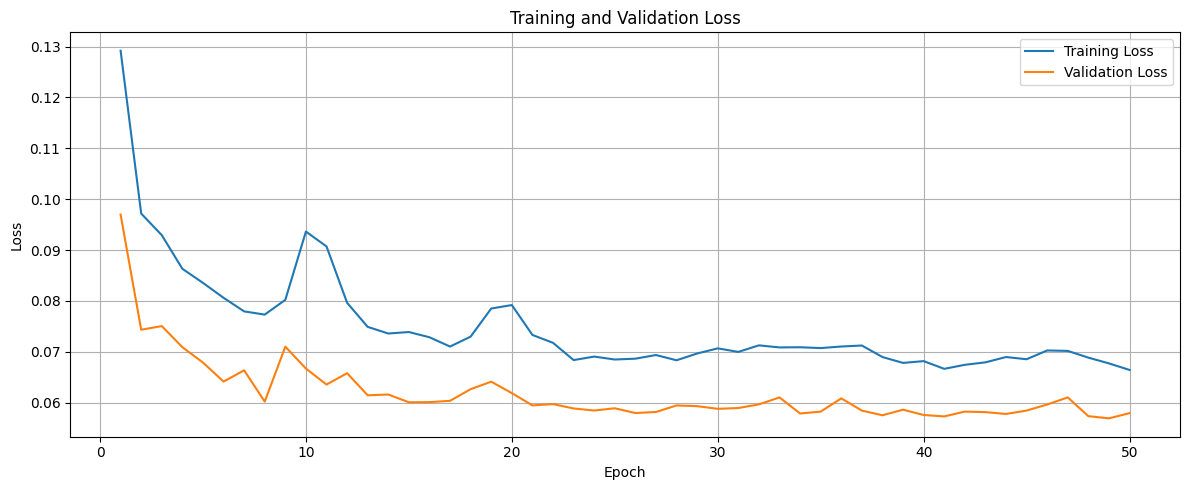

Model: "aod_CNNLSTMSeq2SeqReduction_11_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_139     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 5, 24)     │      1,320 │ input_layer_139[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 1, 12)     │          0 │ conv1d_21[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 12)        │          0 │ max_pooling1d_10… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_105   │ (None, 7, 12)     │          0 │ flatten_10[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_190 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_10… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_200 (Dense)   │ (None, 11)        │        561 │ lstm_190[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_106   │ (None, 7, 11)     │          0 │ dense_200[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_191 (LSTM)     │ (None, 7, 50)     │     12,400 │ repeat_vector_10… │
│                     │                   │            │ lstm_190[0][1],   │
│                     │                   │            │ lstm_190[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_191[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 88,295 (344.91 KB)

 Trainable params: 29,431 (114.96 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,864 (229.94 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_11_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_140 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_105               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_190 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 11)             │           561 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,357 (59.99 KB)

 Trainable params: 15,357 (59.99 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_11_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_141     │ (None, 7, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_192 (LSTM)     │ [(None, 64),      │     19,712 │ input_layer_141[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_107   │ (None, 1, 64)     │          0 │ lstm_192[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_193 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_10… │
│                     │                   │            │ lstm_192[0][1],   │
│                     │                   │            │ lstm_192[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_51          │ (None, 1, 64)     │          0 │ lstm_193[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_51[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,849 (214.25 KB)

 Trainable params: 54,849 (214.25 KB)

 Non-trainable params: 0 (0.00 B)

None


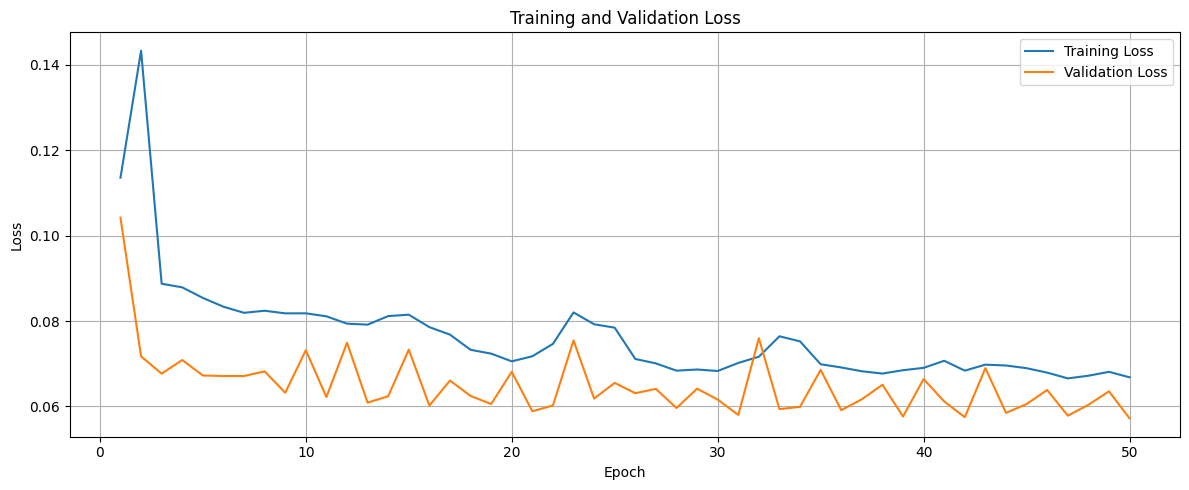

Model: "aod_CNNLSTMSeq2SeqReduction_12_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_142     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 5, 24)     │      1,320 │ input_layer_142[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 1, 12)     │          0 │ conv1d_23[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 12)        │          0 │ max_pooling1d_11… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_108   │ (None, 7, 12)     │          0 │ flatten_11[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_194 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_10… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_205 (Dense)   │ (None, 12)        │        612 │ lstm_194[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_109   │ (None, 7, 12)     │          0 │ dense_205[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_195 (LSTM)     │ (None, 7, 50)     │     12,600 │ repeat_vector_10… │
│                     │                   │            │ lstm_194[0][1],   │
│                     │                   │            │ lstm_194[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_195[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,048 (347.85 KB)

 Trainable params: 29,682 (115.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,366 (231.90 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_12_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_143 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_108               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_194 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,408 (60.19 KB)

 Trainable params: 15,408 (60.19 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_12_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_144     │ (None, 7, 13)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_196 (LSTM)     │ [(None, 64),      │     19,968 │ input_layer_144[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_110   │ (None, 1, 64)     │          0 │ lstm_196[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_197 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_11… │
│                     │                   │            │ lstm_196[0][1],   │
│                     │                   │            │ lstm_196[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (None, 1, 64)     │          0 │ lstm_197[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_52[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,105 (215.25 KB)

 Trainable params: 55,105 (215.25 KB)

 Non-trainable params: 0 (0.00 B)

None


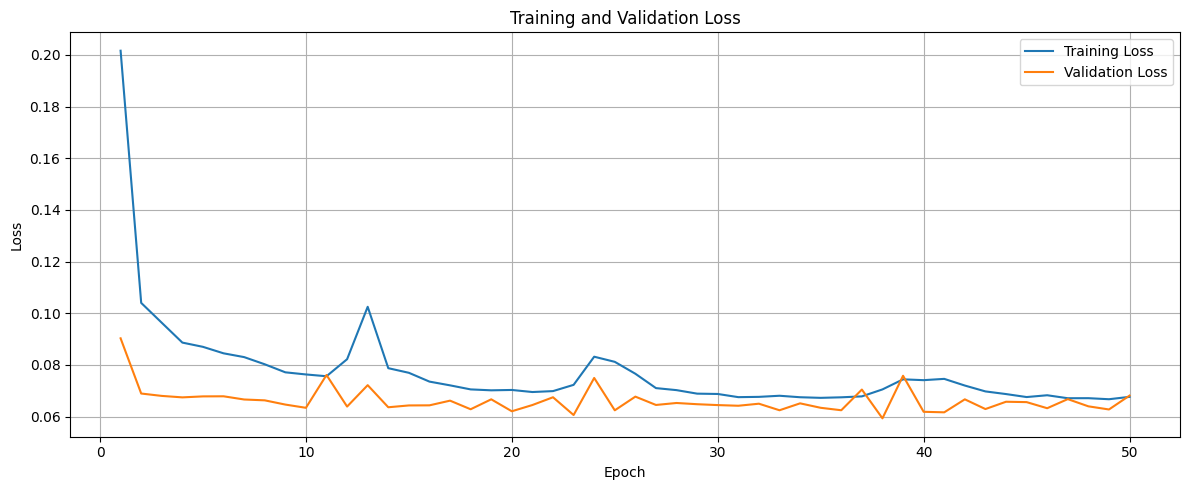

Model: "aod_CNNLSTMSeq2SeqReduction_13_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_145     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 5, 24)     │      1,320 │ input_layer_145[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 1, 12)     │          0 │ conv1d_25[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 12)        │          0 │ max_pooling1d_12… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_111   │ (None, 7, 12)     │          0 │ flatten_12[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_198 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_11… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_210 (Dense)   │ (None, 13)        │        663 │ lstm_198[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_112   │ (None, 7, 13)     │          0 │ dense_210[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_199 (LSTM)     │ (None, 7, 50)     │     12,800 │ repeat_vector_11… │
│                     │                   │            │ lstm_198[0][1],   │
│                     │                   │            │ lstm_198[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_199[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,801 (350.79 KB)

 Trainable params: 29,933 (116.93 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,868 (233.86 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_13_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_146 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_111               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_198 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_210 (Dense)               │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,459 (60.39 KB)

 Trainable params: 15,459 (60.39 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_13_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_147     │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_200 (LSTM)     │ [(None, 64),      │     20,224 │ input_layer_147[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_113   │ (None, 1, 64)     │          0 │ lstm_200[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_201 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_11… │
│                     │                   │            │ lstm_200[0][1],   │
│                     │                   │            │ lstm_200[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_53          │ (None, 1, 64)     │          0 │ lstm_201[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_53[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,361 (216.25 KB)

 Trainable params: 55,361 (216.25 KB)

 Non-trainable params: 0 (0.00 B)

None


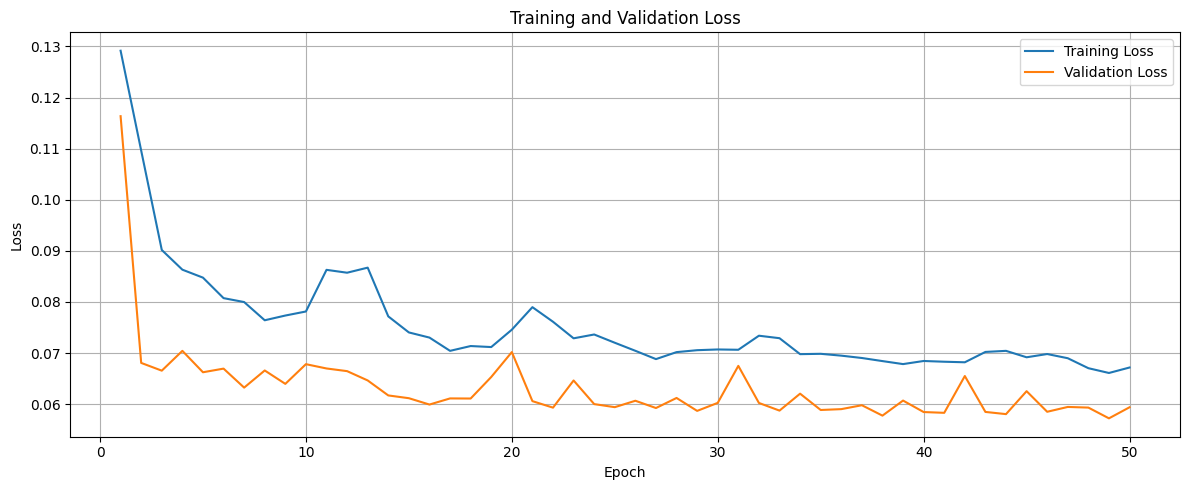

Model: "aod_CNNLSTMSeq2SeqReduction_14_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_148     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 5, 24)     │      1,320 │ input_layer_148[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_26[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 1, 12)     │          0 │ conv1d_27[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 12)        │          0 │ max_pooling1d_13… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_114   │ (None, 7, 12)     │          0 │ flatten_13[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_202 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_11… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_215 (Dense)   │ (None, 14)        │        714 │ lstm_202[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_115   │ (None, 7, 14)     │          0 │ dense_215[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_203 (LSTM)     │ (None, 7, 50)     │     13,000 │ repeat_vector_11… │
│                     │                   │            │ lstm_202[0][1],   │
│                     │                   │            │ lstm_202[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_203[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 90,554 (353.73 KB)

 Trainable params: 30,184 (117.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 60,370 (235.82 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_14_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_149 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_114               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_202 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,510 (60.59 KB)

 Trainable params: 15,510 (60.59 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_14_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_150     │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_204 (LSTM)     │ [(None, 64),      │     20,480 │ input_layer_150[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_116   │ (None, 1, 64)     │          0 │ lstm_204[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_205 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_11… │
│                     │                   │            │ lstm_204[0][1],   │
│                     │                   │            │ lstm_204[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_54          │ (None, 1, 64)     │          0 │ lstm_205[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_54[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,617 (217.25 KB)

 Trainable params: 55,617 (217.25 KB)

 Non-trainable params: 0 (0.00 B)

None


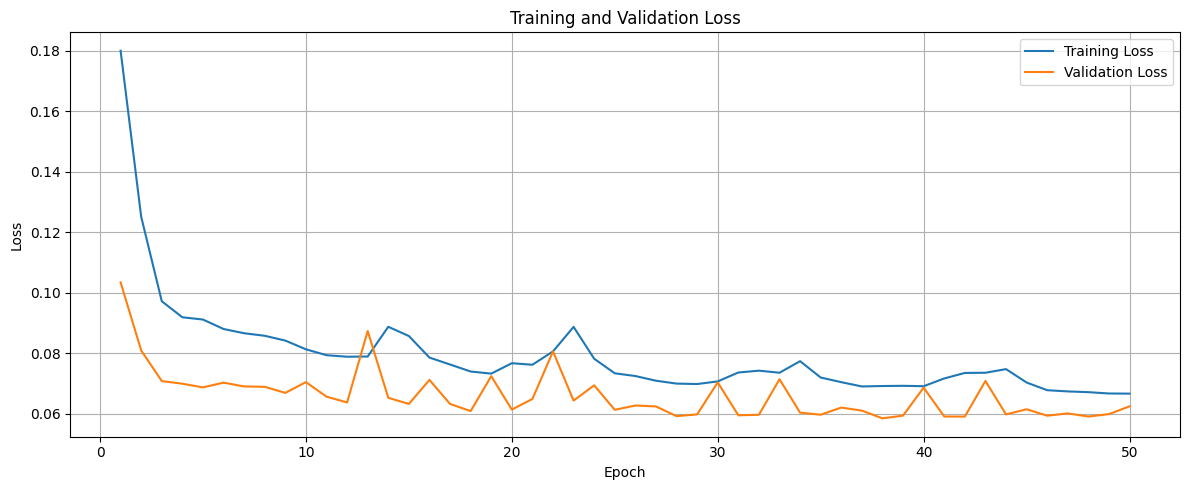

Model: "aod_CNNLSTMSeq2SeqReduction_15_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_151     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 5, 24)     │      1,320 │ input_layer_151[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_14    │ (None, 1, 12)     │          0 │ conv1d_29[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 12)        │          0 │ max_pooling1d_14… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_117   │ (None, 7, 12)     │          0 │ flatten_14[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_206 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_11… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_220 (Dense)   │ (None, 15)        │        765 │ lstm_206[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_118   │ (None, 7, 15)     │          0 │ dense_220[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_207 (LSTM)     │ (None, 7, 50)     │     13,200 │ repeat_vector_11… │
│                     │                   │            │ lstm_206[0][1],   │
│                     │                   │            │ lstm_206[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_207[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,307 (356.67 KB)

 Trainable params: 30,435 (118.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 60,872 (237.79 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_15_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_152 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_117               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_206 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_220 (Dense)               │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,561 (60.79 KB)

 Trainable params: 15,561 (60.79 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_15_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_153     │ (None, 7, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_208 (LSTM)     │ [(None, 64),      │     20,736 │ input_layer_153[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_119   │ (None, 1, 64)     │          0 │ lstm_208[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_209 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_11… │
│                     │                   │            │ lstm_208[0][1],   │
│                     │                   │            │ lstm_208[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_55          │ (None, 1, 64)     │          0 │ lstm_209[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_55[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,873 (218.25 KB)

 Trainable params: 55,873 (218.25 KB)

 Non-trainable params: 0 (0.00 B)

None


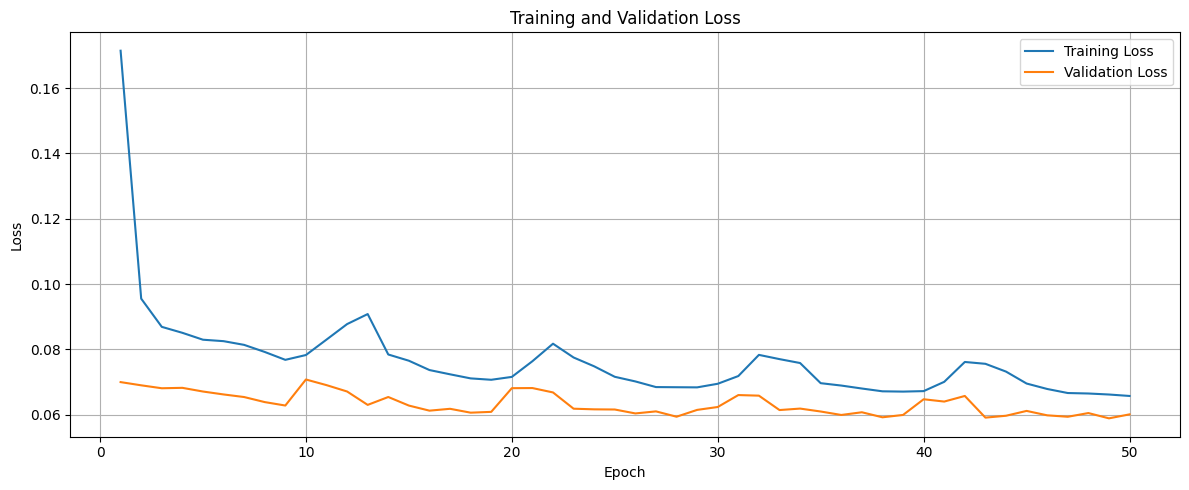

Model: "aod_CNNLSTMSeq2SeqReduction_16_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_154     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 5, 24)     │      1,320 │ input_layer_154[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 1, 12)     │          0 │ conv1d_31[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 12)        │          0 │ max_pooling1d_15… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_120   │ (None, 7, 12)     │          0 │ flatten_15[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_210 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_12… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_225 (Dense)   │ (None, 16)        │        816 │ lstm_210[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_121   │ (None, 7, 16)     │          0 │ dense_225[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_211 (LSTM)     │ (None, 7, 50)     │     13,400 │ repeat_vector_12… │
│                     │                   │            │ lstm_210[0][1],   │
│                     │                   │            │ lstm_210[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_211[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,060 (359.61 KB)

 Trainable params: 30,686 (119.87 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,374 (239.75 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_16_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_155 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_120               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_210 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,612 (60.98 KB)

 Trainable params: 15,612 (60.98 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_16_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_156     │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_212 (LSTM)     │ [(None, 64),      │     20,992 │ input_layer_156[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_122   │ (None, 1, 64)     │          0 │ lstm_212[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_213 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_12… │
│                     │                   │            │ lstm_212[0][1],   │
│                     │                   │            │ lstm_212[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_56          │ (None, 1, 64)     │          0 │ lstm_213[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_56[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,129 (219.25 KB)

 Trainable params: 56,129 (219.25 KB)

 Non-trainable params: 0 (0.00 B)

None


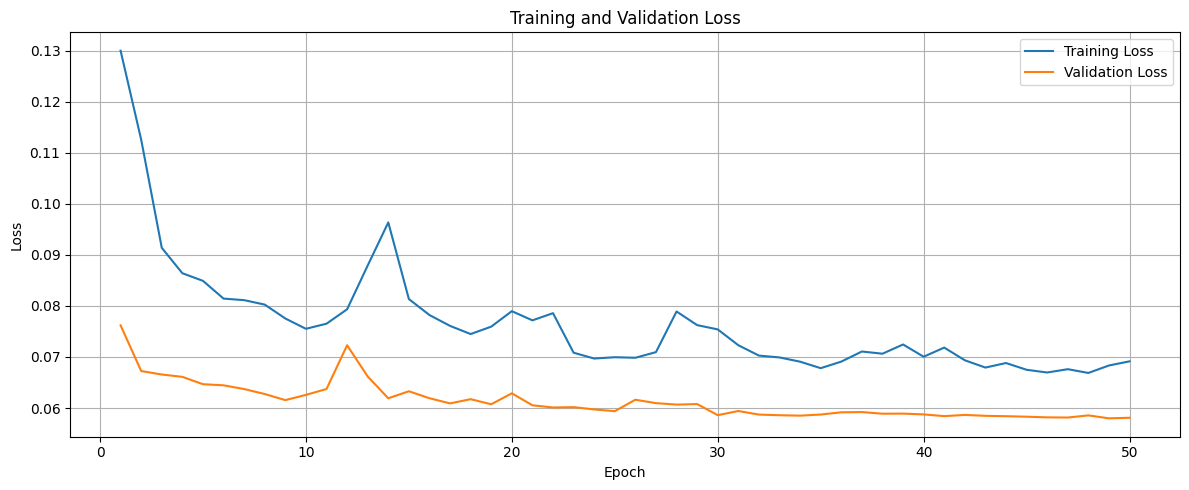

Model: "aod_CNNLSTMSeq2SeqReduction_17_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_157     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 5, 24)     │      1,320 │ input_layer_157[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 1, 12)     │          0 │ conv1d_33[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_16          │ (None, 12)        │          0 │ max_pooling1d_16… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_123   │ (None, 7, 12)     │          0 │ flatten_16[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_214 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_12… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_230 (Dense)   │ (None, 17)        │        867 │ lstm_214[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_124   │ (None, 7, 17)     │          0 │ dense_230[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_215 (LSTM)     │ (None, 7, 50)     │     13,600 │ repeat_vector_12… │
│                     │                   │            │ lstm_214[0][1],   │
│                     │                   │            │ lstm_214[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_215[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,813 (362.55 KB)

 Trainable params: 30,937 (120.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,876 (241.71 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_17_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_158 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_123               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_214 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_230 (Dense)               │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,663 (61.18 KB)

 Trainable params: 15,663 (61.18 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_17_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_159     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_216 (LSTM)     │ [(None, 64),      │     21,248 │ input_layer_159[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_125   │ (None, 1, 64)     │          0 │ lstm_216[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_217 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_12… │
│                     │                   │            │ lstm_216[0][1],   │
│                     │                   │            │ lstm_216[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_57          │ (None, 1, 64)     │          0 │ lstm_217[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_57[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,385 (220.25 KB)

 Trainable params: 56,385 (220.25 KB)

 Non-trainable params: 0 (0.00 B)

None


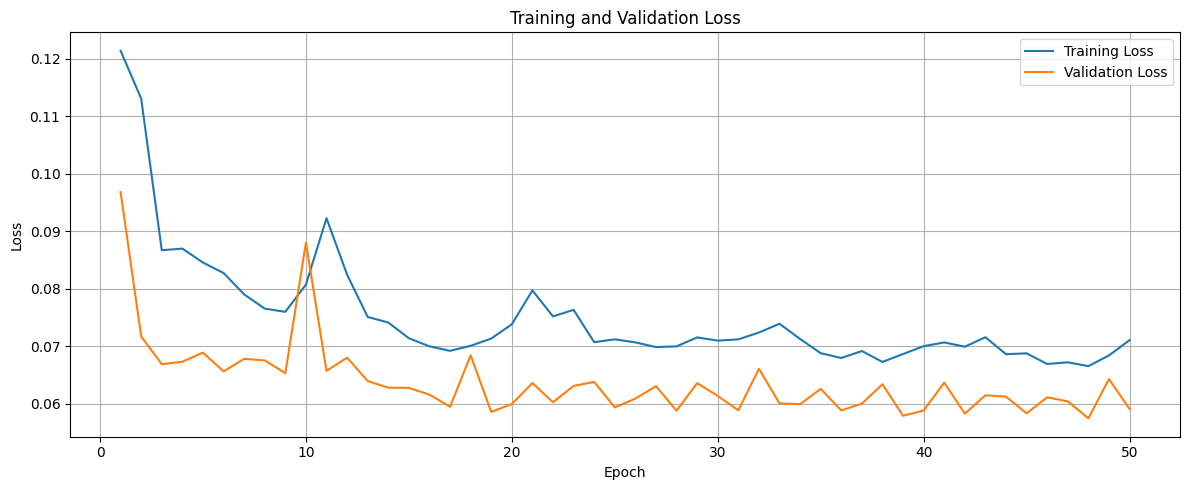

Model: "aod_CNNLSTMSeq2SeqReduction_18_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_160     │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 5, 24)     │      1,320 │ input_layer_160[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_34[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 1, 12)     │          0 │ conv1d_35[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_17          │ (None, 12)        │          0 │ max_pooling1d_17… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_126   │ (None, 7, 12)     │          0 │ flatten_17[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_218 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_12… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_235 (Dense)   │ (None, 18)        │        918 │ lstm_218[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_127   │ (None, 7, 18)     │          0 │ dense_235[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_219 (LSTM)     │ (None, 7, 50)     │     13,800 │ repeat_vector_12… │
│                     │                   │            │ lstm_218[0][1],   │
│                     │                   │            │ lstm_218[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 24)     │      1,224 │ lstm_219[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 93,566 (365.50 KB)

 Trainable params: 31,188 (121.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,378 (243.67 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_18_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_161 (InputLayer)    │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_126               │ (None, 7, 12)          │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_218 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,714 (61.38 KB)

 Trainable params: 15,714 (61.38 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_18_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_162     │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_220 (LSTM)     │ [(None, 64),      │     21,504 │ input_layer_162[… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_128   │ (None, 1, 64)     │          0 │ lstm_220[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_221 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_12… │
│                     │                   │            │ lstm_220[0][1],   │
│                     │                   │            │ lstm_220[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_58          │ (None, 1, 64)     │          0 │ lstm_221[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 32)     │      2,080 │ dropout_58[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 1, 1)      │         33 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,641 (221.25 KB)

 Trainable params: 56,641 (221.25 KB)

 Non-trainable params: 0 (0.00 B)

None


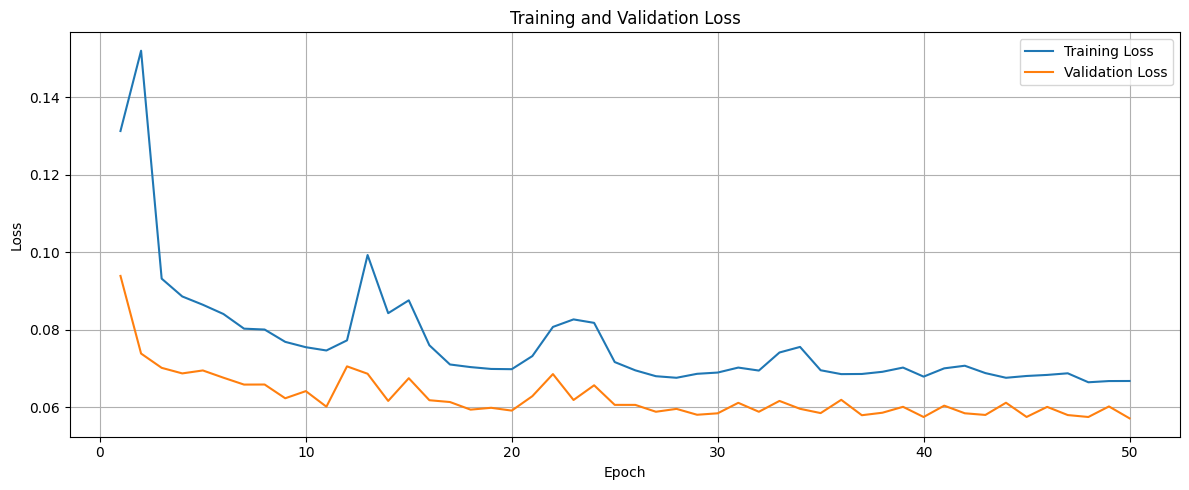

N = 10 - mae = 4.255242303082, mse = 34.132760362828016, r2 = -1.1152145886549967
N = 11 - mae = 4.296027092021826, mse = 36.60493086754329, r2 = -1.7398927898560492
N = 12 - mae = 5.0754565528582525, mse = 38.31675069189482, r2 = -1.844414653219809
N = 13 - mae = 4.4032731631336475, mse = 34.478668169688426, r2 = -0.9242895807261506
N = 14 - mae = 4.7369865510410065, mse = 35.79091604169942, r2 = -1.6195075739793432
N = 15 - mae = 4.3678266217918695, mse = 34.04358573872641, r2 = -1.2545322887165127
N = 16 - mae = 4.342518331827476, mse = 37.99104287346884, r2 = -2.108073569400678
N = 17 - mae = 4.366931433686511, mse = 34.39802320380327, r2 = -1.841902692143408
N = 18 - mae = 4.294034392264018, mse = 34.92503368780186, r2 = -1.890390710612773


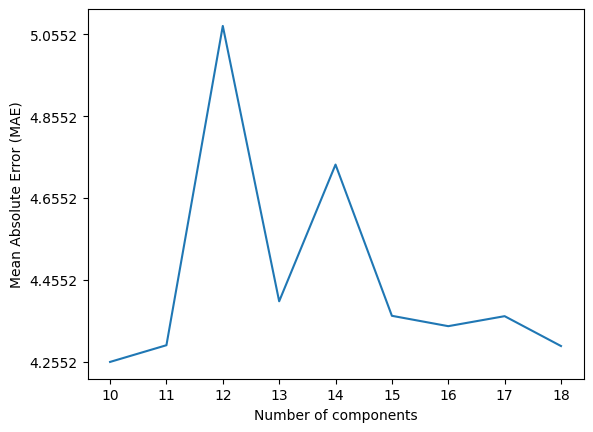

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


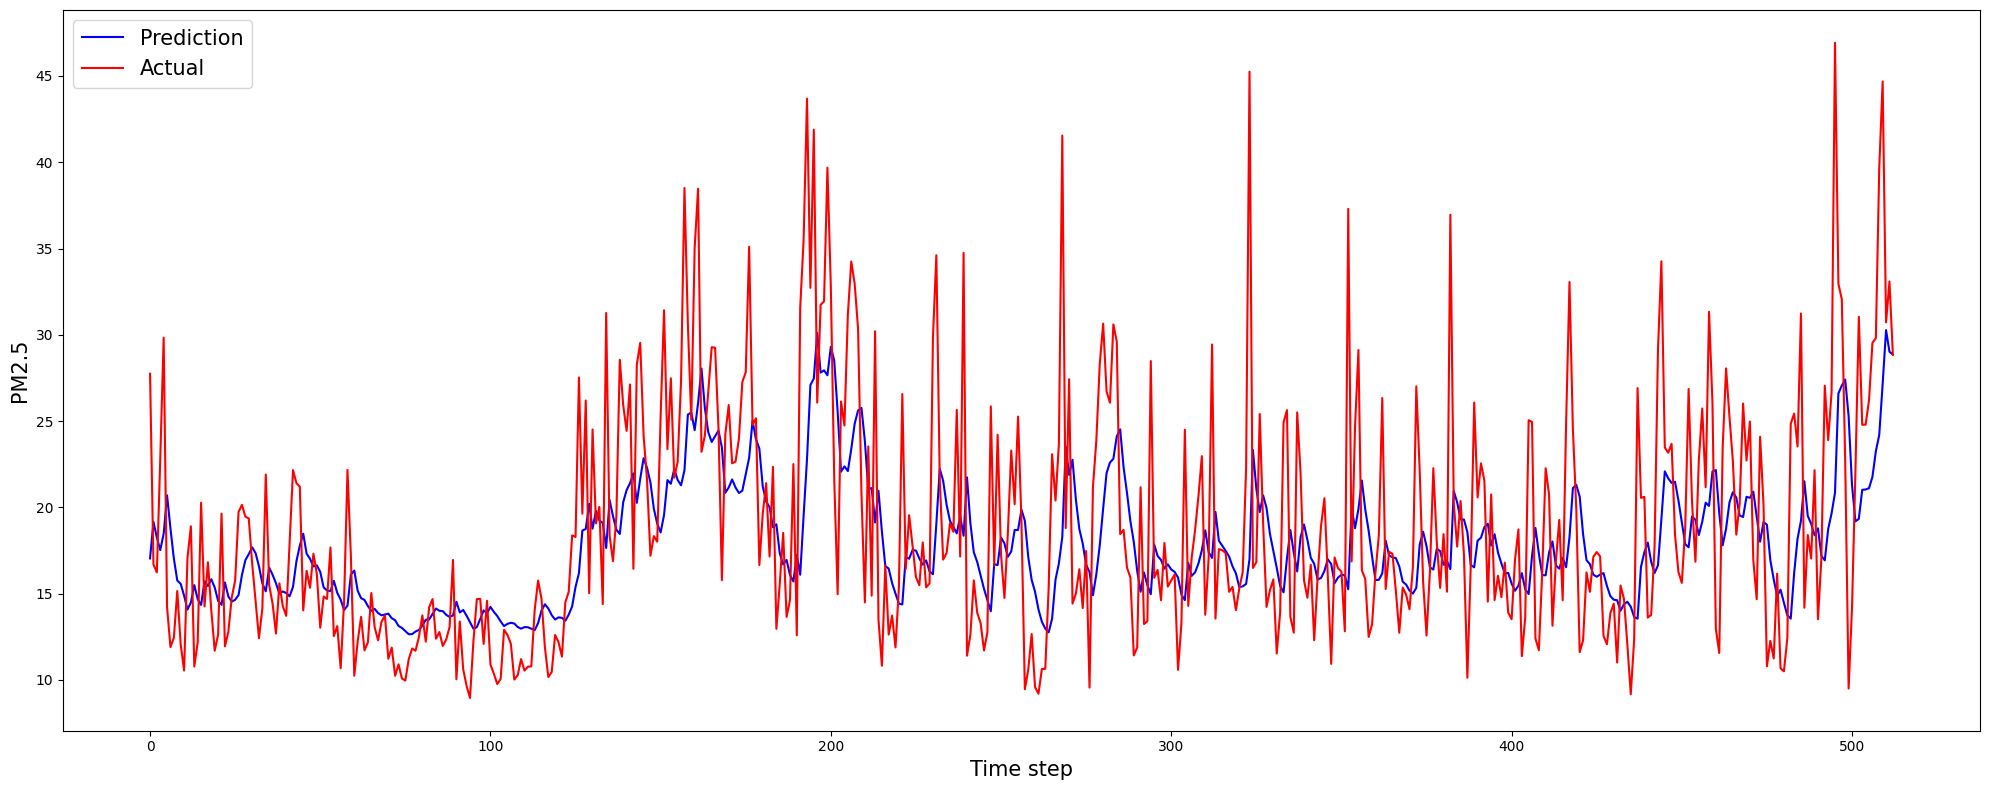

with_pm25_3km dim_reduction_method dim_after_reduction prediction       mae  \
0           Yes                 None                 N/A       LSTM  4.750573   
1            No                 None                 N/A       LSTM  7.395319   
2           Yes         LSTM-Seq2Seq                  18       LSTM  4.856416   
3            No         LSTM-Seq2Seq                  17       LSTM  4.513865   
4           Yes          GRU-Seq2Seq                  18       LSTM  4.176988   
5            No          GRU-Seq2Seq                  17       LSTM  4.444522   
6           Yes      CNNLSTM-Seq2Seq                  18       LSTM  4.376069   
7            No      CNNLSTM-Seq2Seq                  18       LSTM  4.294034   

         mse        r2  
0  36.145157 -1.044288  
1  74.086617 -2.062693  
2  38.015234 -8.149209  
3  38.798220 -5.759418  
4  32.625588 -0.484241  
5  33.682952 -0.646832  
6  35.694947 -2.489014  
7  34.925034 -1.890391

In [49]:
loopresults = generate_loopresults(RANGE_OF_DIMENSION, CNNLSTMSeq2SeqReduction, LSTMPrediction, X_aod_no_pm25_3km_scaled, y_aod_scaled, aod_label_scaler, False)
best_mae, best_mse, best_r2, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = choose_the_best(loopresults)

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["CNNLSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['mse'] += [best_mse]
evaluation_board['r2'] += [best_r2]
evaluation_board['with_pm25_3km'] += ["No"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data (no pm25_3km)

In [50]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_cnnlstms2s_reduced_no_pm25_3km = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_cnnlstms2s_reduced_no_pm25_3km.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_cnnlstms2s_reduced_2021_2022_no_pm25_3km.csv"))
df_cnnlstms2s_reduced_no_pm25_3km

aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2021-01-01      -0.048351       0.056426      -0.459297       0.335972   
2021-01-02      -0.048351       0.056426      -0.459297       0.335972   
2021-01-03      -0.048351       0.056426      -0.459297       0.335972   
2021-01-04      -0.047832       0.056143      -0.460874       0.335915   
2021-01-05      -0.048290       0.056711      -0.461867       0.336772   
...                   ...            ...            ...            ...   
2022-12-27       0.303703      -0.222039      -0.210042      -0.135147   
2022-12-28       0.309783      -0.233998      -0.203024      -0.149427   
2022-12-29       0.289596      -0.219079      -0.205282      -0.130925   
2022-12-30       0.285015      -0.215848      -0.206936      -0.125028   
2022-12-31       0.283116      -0.213957      -0.207283      -0.119815   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2021-01-01       0.081596      -0.160554       0.161041      -0.004413   
2021-01-02       0.081596      -0.160554       0.161041      -0.004413   
2021-01-03       0.081596      -0.160554       0.161041      -0.004413   
2021-01-04       0.080846      -0.160889       0.161771      -0.003532   
2021-01-05       0.081042      -0.160998       0.162191      -0.003029   
...                   ...            ...            ...            ...   
2022-12-27       0.005818      -0.212668       0.145311      -0.032485   
2022-12-28       0.000679      -0.214995       0.150622      -0.026570   
2022-12-29       0.007317      -0.207857       0.144459      -0.028470   
2022-12-30       0.010408      -0.206317       0.143509      -0.029014   
2022-12-31       0.014022      -0.204452       0.142660      -0.030480   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2021-01-01      -0.118735       -0.435818        0.253643        0.388680   
2021-01-02      -0.118735       -0.435818        0.253643        0.388680   
2021-01-03      -0.118735       -0.435818        0.253643        0.388680   
2021-01-04      -0.120420       -0.438056        0.252841        0.390426   
2021-01-05      -0.120737       -0.439273        0.253266        0.391832   
...                   ...             ...             ...             ...   
2022-12-27      -0.119168        0.020643        0.198947       -0.056031   
2022-12-28      -0.115220        0.032615        0.183653       -0.051125   
2022-12-29      -0.112369        0.007899        0.177583       -0.032725   
2022-12-30      -0.111180        0.001350        0.178760       -0.027133   
2022-12-31      -0.109557       -0.000193        0.183567       -0.025444   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2021-01-01       -0.055767       -0.015127        0.084759        0.045833   
2021-01-02       -0.055767       -0.015127        0.084759        0.045833   
2021-01-03       -0.055767       -0.015127        0.084759        0.045833   
2021-01-04       -0.054690       -0.014118        0.086452        0.047401   
2021-01-05       -0.054809       -0.014363        0.086499        0.048159   
...                    ...             ...             ...             ...   
2022-12-27       -0.048816        0.074554       -0.005887       -0.085926   
2022-12-28       -0.044791        0.084186        0.005327       -0.081503   
2022-12-29       -0.043920        0.077274        0.017195       -0.067637   
2022-12-30       -0.045171        0.074913        0.018577       -0.065987   
2022-12-31       -0.048514        0.072147        0.014947       -0.070375   

            aod_feature_17  aod_feature_18  station  
time           

In [51]:
# Prepare the reduced data with additional pm25_3km and predicted pm25 values
df_cnnlstms2s_reduced_augmented = augmentReducedData(df_cnnlstms2s_reduced_no_pm25_3km, y_aod_scaled, aod_pm25_3km_column, aod_label_scaler)
df_cnnlstms2s_reduced_augmented.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_cnnlstms2s_reduced_2021_2022_no_pm25_3km_with_raw_pm25_3km_and_prediced_pm25.csv"))
df_cnnlstms2s_reduced_augmented

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


5.218128156052884


aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2021-01-01      -0.048351       0.056426      -0.459297       0.335972   
2021-01-02      -0.048351       0.056426      -0.459297       0.335972   
2021-01-03      -0.048351       0.056426      -0.459297       0.335972   
2021-01-04      -0.047832       0.056143      -0.460874       0.335915   
2021-01-05      -0.048290       0.056711      -0.461867       0.336772   
...                   ...            ...            ...            ...   
2022-12-27       0.303703      -0.222039      -0.210042      -0.135147   
2022-12-28       0.309783      -0.233998      -0.203024      -0.149427   
2022-12-29       0.289596      -0.219079      -0.205282      -0.130925   
2022-12-30       0.285015      -0.215848      -0.206936      -0.125028   
2022-12-31       0.283116      -0.213957      -0.207283      -0.119815   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2021-01-01       0.081596      -0.160554       0.161041      -0.004413   
2021-01-02       0.081596      -0.160554       0.161041      -0.004413   
2021-01-03       0.081596      -0.160554       0.161041      -0.004413   
2021-01-04       0.080846      -0.160889       0.161771      -0.003532   
2021-01-05       0.081042      -0.160998       0.162191      -0.003029   
...                   ...            ...            ...            ...   
2022-12-27       0.005818      -0.212668       0.145311      -0.032485   
2022-12-28       0.000679      -0.214995       0.150622      -0.026570   
2022-12-29       0.007317      -0.207857       0.144459      -0.028470   
2022-12-30       0.010408      -0.206317       0.143509      -0.029014   
2022-12-31       0.014022      -0.204452       0.142660      -0.030480   

            aod_feature_9  aod_feature_10  ...  aod_feature_12  \
time                                       ...                   
2021-01-01      -0.118735       -0.435818  ...        0.388680   
2021-01-02      -0.118735       -0.435818  ...        0.388680   
2021-01-03      -0.118735       -0.435818  ...        0.388680   
2021-01-04      -0.120420       -0.438056  ...        0.390426   
2021-01-05      -0.120737       -0.439273  ...        0.391832   
...                   ...             ...  ...             ...   
2022-12-27      -0.119168        0.020643  ...       -0.056031   
2022-12-28      -0.115220        0.032615  ...       -0.051125   
2022-12-29      -0.112369        0.007899  ...       -0.032725   
2022-12-30      -0.111180        0.001350  ...       -0.027133   
2022-12-31      -0.109557       -0.000193  ...       -0.025444   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2021-01-01       -0.055767       -0.015127        0.084759        0.045833   
2021-01-02       -0.055767       -0.015127        0.084759        0.045833   
2021-01-03       -0.055767       -0.015127        0.084759        0.045833   
2021-01-04       -0.054690       -0.014118        0.086452        0.047401   
2021-01-05       -0.054809       -0.014363        0.086499        0.048159   
...                    ...             ...             ...             ...   
2022-12-27       -0.048816        0.074554       -0.005887       -0.085926   
2022-12-28       -0.044791        0.084186        0.005327       -0.081503   
2022-12-29       -0.043920        0.077274        0.017195       -0.067637   
2022-12-30       -0.045171        0.074913        0.018577       -0.065987   
2022-12-31       -0.048514        0.072147        0.014947       -0.070375   

            aod_feature_17  aod_feature_18  station   pm25_3km  \
time                                                             
2021-01-01        0.236817       -0.052610      201  38.320000   
2021-01-02    